# Project – Wind Energy Prediction

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.in2p3.fr%2Fenergy4climate%2Fpublic%2Feducation%2Fmachine_learning_for_climate_and_energy/master?filepath=book%2Fnotebooks%2Fprojects.ipynb)

## Introduction

Since the Industrial Revolution, electricity has become deeply integrated into humanity’s daily life, establishing an essential foundation for the consolidation of our society. Energy has become ubiquitous in individuals’ lives, being used in various sectors such as industrial processes, transportation, heating, domestic comfort, among others. Thus, access to electricity is now considered an essential infrastructure service, serving as an indicator of a nation’s level of socio-economic development.

The energy sector is one of the main contributors to global greenhouse gas emissions, primarily due to the combustion of fossil fuels for electricity generation, transportation, and industrial processes. The Intergovernmental Panel on Climate Change (2025) indicate that annual global emissions exceed tens of gigatonnes of CO₂ equivalent, making the transformation of the energy system a central priority for climate change mitigation. Nevertheless, the global energy mix remains heavily dependent on non-renewable sources such as coal and natural gas, which, according to the International Energy Agency (2023), account for more than 58% of total energy supply. The extensive use of these sources has significant environmental consequences, as their combustion releases large amounts of atmospheric pollutants, contributing to global warming, air pollution, and other environmental impacts, including ocean acidification.

Although renewable energy has experienced notable growth in recent years, it historically accounted for a limited share of the global energy matrix. Data from the IEA show that the expansion of renewables accelerated mainly in recent decades, driven by technological advances, cost reductions, and the implementation of supportive public policies. In this context, wind energy stands out among renewable sources due to its high potential for expansion, technological maturity, and increasing economic competitiveness. According to Global Wind Energy Council, global installed wind power capacity has surpassed 1 terawatt, with annual capacity additions exceeding 100 gigawatts, positioning wind energy as a major driver of renewable electricity generation growth worldwide.

Currently, wind energy accounts for a significant share of global renewable electricity generation, contributing substantially to greenhouse gas emission reductions and to enhanced energy security. The continued expansion of both onshore and offshore wind power reinforces its strategic importance in the global energy transition. However, the increasing penetration of intermittent renewable sources also poses challenges to power system reliability. The blackout that occurred in Spain and Portugal in April of this year highlighted society’s strong dependence on electricity and exposed structural vulnerabilities in the Iberian Peninsula’s power grid, particularly regarding the management of renewable variability and the limited integration with the broader European electricity system. This event clearly illustrates one of the main challenges associated with energy security in the transition toward more sustainable energy systems, underscoring the need for investments in infrastructure, regional integration, smart grids, and energy storage solutions.

In this context, accurately predicting wind power generation is crucial to improve grid reliability and support the integration of renewable energy sources. Machine learning methods offer a data-driven approach to capture the complex relationships between atmospheric variables and wind energy production. This project explores the application of different approaches to predict the wind capacity factor in metropolitan France based on climate reanalysis data.

## 1. Data analysis

In [93]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
from sklearn.model_selection import cross_val_score
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, LinearRegression, LassoCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

<Axes: xlabel='time'>

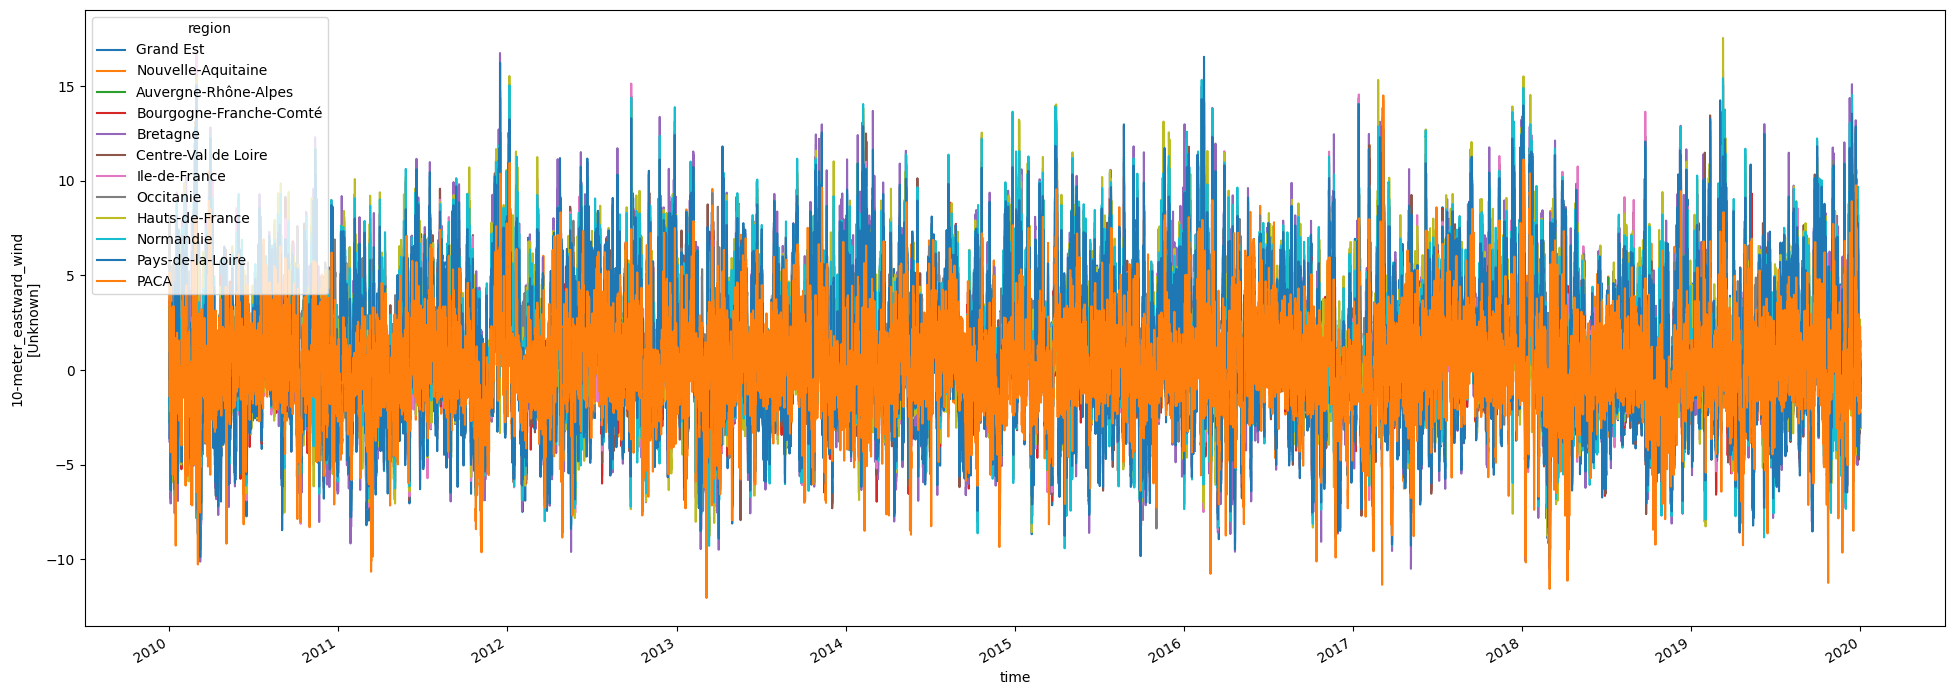

<Figure size 640x480 with 0 Axes>

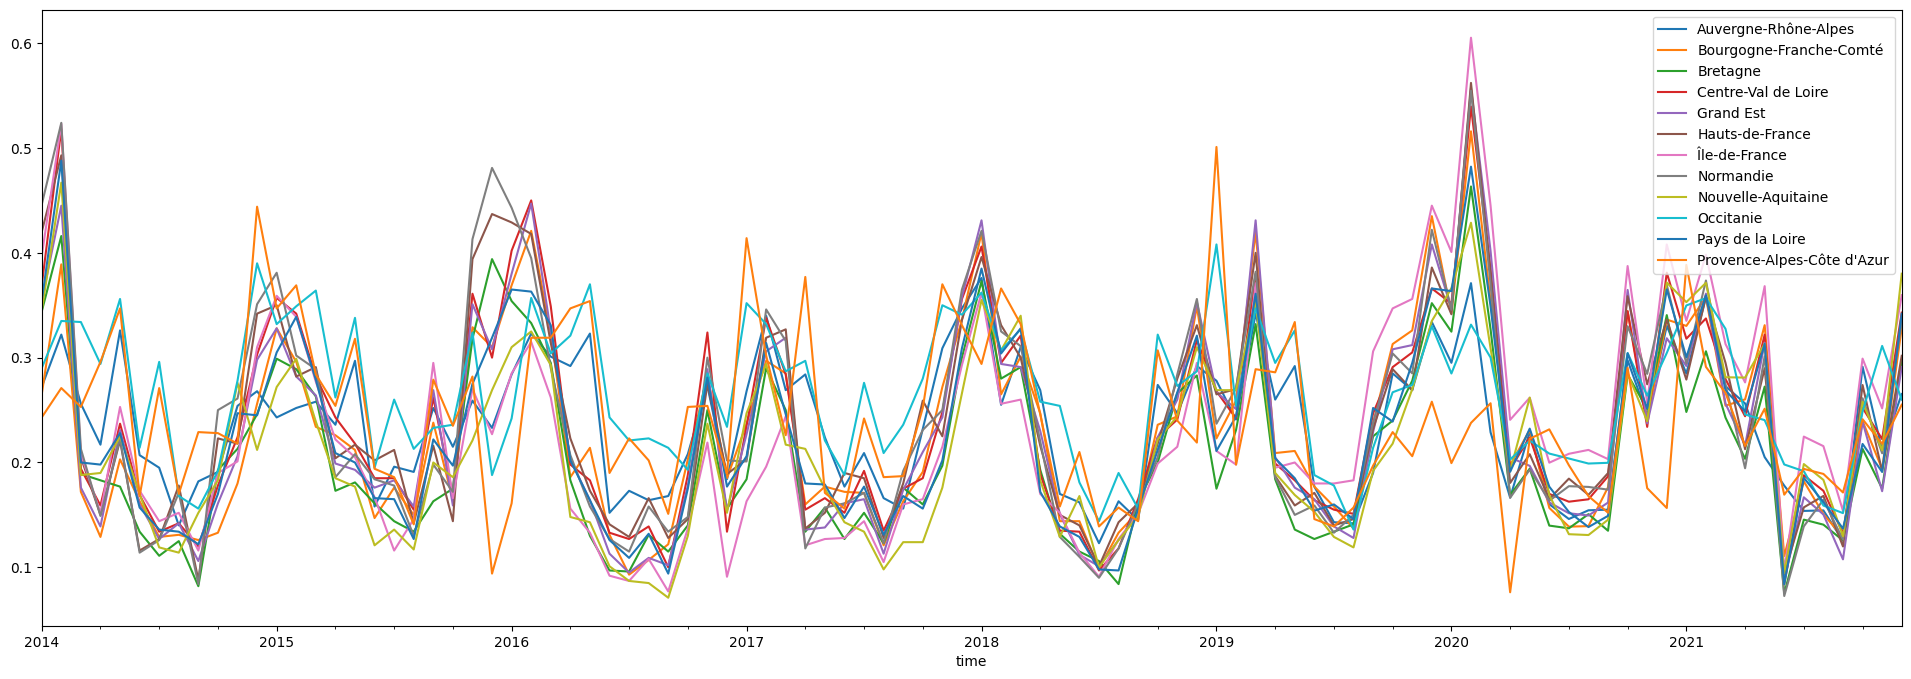

In [94]:
# Directories where you saved the data
data_dir_energy = Path('data/projects/energy_france')
data_dir_climate = Path('data/projects/climate_france')
                        
# Template filenames
filename_mask = 'mask_datagouv_french_regions_merra2_Nx_France.nc'
filename_climate = 'merra2_area_selection_output_{}_merra2_2010-2019.nc'
filename_energy = 'reseaux_energies_{}.csv'

# Read and plot grid point-region mask
filepath_mask = Path(data_dir_climate, filename_mask)   
ds_mask = xr.load_dataset(filepath_mask)
da_mask = ds_mask['mask']
#plt.figure()
#plt.scatter(da_mask['lon'], da_mask['lat'], c=da_mask, cmap='Set1')

# Read a climate variable and plot its mean over time
variable_name = 'zonal_wind'
filename = filename_climate.format(variable_name)
filepath = Path(data_dir_climate, filename)
da_climate = xr.load_dataset(filepath)[variable_name]
#plt.figure()
#plt.scatter(da_mask['lon'], da_mask['lat'], c=da_climate.mean('time'))

# Compute regional mean of climate variable and plot time series
da_climate_reg = da_climate.groupby(da_mask).mean().rename(mask='region')
da_climate_reg['region'] = ds_mask['region'].values
plt.figure(figsize=(24,8))
da_climate_reg.plot.line(x='time')

# Read energy variable and plot time series
variable_name = 'capacityfactor_wind-onshore'
filename = filename_energy.format(variable_name)
filepath = Path(data_dir_energy, filename)
df_energy = pd.read_csv(filepath, index_col=0, header=0, parse_dates=True)
plt.figure()
df_energy.plot(figsize=(24,8))

### 1.1. Selecting a location in metropolitan France and accessing climate variables of this location

In [95]:
ds_mask = xr.load_dataset(data_dir_climate / filename_mask)
da_mask = ds_mask['mask']

variables = [
    'zonal_wind',
    'meridional_wind',
    'surface_temperature',
    'surface_downward_radiation',
    'surface_density',
    'surface_specific_humidity',
    'upper_zonal_wind',
    'upper_meridional_wind',
    'height_500',
]

In [96]:
print("Avaiable regions in France: ")
da_climate_reg.region.values 

Avaiable regions in France: 


array(['Grand Est', 'Nouvelle-Aquitaine', 'Auvergne-Rhône-Alpes',
       'Bourgogne-Franche-Comté', 'Bretagne', 'Centre-Val de Loire',
       'Ile-de-France', 'Occitanie', 'Hauts-de-France', 'Normandie',
       'Pays-de-la-Loire', 'PACA'], dtype=object)

### 1.2. Selecting a region

In [97]:
region_name = 'Ile-de-France'

Île-de-France was selected due to its economic importance and its representative climatic conditions within metropolitan France, making it an interesting case study for wind energy prediction.

In [98]:
dfs = []

for var in variables:
    ds_var = xr.load_dataset(data_dir_climate / filename_climate.format(var))
    da_var = ds_var[var]                               # (time, lat, lon)

    da_var_reg = da_var.groupby(da_mask).mean().rename(mask='region')
    da_var_reg['region'] = ds_mask['region'].values    # same as prof

    # select region, convert to pandas Series, rename with variable name
    series_region = da_var_reg.sel(region=region_name).to_pandas()
    dfs.append(series_region.rename(var))

# Combine all variables side by side
df_all_variables = pd.concat(dfs, axis=1)

#df_all_variables.head()

### 1.3. Taking the monthly mean of the climate variables

Monthly aggregation was applied to both climate variables and energy production data in order to reduce high-frequency variability and focus on seasonal and interannual patterns, which are more relevant for medium-term wind energy forecasting.

In [99]:
df_climate_monthly = df_all_variables.resample('MS').mean()
df_climate_monthly

zonal_wind  meridional_wind  surface_temperature   
time                                                           
2010-01-01    0.113088        -0.318379           272.273590  \
2010-02-01    1.520094         1.633788           275.193329   
2010-03-01    0.139313         0.279691           278.706116   
2010-04-01   -0.329032        -0.835640           283.016418   
2010-05-01    0.289953        -2.414946           284.744049   
...                ...              ...                  ...   
2019-08-01    1.408895         0.461117           293.096375   
2019-09-01    1.105618        -0.042446           289.145721   
2019-10-01    1.522698         1.881359           285.335632   
2019-11-01    0.918626         2.672322           279.728241   
2019-12-01    2.141349         2.515921           278.615326   

            surface_downward_radiation  surface_density   
time                                                      
2010-01-01                   43.559608         1.277740  \
2010-02-01                   71.057159         1.250808   
2010-03-01                  141.006073         1.250952   
2010-04-01                  226.640015         1.233363   
2010-05-01                  260.374359         1.221154   
...                                ...              ...   
2019-08-01                  228.612228         1.186036   
2019-09-01                  190.179108         1.206204   
2019-10-01                   93.818886         1.215386   
2019-11-01                   48.923908         1.228295   
2019-12-01                   37.618202         1.245724   

            surface_specific_humidity  upper_zonal_wind   
time                                                      
2010-01-01                   0.003301          0.350395  \
2010-02-01                   0.004014          2.226946   
2010-03-01                   0.004432          0.289097   
2010-04-01                   0.005089         -0.499806   
2010-05-01                   0.006000          0.313585   
...                               ...               ...   
2019-08-01                   0.008507          1.932217   
2019-09-01                   0.007319          1.497324   
2019-10-01                   0.007387          2.270087   
2019-11-01                   0.005679          1.407306   
2019-12-01                   0.005210          3.005750   

            upper_meridional_wind   height_500  
time                                            
2010-01-01              -0.394260  5431.350586  
2010-02-01               2.338912  5351.853027  
2010-03-01               0.467306  5505.052246  
2010-04-01              -1.213971  5592.165039  
2010-05-01              -3.403135  5595.019531  
...                           ...          ...  
2019-08-01               0.466144  5764.394531  
2019-09-01              -0.181627  5749.764648  
2019-10-01               2.770181  5654.728027  
2019-11-01               3.663819  5430.588867  
2019-12-01               3.539479  5551.990234  

[120 rows x 9 columns]

In [100]:
df_climate_monthly.columns

Index(['zonal_wind', 'meridional_wind', 'surface_temperature',
       'surface_downward_radiation', 'surface_density',
       'surface_specific_humidity', 'upper_zonal_wind',
       'upper_meridional_wind', 'height_500'],
      dtype='object')

### 1.4. Overlaping data of CP and climate variables

To ensure temporal consistency and properly prepare the data for analysis and modeling.

In [101]:
df_climate_overlap = df_climate_monthly.loc['2014-01-01':'2019-12-01']
cf_overlap = df_energy['Île-de-France'].loc['2014-01-01':'2019-12-01']
cf_overlap = cf_overlap.rename('capacity_factor')
#df_climate_overlap


In [102]:
#cf_overlap

In [103]:
df_dataset = df_climate_overlap.copy()
df_dataset['capacity_factor'] = cf_overlap
df_dataset = df_climate_overlap.join(cf_overlap, how='inner')
#df_dataset.head()

### 1.5. Evaluating linear correlation between the climate variables and CP value

To identify and quantify the linear relationships between climate variables and the capacity factor, supporting feature selection and model development.

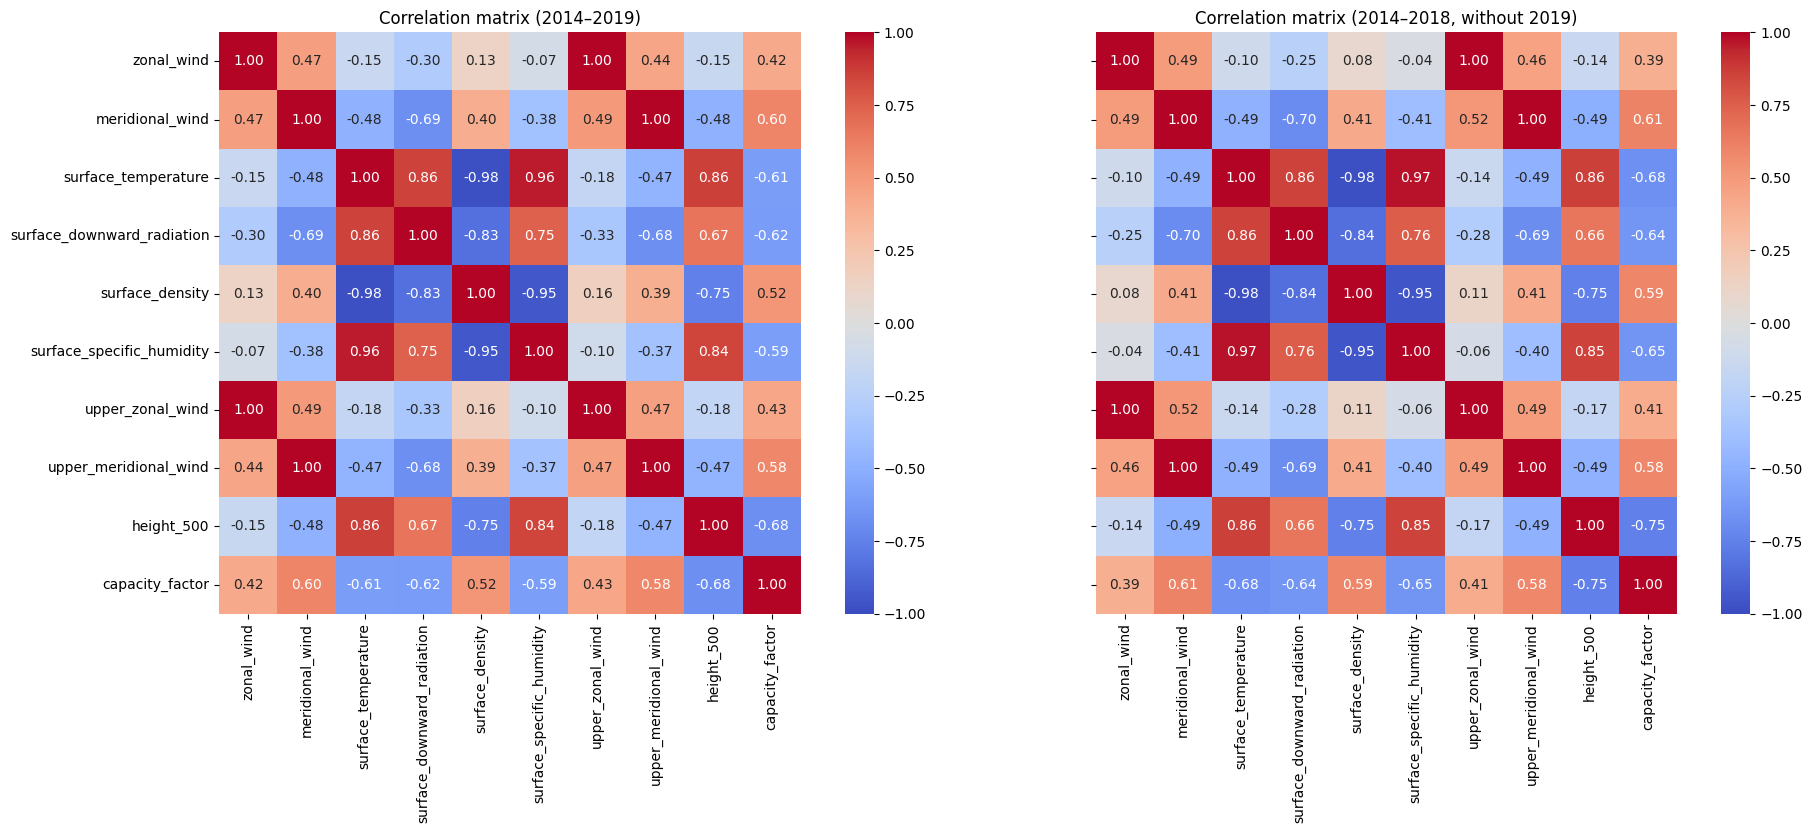

In [ ]:
df_climate_all = df_climate_monthly.loc['2014-01-01':'2019-12-01']
cf_all = df_energy['Île-de-France'].loc['2014-01-01':'2019-12-01']
cf_all = cf_all.rename('capacity_factor')

df_dataset_all = df_climate_all.join(cf_all, how='inner')
corr_all = df_dataset_all.corr()
df_climate_no2019 = df_climate_monthly.loc['2014-01-01':'2018-12-01']
cf_no2019 = df_energy['Île-de-France'].loc['2014-01-01':'2018-12-01']
cf_no2019 = cf_no2019.rename('capacity_factor')

df_dataset_no2019 = df_climate_no2019.join(cf_no2019, how='inner')
corr_no2019 = df_dataset_no2019.corr()

fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

sns.heatmap(
    corr_all,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    vmin=-1,
    vmax=1,
    ax=axes[0]
)
axes[0].set_title("Correlation matrix (2014–2019)")

sns.heatmap(
    corr_no2019,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    vmin=-1,
    vmax=1,
    ax=axes[1]
)
axes[1].set_title("Correlation matrix (2014–2018)")

plt.tight_layout()
plt.show()


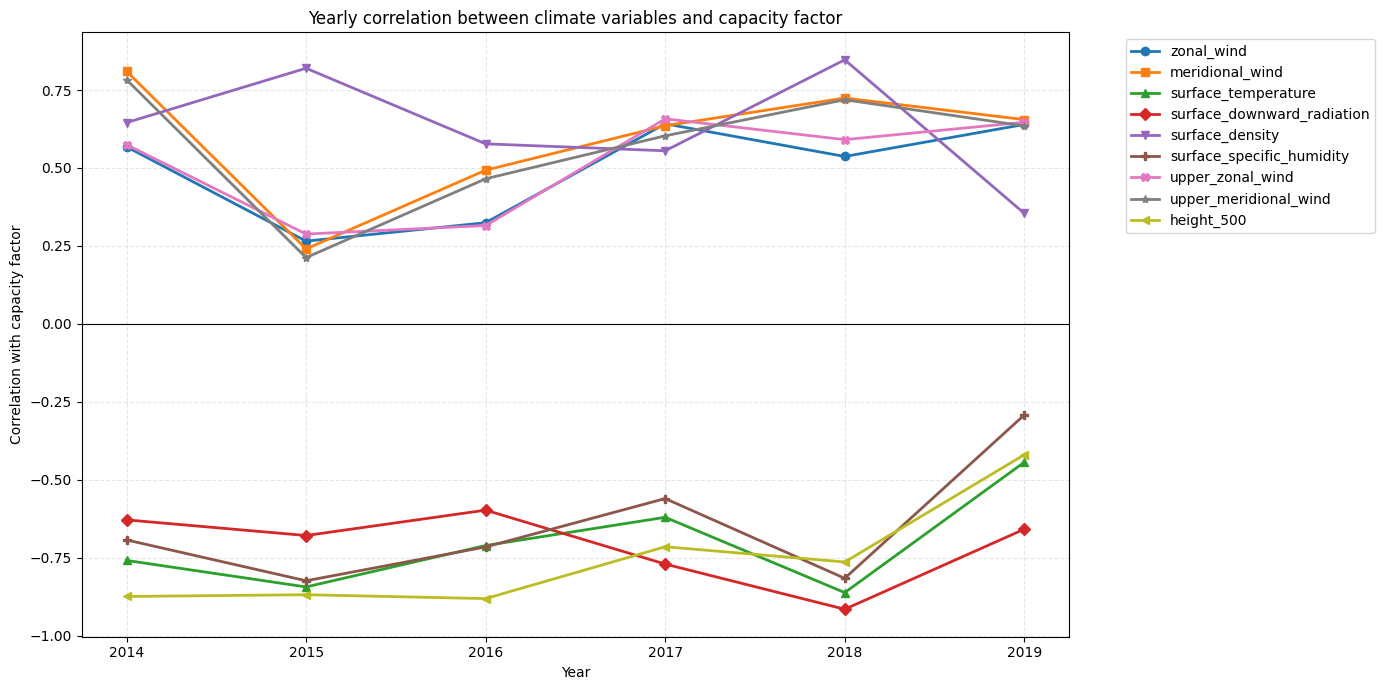

In [105]:
# Complete dataset (2014–2019)
df = df_dataset.sort_index().copy()

# Climate variables
climate_vars = df.columns.drop("capacity_factor")

# Years
years = df.index.year.unique()

# DataFrame to store correlations
corr_by_year = pd.DataFrame(index=years, columns=climate_vars, dtype=float)

# Calculate year-by-year correlations
for year in years:
    df_year = df.loc[str(year)]
    for var in climate_vars:
        corr_by_year.loc[year, var] = df_year[var].corr(df_year["capacity_factor"])

# --- styles ---
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'D', 'v', 'P', 'X', '*', '<', '>']

style_cycle = itertools.product(line_styles, markers)

# Plot
plt.figure(figsize=(14, 7))

for var, (ls, mk) in zip(climate_vars, style_cycle):
    plt.plot(
        corr_by_year.index,
        corr_by_year[var],
        linestyle=ls,
        marker=mk,
        linewidth=2,
        markersize=6,
        label=var
    )

plt.axhline(0, color='black', linewidth=0.8)
plt.xlabel("Year")
plt.ylabel("Correlation with capacity factor")
plt.title("Yearly correlation between climate variables and capacity factor")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

The correlation analysis indicates that none of the climate variables exhibits a weak linear relationship with the wind energy capacity factor. Several predictors show moderate to strong correlations, particularly wind-related variables and the geopotential height at 500 hPa, emphasizing the influence of large-scale atmospheric circulation on wind power generation. Moreover, the values in the last column reveal that the least linearly correlated variable still presents a correlation coefficient of 0.42, which does not characterize a weak correlation.

### 1.6. Data viewing

##### 1.6.1 All time

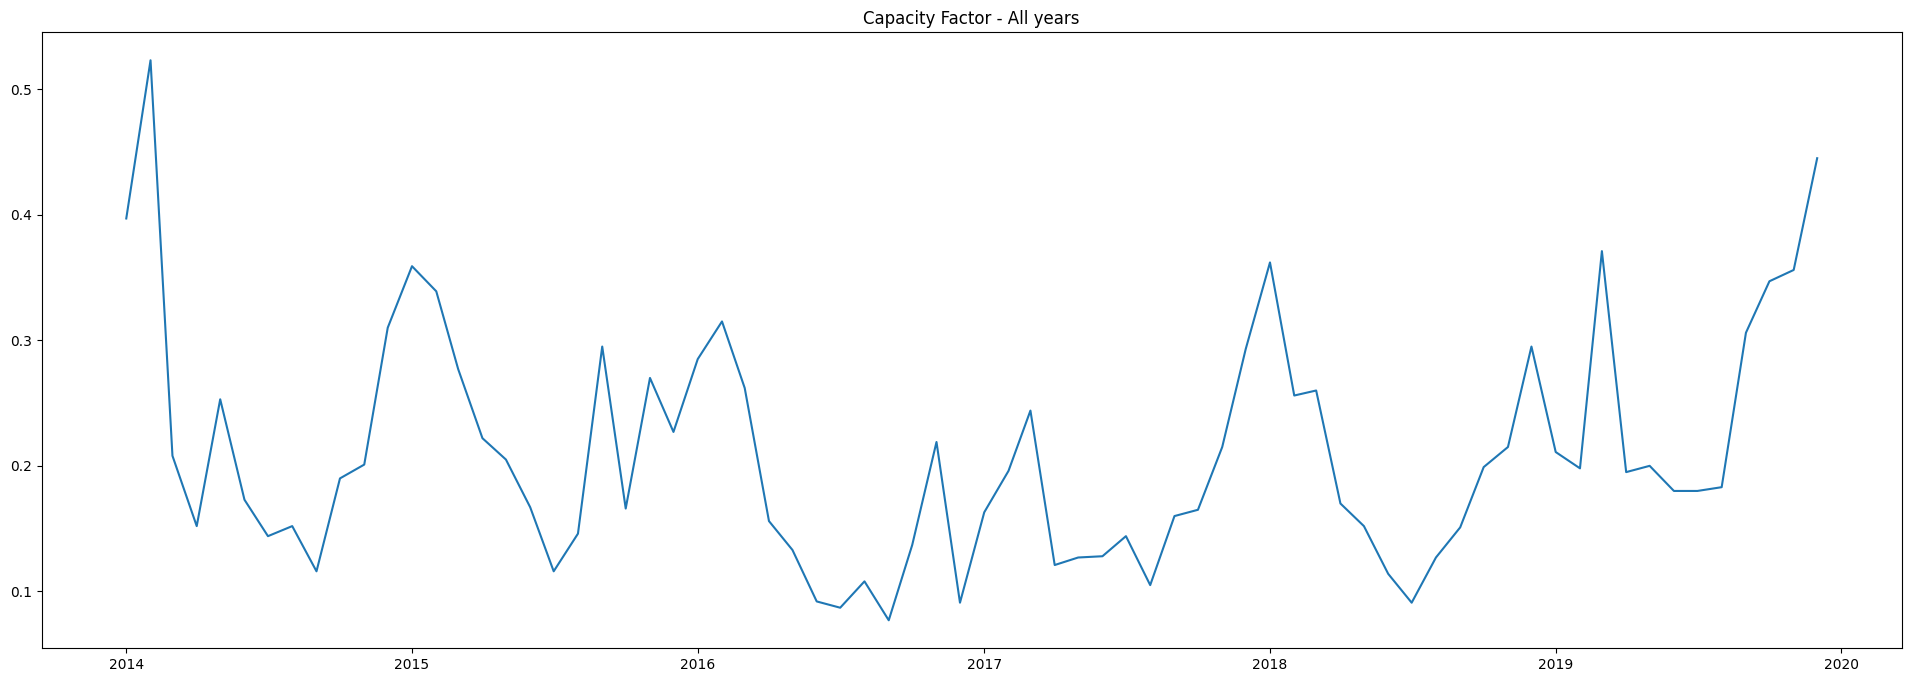

In [106]:
plt.figure(figsize=(24,8))
plt.plot(cf_overlap)
plt.title("Capacity Factor - All years")
plt.show()

The observed seasonal cycle, with higher capacity factors in winter and lower values in summer, is consistent with stronger synoptic-scale wind systems during colder months in Western Europe.

#### 1.6.2 Years superposed

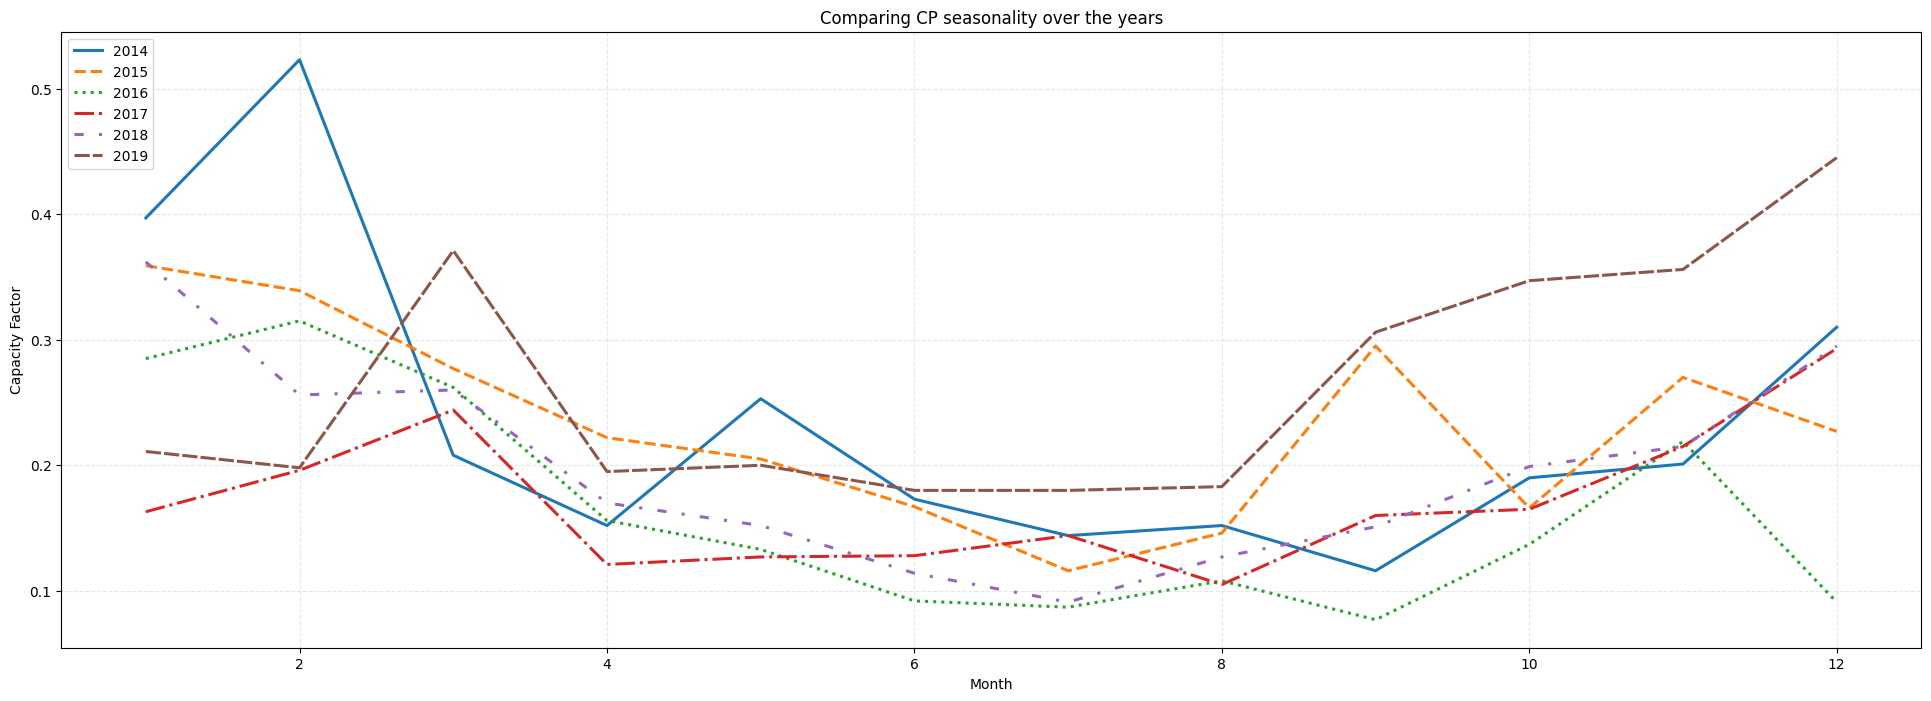

In [107]:
plt.figure(figsize=(24,8))

line_styles = [
    '-',       
    '--',      
    ':',     
    '-.',     
    (0, (3, 5, 1, 5)), 
    (0, (5, 1))         
]

years = cf_overlap.index.year.unique()

for i, year in enumerate(years):
    serie = cf_overlap[str(year)]
    ls = line_styles[i % len(line_styles)]   
    
    plt.plot(
        serie.index.month,
        serie.values,
        label=str(year),
        linestyle=ls,
        linewidth=2.2
    )

plt.legend()
plt.xlabel("Month")
plt.ylabel("Capacity Factor")
plt.title("Comparing CP seasonality over the years")
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()


Our dataset comprises six years of monthly data, as illustrated above. A clear seasonal pattern can be identified, with higher capacity factor values during winter and lower values in summer. However, some deviations from this general behavior are also observed. For instance, in 2014, a pronounced peak occurred in February, followed by a smaller increase in May. More notably, in 2019, an unexpected peak was observed in March, a relatively stable period extended from April to August, and a significant increase occurred toward the end of the year.

The dataset does not satisfy the i.i.d. assumption. Observations exhibit temporal dependence driven by seasonality, and the underlying data distribution changes over time. This non-stationarity is reflected in the poor model generalization to the year 2019, which behaves as an out-of-distribution period.

#### Some climate variables

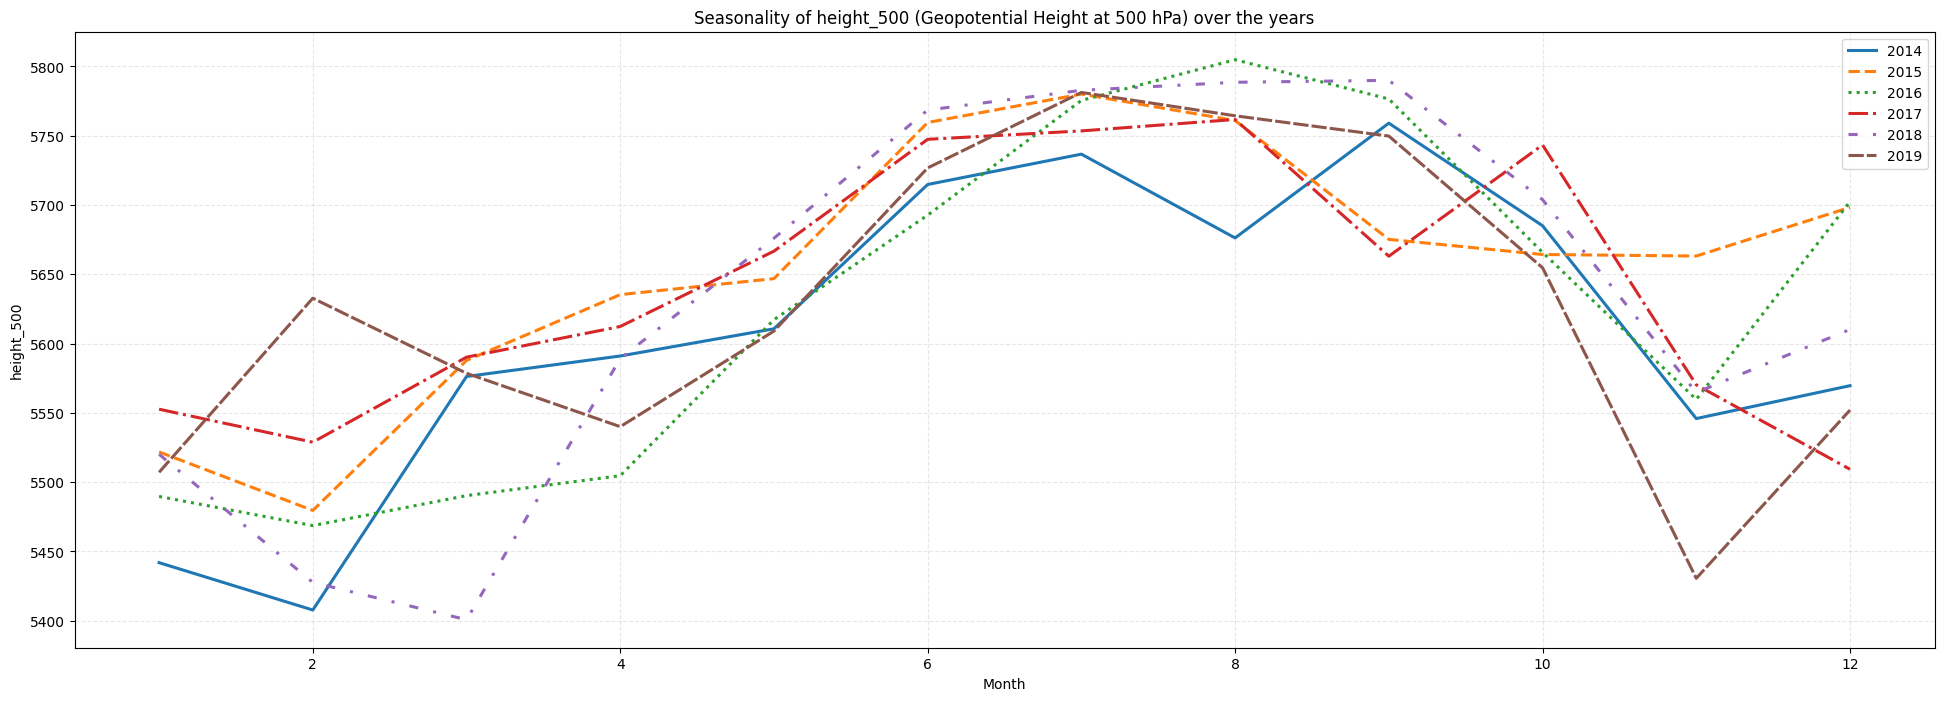

In [108]:
plt.figure(figsize=(24,8))

line_styles = [
    '-',          
    '--',         
    ':',          
    '-.',         
    (0, (3, 5, 1, 5)),  
    (0, (5, 1))         
]


years = df_climate_overlap.index.year.unique()

for i, year in enumerate(years):
    serie = df_climate_overlap['height_500'].loc[str(year)]
    ls = line_styles[i % len(line_styles)]
    
    plt.plot(
        serie.index.month,
        serie.values,
        label=str(year),
        linestyle=ls,
        linewidth=2.2
    )

plt.legend()
plt.xlabel("Month")
plt.ylabel("height_500")
plt.title("Seasonality of height_500 (Geopotential Height at 500 hPa) over the years")
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()


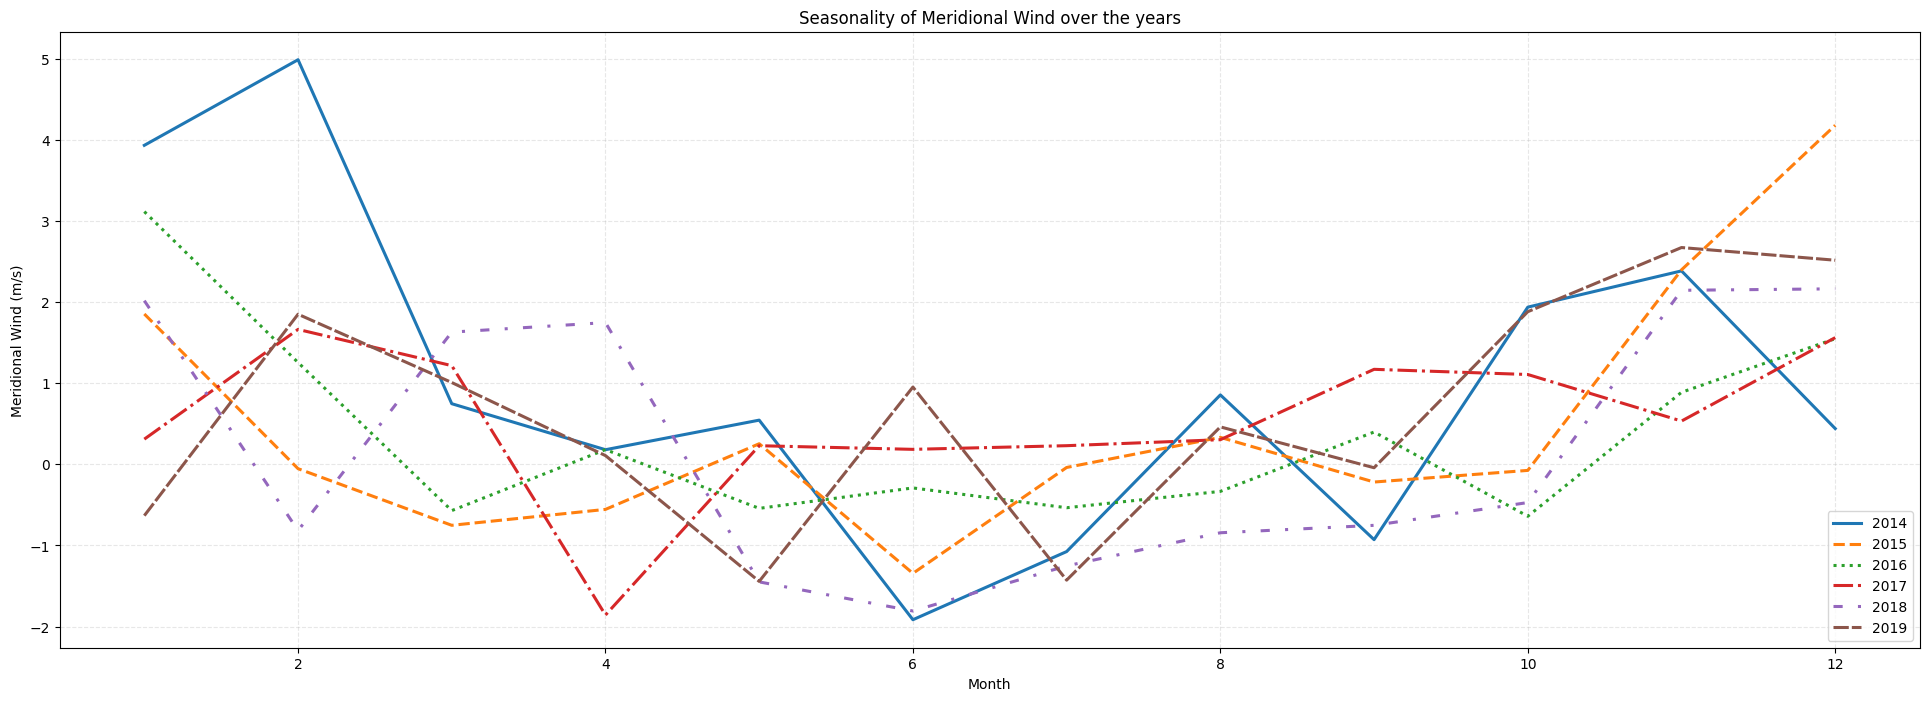

In [109]:
plt.figure(figsize=(24,8))

line_styles = [
    '-',          
    '--',         
    ':',          
    '-.',         
    (0, (3, 5, 1, 5)),  
    (0, (5, 1))         
]

years = df_climate_overlap.index.year.unique()

for i, year in enumerate(years):
    serie = df_climate_overlap['meridional_wind'].loc[str(year)]
    ls = line_styles[i % len(line_styles)]
    
    plt.plot(
        serie.index.month,
        serie.values,
        label=str(year),
        linestyle=ls,
        linewidth=2.2
    )

plt.legend()
plt.xlabel("Month")
plt.ylabel("Meridional Wind (m/s)")
plt.title("Seasonality of Meridional Wind over the years")
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()


## 2. Model training

### 2.1. Linear Regression

We consider a linear regression model of the form:

$$
\hat{y} = X\beta + b
$$

where:

* (X) is the matrix of input features
* (y) is the target vector
* $\hat{y}$ is the model prediction
* $\beta$ is the vector of model coefficients, representing the contribution of each feature
* (b) is the intercept term

### 2.2. Loss Functions for Each Model

#### 2.2.1. Ordinary Least Squares (OLS)

OLS minimizes the sum of squared errors:

$$
\min_{\beta} |y - X\beta|_2^2
$$

This corresponds to finding the coefficients that best fit the data.

### 2.3. Linear regression

Assessing the predictive performance of the linear regression model using more recent data for validation.

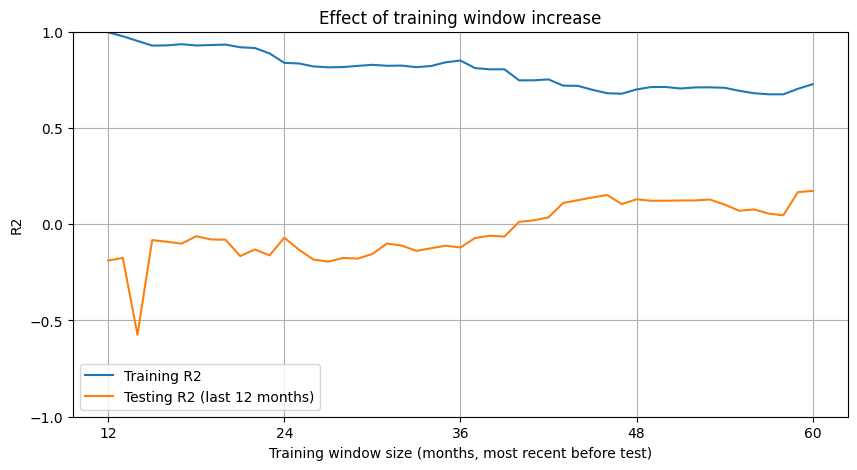

In [110]:
df = df_dataset.copy()       
df = df.sort_index()

X_full = df.drop(columns=["capacity_factor"]).values
y_full = df["capacity_factor"].values

n_samples = len(df)
test_size = 12                    # últimos 2 meses como teste
test_start = n_samples - test_size 

n_train_max = test_start         

R2_train = np.zeros(n_train_max + 1)
R2_test  = np.zeros(n_train_max + 1)

for i in range(12, n_train_max + 1):

    train_start = test_start - i
    train_end   = test_start

    X_train_raw = X_full[train_start:train_end, :]
    y_train = y_full[train_start:train_end]

    X_test_raw  = X_full[test_start:, :]
    y_test = y_full[test_start:]

    mean = X_train_raw.mean(axis=0)
    std  = X_train_raw.std(axis=0)

    #std[std == 0] = 1e-8

    X_train = (X_train_raw - mean) / std
    X_test  = (X_test_raw  - mean) / std

    model = LinearRegression().fit(X_train, y_train)

    R2_train[i] = model.score(X_train, y_train)
    R2_test[i]  = model.score(X_test, y_test)


train_sizes = np.arange(12, n_train_max + 1)

plt.figure(figsize=(10,5))
plt.plot(train_sizes, R2_train[12:], label='Training R2')
plt.plot(train_sizes, R2_test[12:], label='Testing R2 (last 12 months)')
plt.xlabel('Training window size (months, most recent before test)')
plt.ylabel('R2')
plt.xticks([12, 24, 36, 48, 60])
plt.yticks([-1, -0.5, 0, 0.5, 1])
plt.ylim(-1, 1)
plt.title('Effect of training window increase')
plt.legend()
plt.grid()
plt.show()

The results show that while the linear model fits the training data reasonably well, its performance on the test set remains limited. This indicates that a purely linear relationship may not fully capture the complexity of wind energy generation, or that the available predictors are insufficient.

In [111]:
def plot_linear_model_with_test_window(df_in, test_size):
    """
    Train a linear regression model using all data except the last `test_size` samples,
    and plot observed vs predicted capacity factor with a fixed test window.
    
    Parameters
    ----------
    df_in : pandas.DataFrame
        Dataset containing climate variables and 'capacity_factor'
    test_size : int
        Number of samples (months) used as test window
    """

    df = df_in.sort_index().copy()

    X_full = df.drop(columns=["capacity_factor"]).values
    y_full = df["capacity_factor"].values
    time_index = df.index

    n_samples = len(df)
    n_train = n_samples - test_size

    # --- split ---
    X_train_raw = X_full[:n_train, :]
    y_train = y_full[:n_train]

    X_test_raw  = X_full[n_train:, :]
    y_test = y_full[n_train:]

    # --- normalization (train only) ---
    mean = X_train_raw.mean(axis=0)
    std  = X_train_raw.std(axis=0)
    std[std == 0] = 1e-8

    X_train = (X_train_raw - mean) / std
    X_test  = (X_test_raw  - mean) / std

    # --- model ---
    model = LinearRegression().fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_test  = model.predict(X_test)

    # --- R² ---
    R2_test = model.score(X_test, y_test)

    # --- plot ---
    plt.figure(figsize=(24,8))

    # observed CP
    plt.plot(time_index[:n_train], y_train, 'k--', label='Observed CP')
    plt.plot(time_index[n_train:], y_test, 'k--')

    # predictions
    plt.plot(
        time_index[:n_train],
        y_pred_train,
        color='C0',
        linestyle='-.',
        label='Model prediction (train)'
    )

    plt.plot(
        time_index[n_train:],
        y_pred_test,
        color='C0',
        linestyle='-',
        label='Model prediction (test)'
    )

    # train / test boundary
    plt.axvline(time_index[n_train-1], color='gray', linestyle=':', alpha=0.7)

    plt.xlabel("Time")
    plt.ylabel("Capacity Factor")
    plt.title(
        f"Capacity factor and linear model prediction "
        f"({n_train} months train, {test_size} months test), "
        f"R² test = {R2_test:.2f}"
    )
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

    return R2_test

#### 2.3.1 Evaluating test periods of 6 months, 1 year, and 2 years, including the year 2019

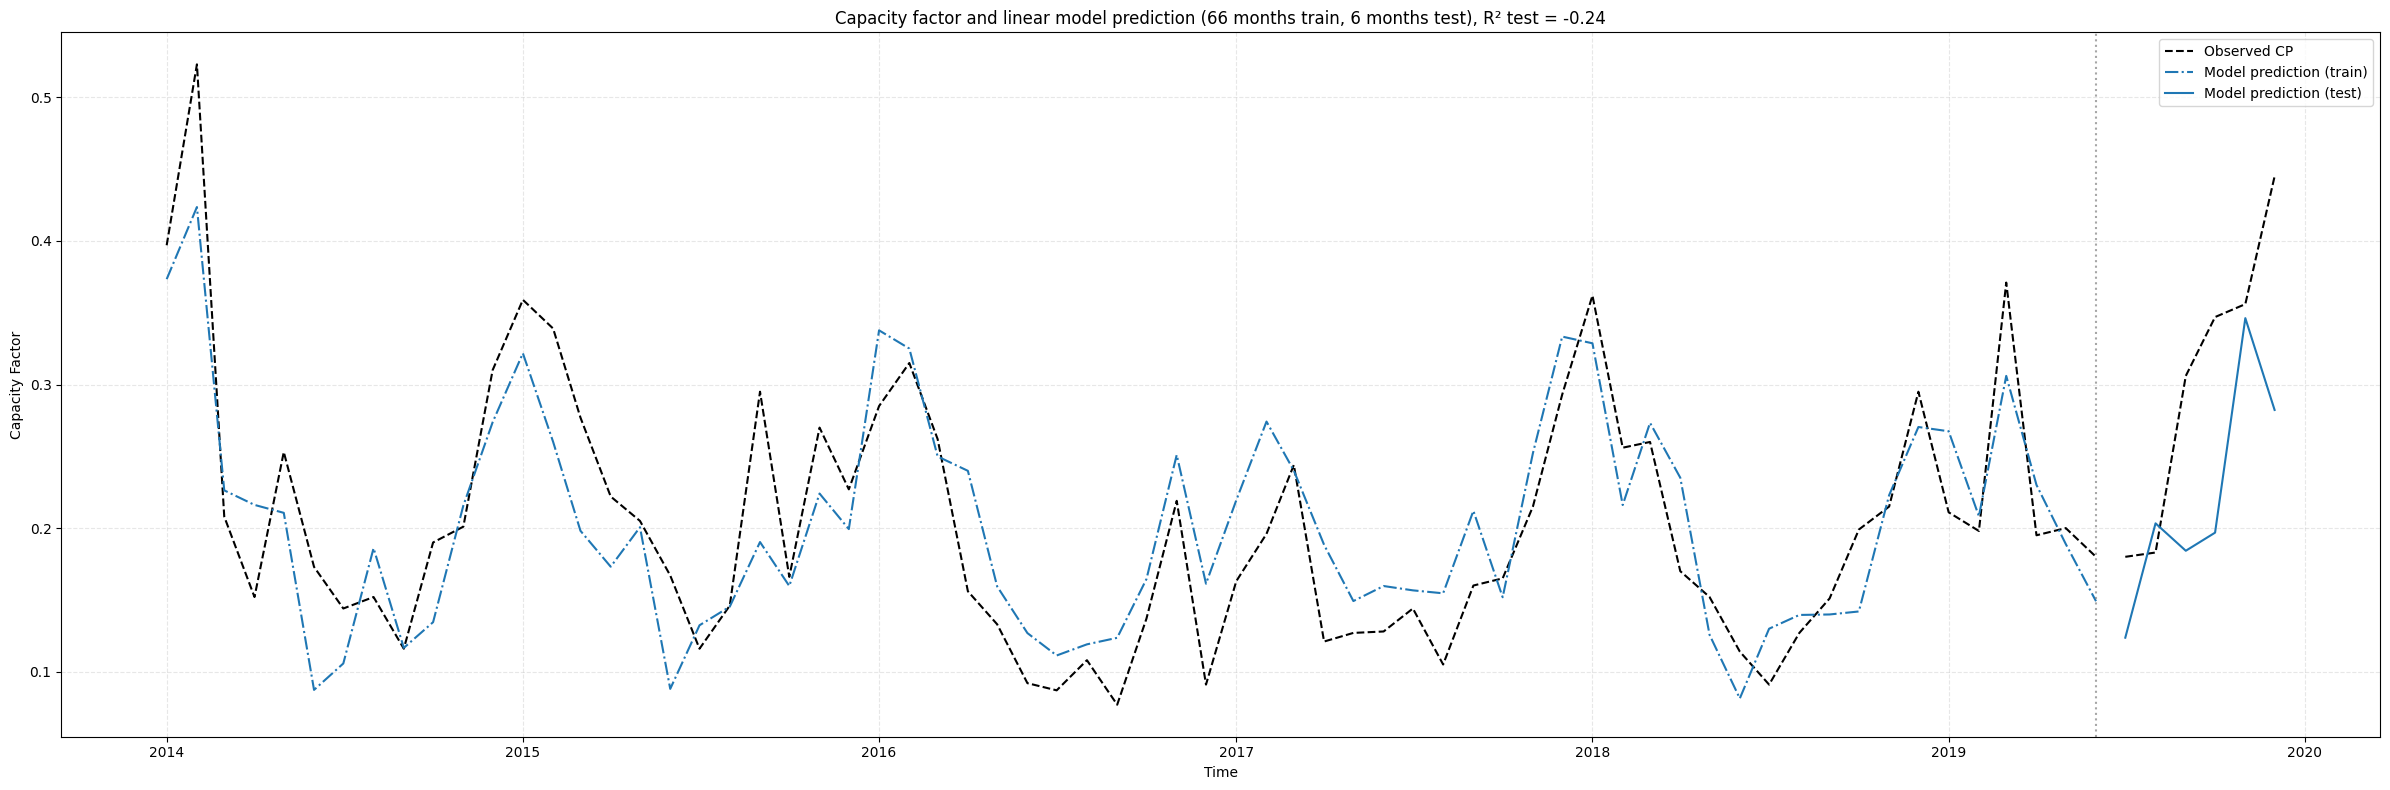

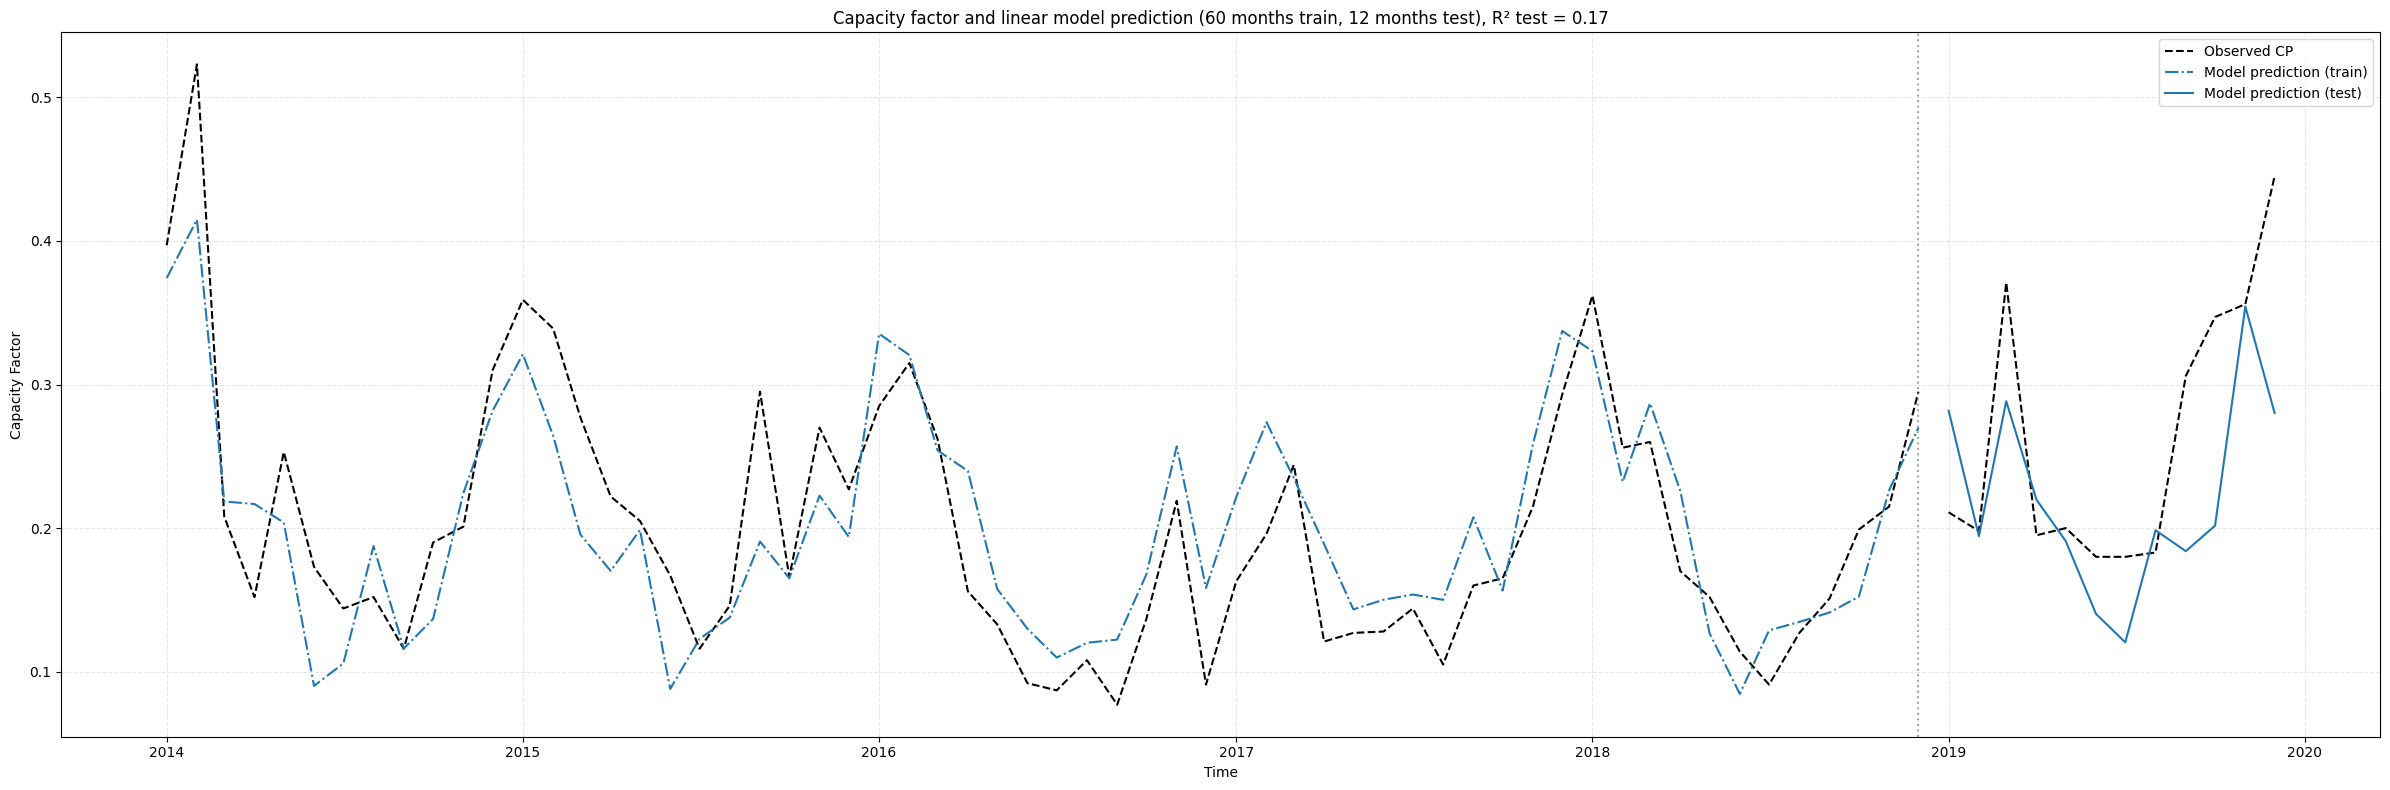

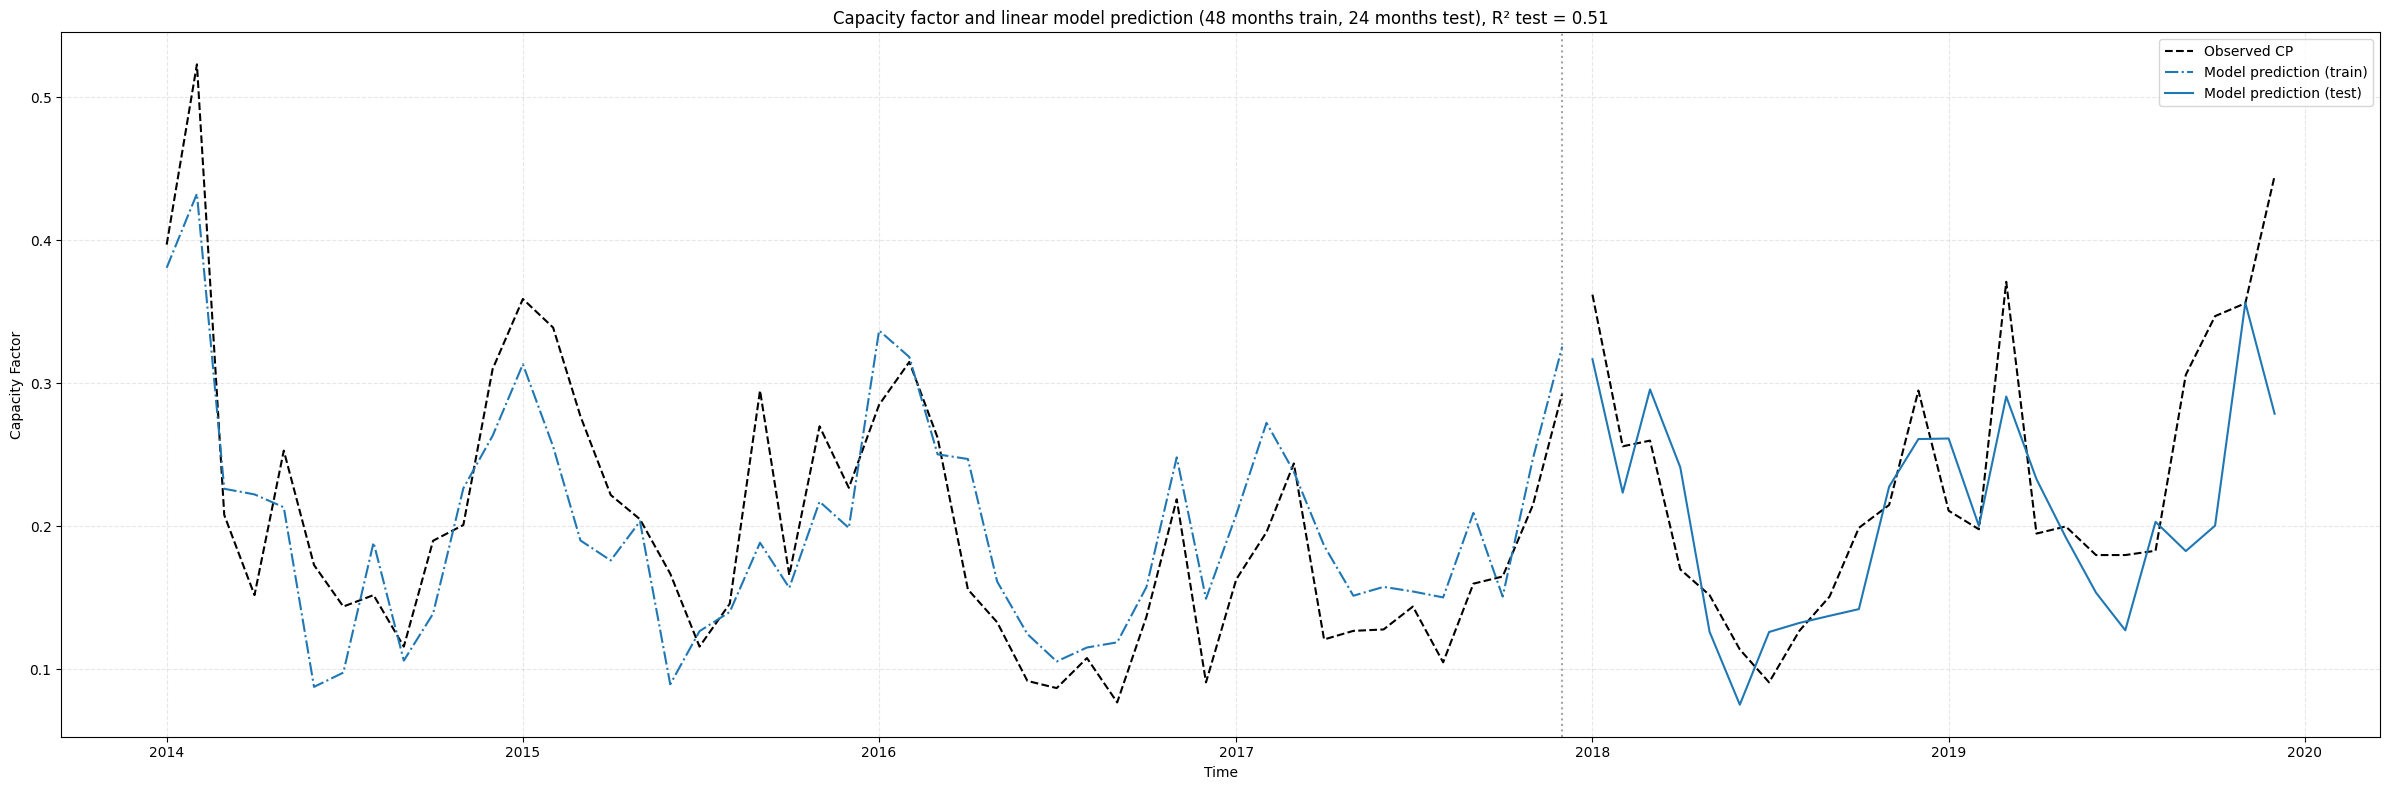

In [112]:
R2_6 = plot_linear_model_with_test_window(df_dataset, test_size=6)
R2_12 = plot_linear_model_with_test_window(df_dataset, test_size=12)
R2_24 = plot_linear_model_with_test_window(df_dataset, test_size=24)

We observe an increase in the R² value as the test window expands. However, this does not necessarily indicate an improvement in model performance. Rather, it reflects the fact that the model predicts periods prior to 2019 more accurately than it predicts the year 2019 itself.

#### 2.3.2 Evaluating model performance without including 2019 in the test set

In [113]:
df_no2019 = df_dataset.sort_index().loc[:'2018-12-01'].copy()
#df_no2019

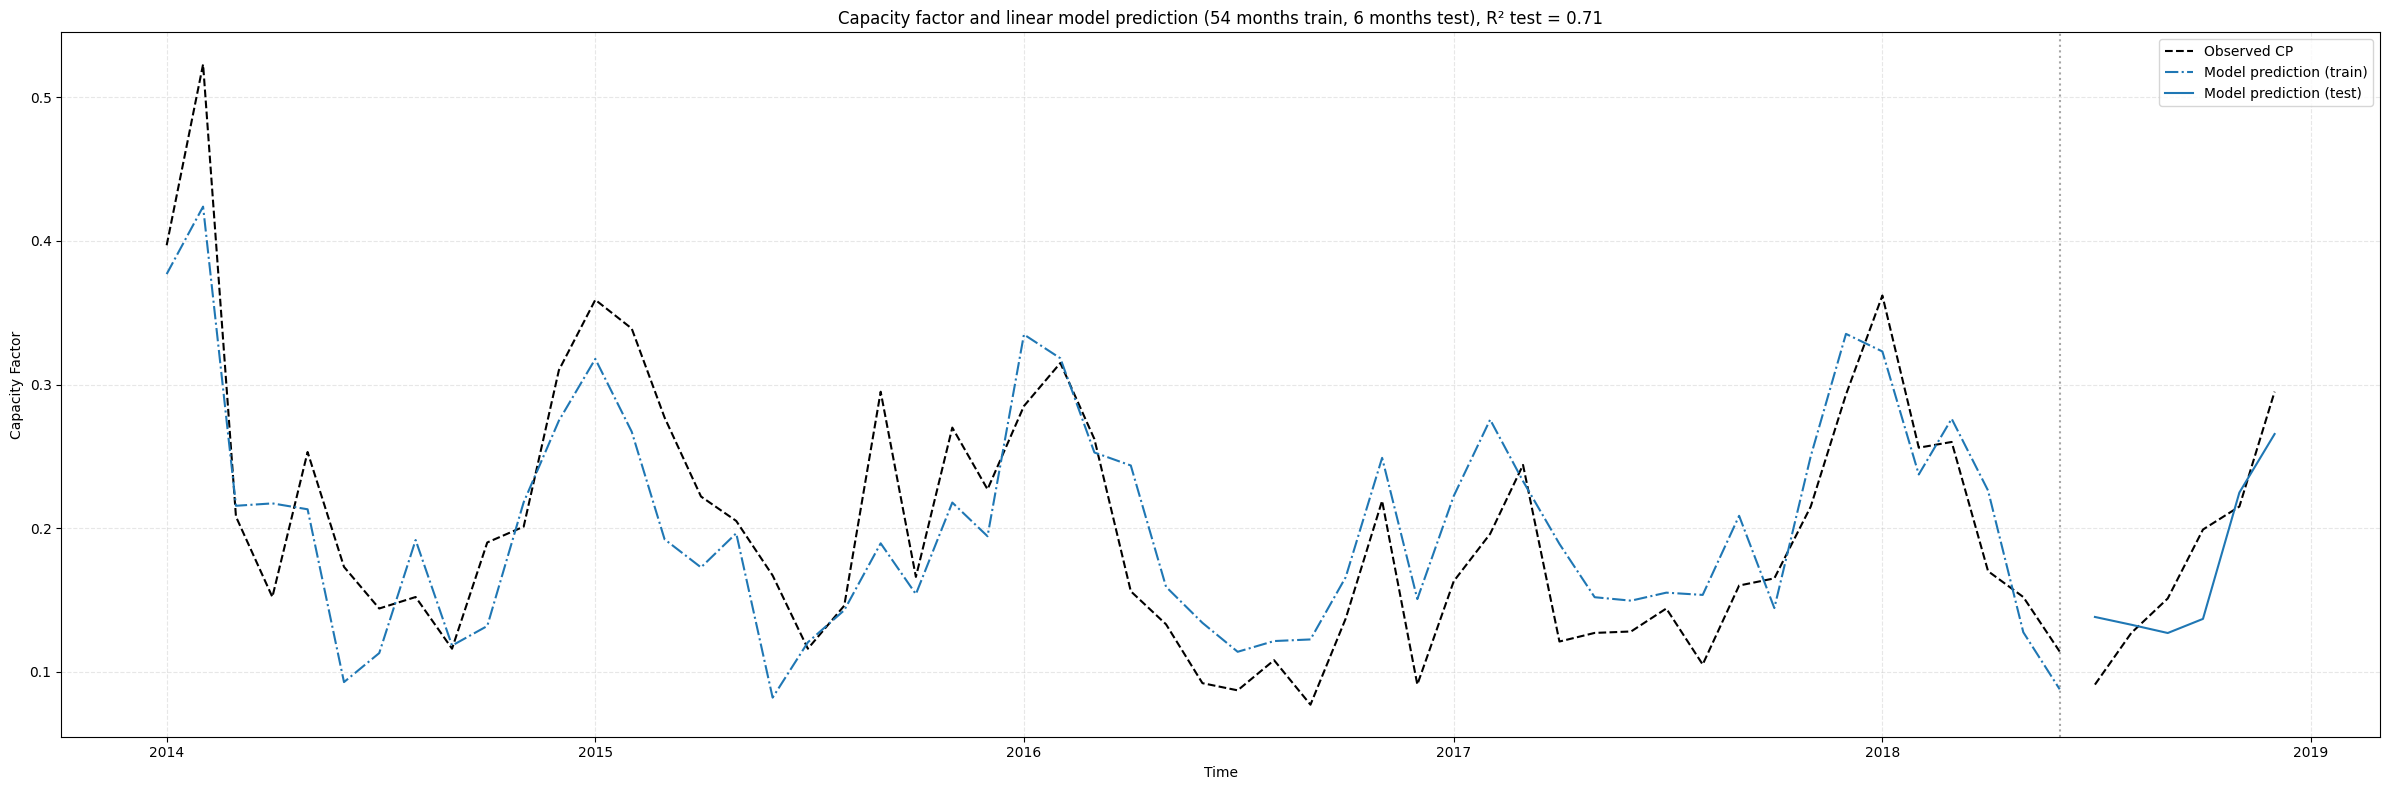

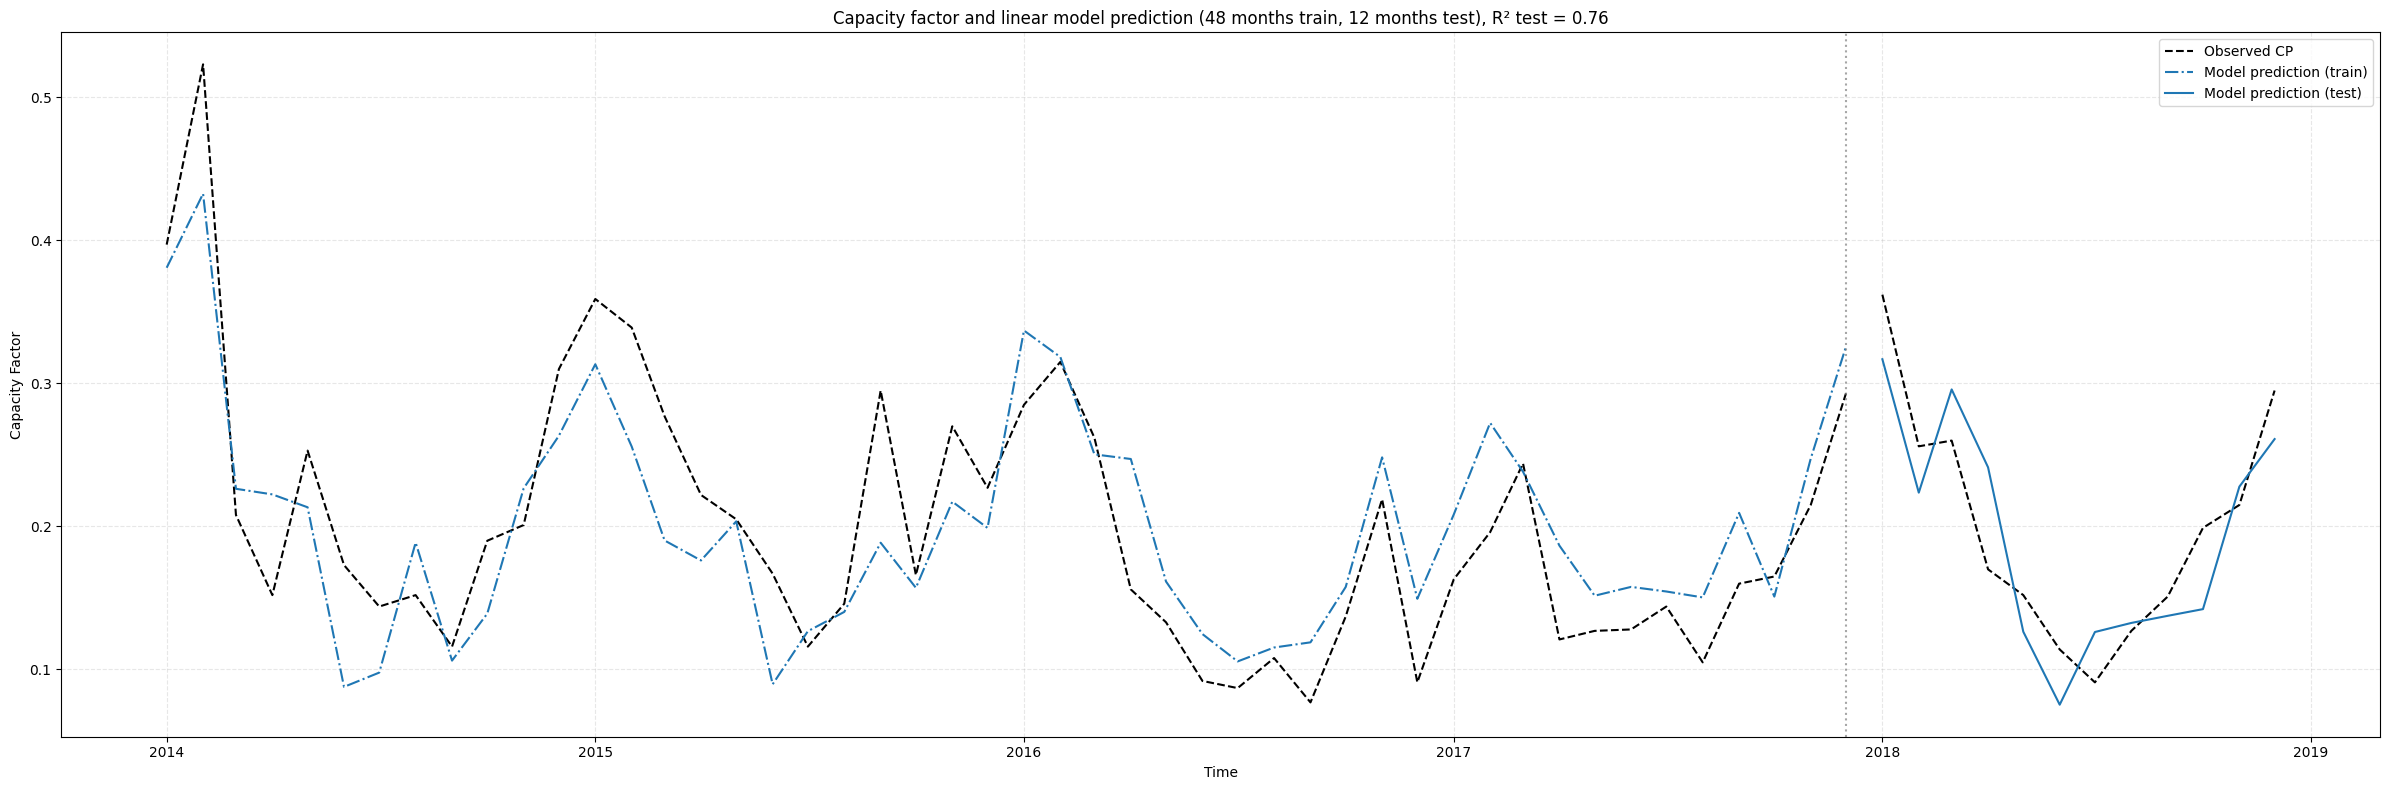

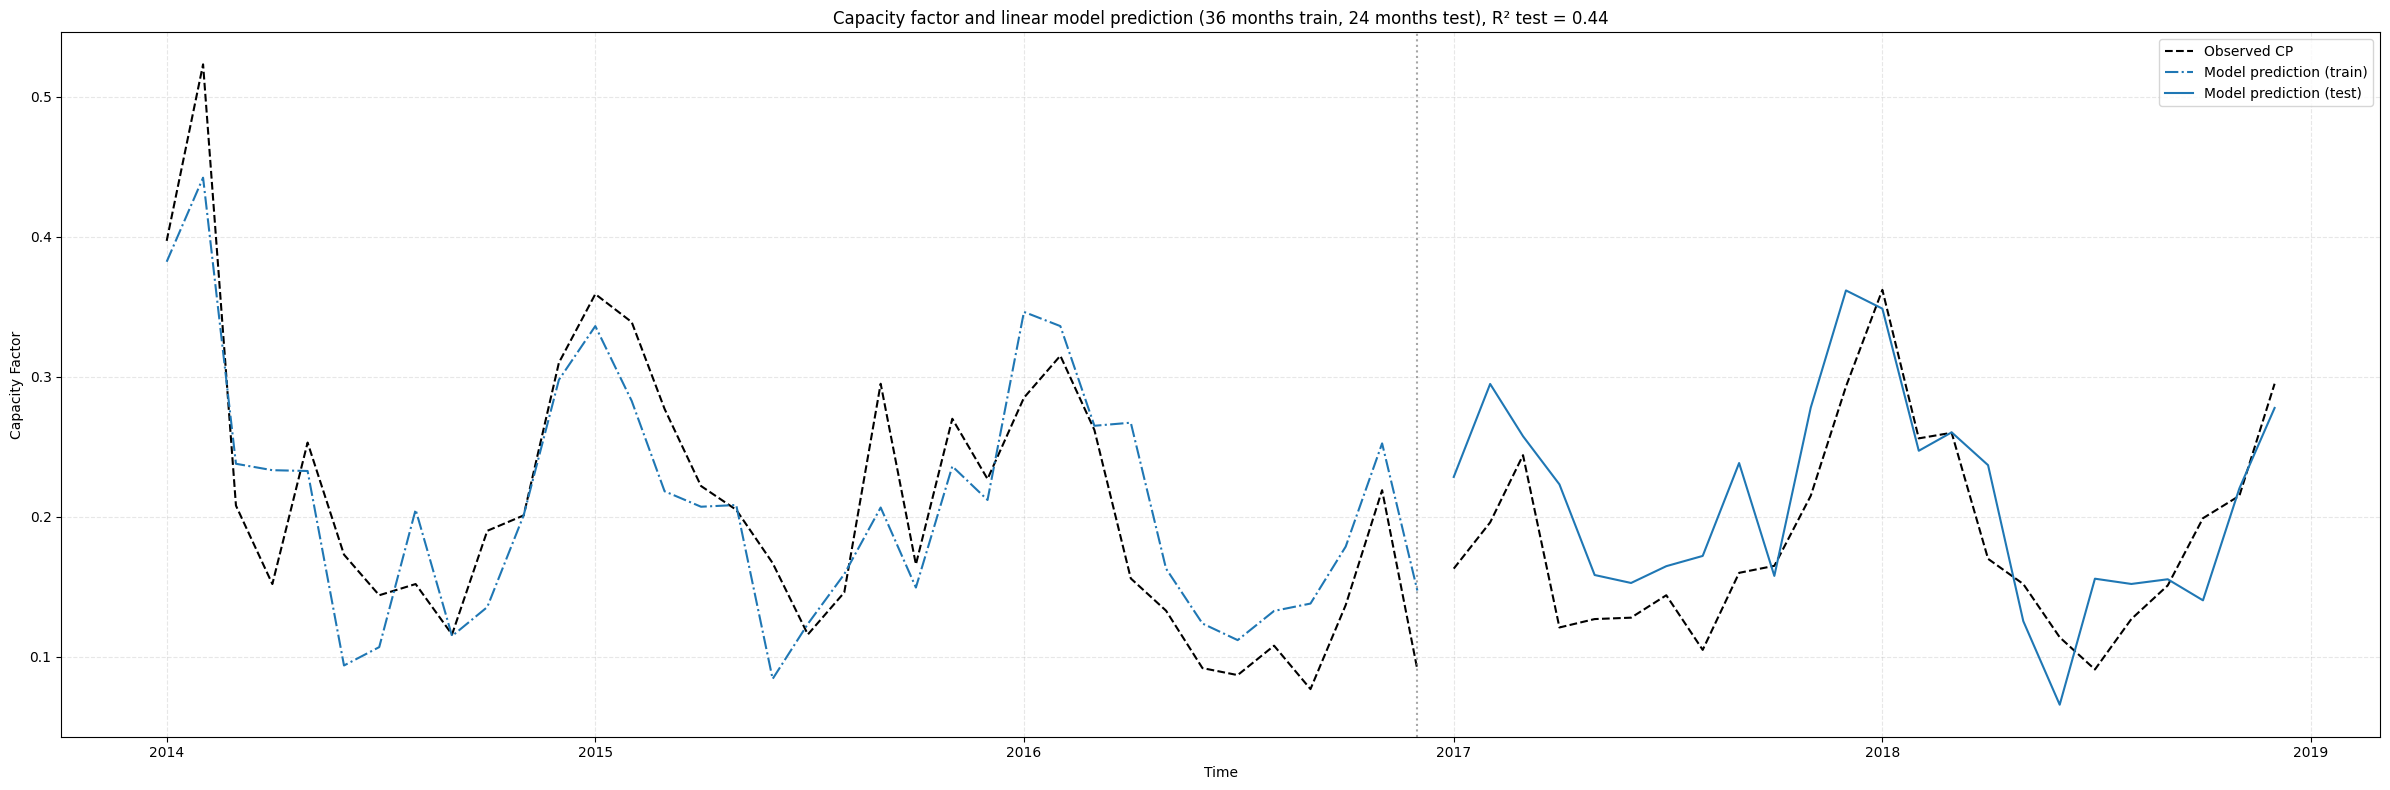

In [114]:
R2_6 = plot_linear_model_with_test_window(df_no2019, test_size=6)
R2_12 = plot_linear_model_with_test_window(df_no2019, test_size=12)
R2_24 = plot_linear_model_with_test_window(df_no2019, test_size=24)

Here, the model exhibits improved performance and more stable behavior, with the decrease in R² being primarily attributable to the shorter training window rather than to distributional shifts.

#### 2.3.3 Training with the last 4 years instead of 5 years

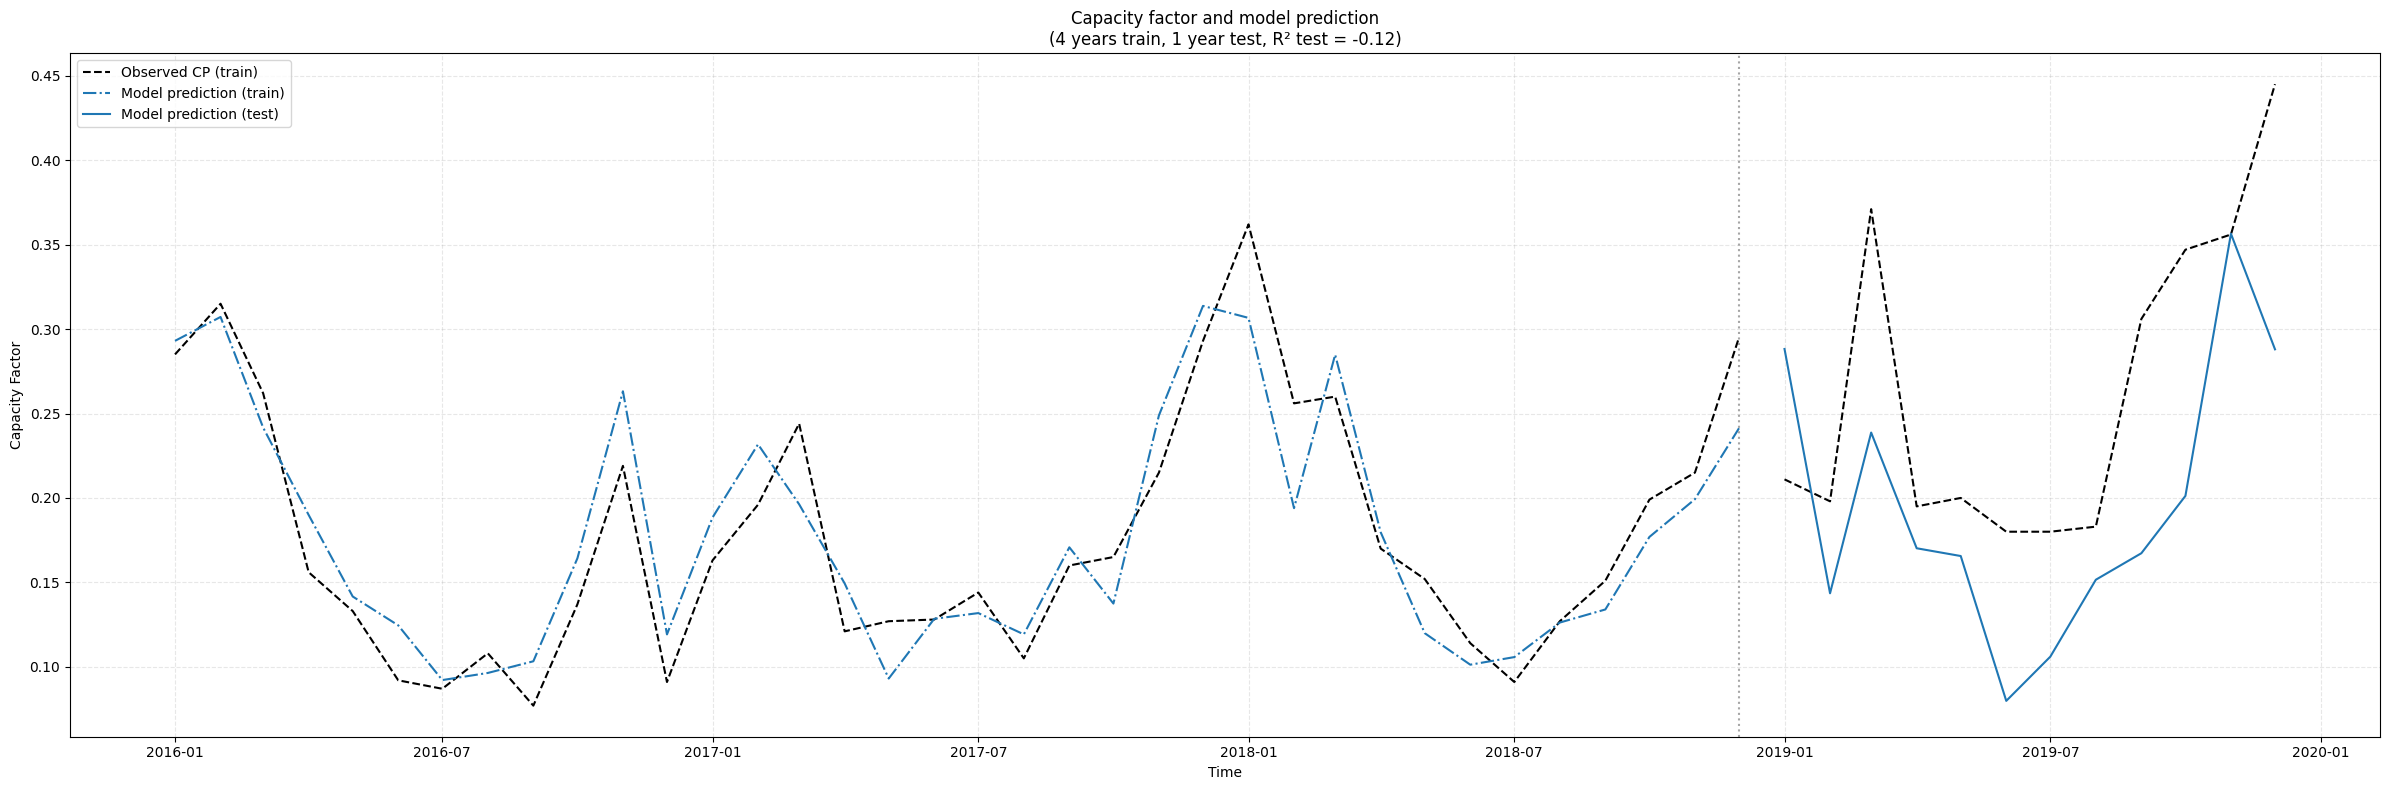

In [115]:
df_sub = df_dataset.sort_index().loc['2016-01-01':].copy()

X_full = df_sub.drop(columns=["capacity_factor"]).values
y_full = df_sub["capacity_factor"].values
time_index = df_sub.index

# 2) 4 years of training, 1 year of testing (total = 5 years = 60 months)
n_months_per_year = 12
n_test  = 1 * n_months_per_year              # 1 year of test = 12 months
n_train = len(df_sub) - n_test               # remaining data is training (60 - 12 = 48 months = 4 years)

X_train_raw = X_full[:n_train, :]
y_train = y_full[:n_train]

X_test_raw  = X_full[n_train:n_train + n_test, :]
y_test = y_full[n_train:n_train + n_test]

# 3) Normalization using statistics from the training set ONLY
mean = X_train_raw.mean(axis=0)
std  = X_train_raw.std(axis=0)
std[std == 0] = 1e-8  # avoid division by zero

X_train = (X_train_raw - mean) / std
X_test  = (X_test_raw  - mean) / std

# 4) Linear regression
model = LinearRegression().fit(X_train, y_train)

# 5) Predictions
y_pred_train = model.predict(X_train)
y_pred_test  = model.predict(X_test)

# 6) Plot
plt.figure(figsize=(24, 8))

# Observed CP in the training period
plt.plot(
    time_index[:n_train],
    y_train,
    'k--',
    label='Observed CP (train)'
)

plt.plot(
    time_index[n_train:],
    y_test,
    'k--',
)

# Model prediction on the training set (blue dash-dot)
plt.plot(
    time_index[:n_train],
    y_pred_train,
    color='C0',
    linestyle='-.',
    label='Model prediction (train)'
)

# Model prediction on the test set (solid blue)
plt.plot(
    time_index[n_train:n_train + n_test],
    y_pred_test,
    color='C0',
    linestyle='-',
    label='Model prediction (test)'
)

# Vertical line separating training and test periods
plt.axvline(time_index[n_train - 1], color='gray', linestyle=':', alpha=0.7)

R2_test = model.score(X_test, y_test)
plt.xlabel("Time")
plt.ylabel("Capacity Factor")
plt.title(
    f"Capacity factor and model prediction\n"
    f"(4 years train, 1 year test, R² test = {R2_test:.2f})"
)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

Given the limited generalization ability of the ordinary least squares model and the presence of correlated predictors, regularization techniques are introduced to mitigate overfitting and improve model robustness. Ridge and Lasso regression allow controlling model complexity while preserving interpretability, making them well-suited for this application.

### 2.4. Ridge Regression (L2 Regularization)

Ridge adds a penalty proportional to the L2 norm of the coefficients:

$$
\min_{\beta} \left( |y - X\beta|_2^2 + \alpha |\beta|_2^2 \right)
$$

where:

* $|\beta|_2 = \left( \sum_j \beta_j^2 \right)^{1/2}$
* $\alpha > 0$ is the regularization strength

The L2 penalty shrinks all coefficients toward zero but never forces any of them to become exactly zero.

### 2.5 Lasso Regression (L1 Regularization)

Lasso adds a penalty proportional to the L1 norm of the coefficients:

$$
\min_{\beta} ; \left( |y - X\beta|_2^2 + \alpha |\beta|_1 \right)
$$

where:

* $|\beta|_1 = \sum_j |\beta_j|$

The L1 penalty encourages sparsity, meaning that Lasso can force some coefficients to become exactly zero, effectively performing feature selection.

### 2.6. Why the Norm Type and α Change Feature Importance

#### 2.6.1 Effect of the Regularization Term

$
\text{Loss} = \underbrace{|y - X\beta|2^2}_{\text{fit to data}} + \underbrace{\alpha \cdot R(\beta)}_{\text{regularization}}
$

where:

* $R(\beta)$ is either the L1 or L2 norm
* α controls how much the regularization term influences the optimization

##### 2.6.2. L2 norm (Ridge)

* Penalizes large values of $\beta_j$
* Encourages coefficients to be small but not zero
* Reduces variance and stabilizes the model under multicollinearity
* Keeps all features in the model but decreases their influence

##### 2.6.3. L1 norm (Lasso)

* Penalizes the absolute value of coefficients
* Has a geometric shape with sharp corners at zero
* These corners encourage coefficients to become exactly zero
* Performs automatic feature selection

##### 2.6.4. Role of α

α scales the strength of the penalty:

* If α = 0, Ridge and Lasso reduce to ordinary least squares
* If α increases:

  * Ridge shrinks coefficients smoothly
  * Lasso forces more coefficients to zero

Thus, the choice of norm and the magnitude of α directly determine the final feature importance by controlling how the model balances accuracy vs. coefficient size.


### 2.7. Regularizations

#### 2.7.1 Ridge Regression

In [116]:
df = df_dataset.sort_index().copy()

X_full = df.drop(columns=["capacity_factor"]).values
y_full = df["capacity_factor"].values
time_index = df.index


test_size = 12
n_samples = len(df)

X_test_final = X_full[-test_size:]
y_test_final = y_full[-test_size:]


X_cv_full = X_full[:-test_size]
y_cv_full = y_full[:-test_size]

def select_alpha_nested_ridge(
    X, y,
    alphas,
    val_size=12,
    min_train_size=24,
    step=12
):


    n = len(y)
    train_ends = range(min_train_size, n - val_size + 1, step)

    r2_mean = []

    for alpha in alphas:
        fold_scores = []

        for train_end in train_ends:
            
            X_train_raw = X[:train_end]
            y_train = y[:train_end]

            X_val_raw = X[train_end:train_end + val_size]
            y_val = y[train_end:train_end + val_size]

           # normalization using training data only
            mean = X_train_raw.mean(axis=0)
            std = X_train_raw.std(axis=0)
            std[std == 0] = 1e-8

            X_train = (X_train_raw - mean) / std
            X_val = (X_val_raw - mean) / std

            model = Ridge(alpha=alpha)
            model.fit(X_train, y_train)

            fold_scores.append(model.score(X_val, y_val))

        r2_mean.append(np.mean(fold_scores))

    r2_mean = np.array(r2_mean)
    best_idx = np.argmax(r2_mean)

    return alphas[best_idx], r2_mean, train_ends


alphas = np.logspace(-3, 5, 60)

best_alpha, r2_mean, train_ends = select_alpha_nested_ridge(
    X_cv_full,
    y_cv_full,
    alphas,
    val_size=12,
    min_train_size=24,
    step=12
)

print("Best alpha (nested CV):", best_alpha)
print("Best mean validation R²:", r2_mean.max())

mean = X_cv_full.mean(axis=0)
std = X_cv_full.std(axis=0)
std[std == 0] = 1e-8

X_train_final = (X_cv_full - mean) / std
X_test_final_norm = (X_test_final - mean) / std

final_model = Ridge(alpha=best_alpha)
final_model.fit(X_train_final, y_cv_full)

R2_test_final = final_model.score(X_test_final_norm, y_test_final)

print("Final test R² (2019):", R2_test_final)

Best alpha (nested CV): 40.75392965871778
Best mean validation R²: 0.2729608366739516
Final test R² (2019): 0.0029875982620685138


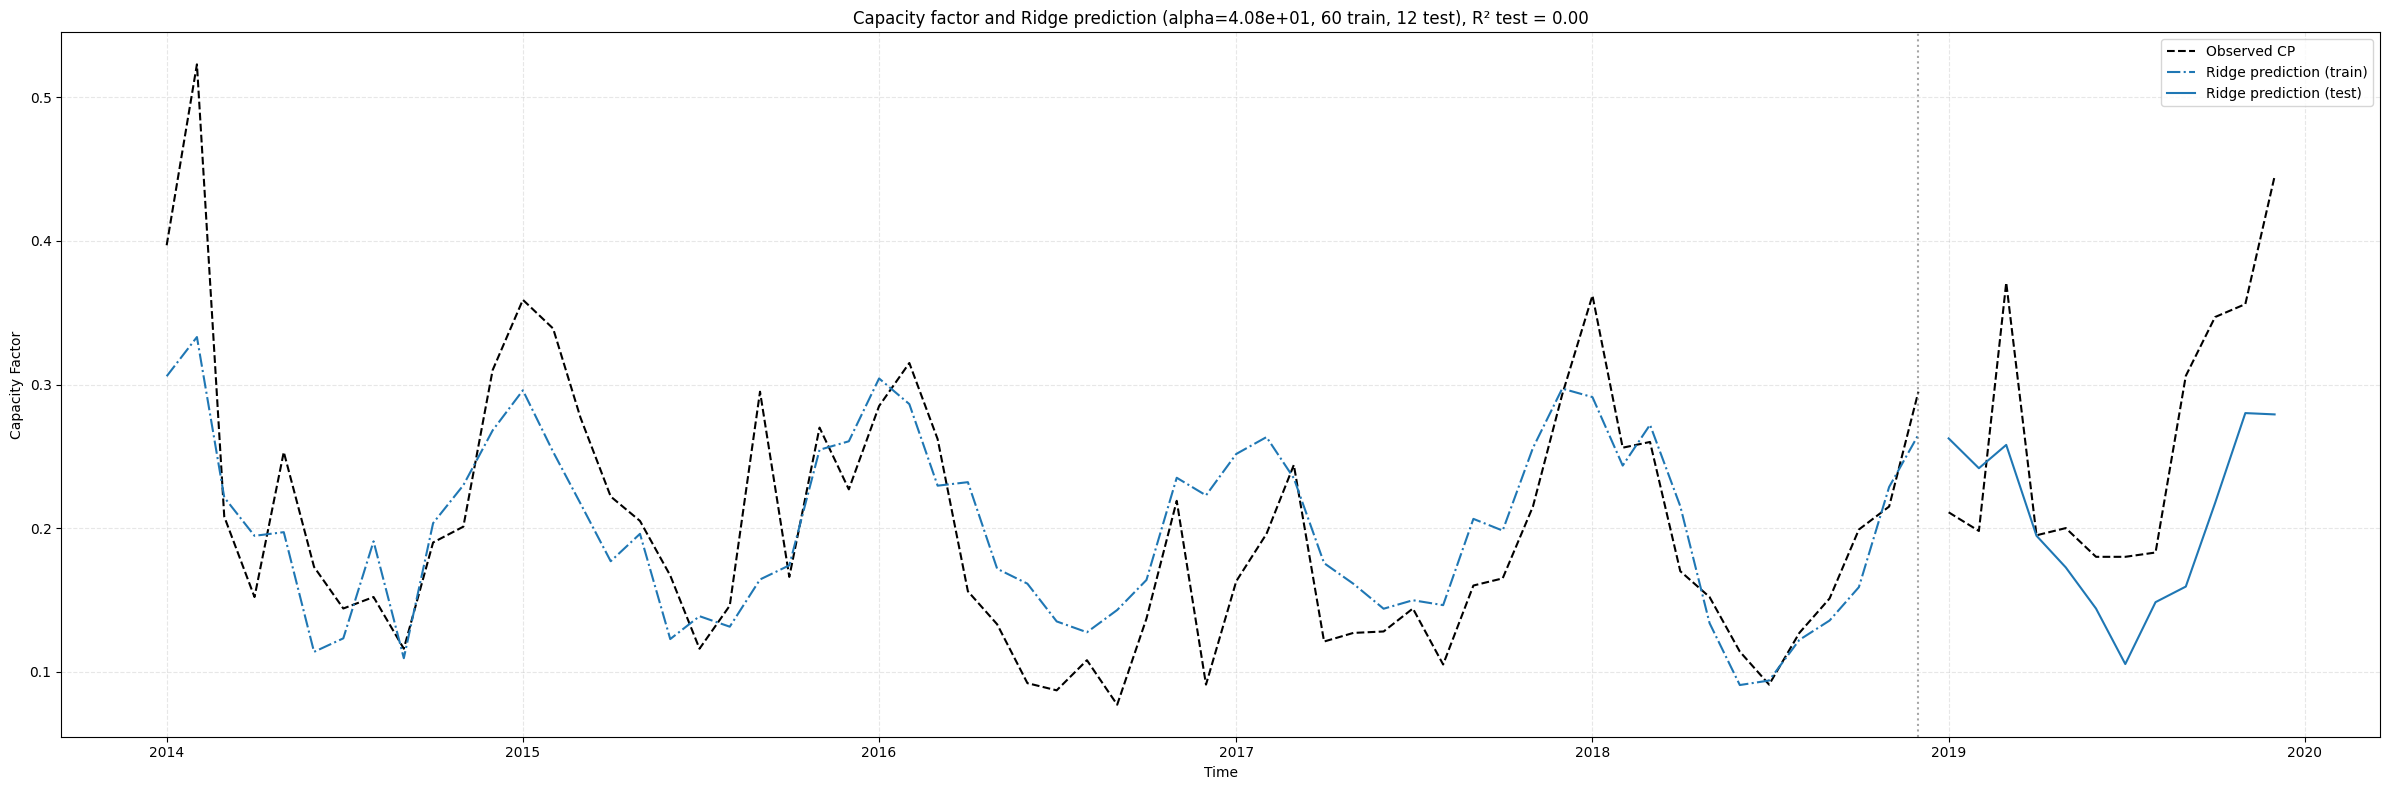

In [117]:
# df_dataset: complete dataset (2014–2019), including capacity_factor
df = df_dataset.sort_index().copy()

X_full = df.drop(columns=["capacity_factor"]).values
y_full = df["capacity_factor"].values
time_index = df.index

# Final test set 
test_size = 12
n_samples = len(df)
n_train = n_samples - test_size

# Final split 
X_train_raw = X_full[:n_train, :]
y_train = y_full[:n_train]
X_test_raw  = X_full[n_train:, :]
y_test = y_full[n_train:]

# Normalization using ONLY the final training set
mean = X_train_raw.mean(axis=0)
std  = X_train_raw.std(axis=0)
std[std == 0] = 1e-8

X_train = (X_train_raw - mean) / std
X_test  = (X_test_raw  - mean) / std

# Ridge regression with selected alpha
ridge = Ridge(alpha=best_alpha)
ridge.fit(X_train, y_train)

# Predictions
y_pred_train = ridge.predict(X_train)
y_pred_test  = ridge.predict(X_test)

# R² on the final test set
R2_test = ridge.score(X_test, y_test)

# Plot using the same style
plt.figure(figsize=(24, 8))

# Observed CP in dashed black
plt.plot(
    time_index[:n_train],
    y_train,
    'k--',
    label='Observed CP'
)
plt.plot(
    time_index[n_train:],
    y_test,
    'k--'
)

# Prediction on the training set 
plt.plot(
    time_index[:n_train],
    y_pred_train,
    color='C0',
    linestyle='-.',
    label='Ridge prediction (train)'
)

# Prediction on the test set
plt.plot(
    time_index[n_train:],
    y_pred_test,
    color='C0',
    linestyle='-',
    label='Ridge prediction (test)'
)

# Train/test boundary
plt.axvline(time_index[n_train - 1], color='gray', linestyle=':', alpha=0.7)

plt.xlabel("Time")
plt.ylabel("Capacity Factor")
plt.title(
    f"Capacity factor and Ridge prediction (alpha={best_alpha:.2e}, "
    f"{n_train} train, {test_size} test), R² test = {R2_test:.2f}"
)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


Best alpha (nested, up to 2018): 40.75392965871778
Best mean validation R²: 0.2729608366739516


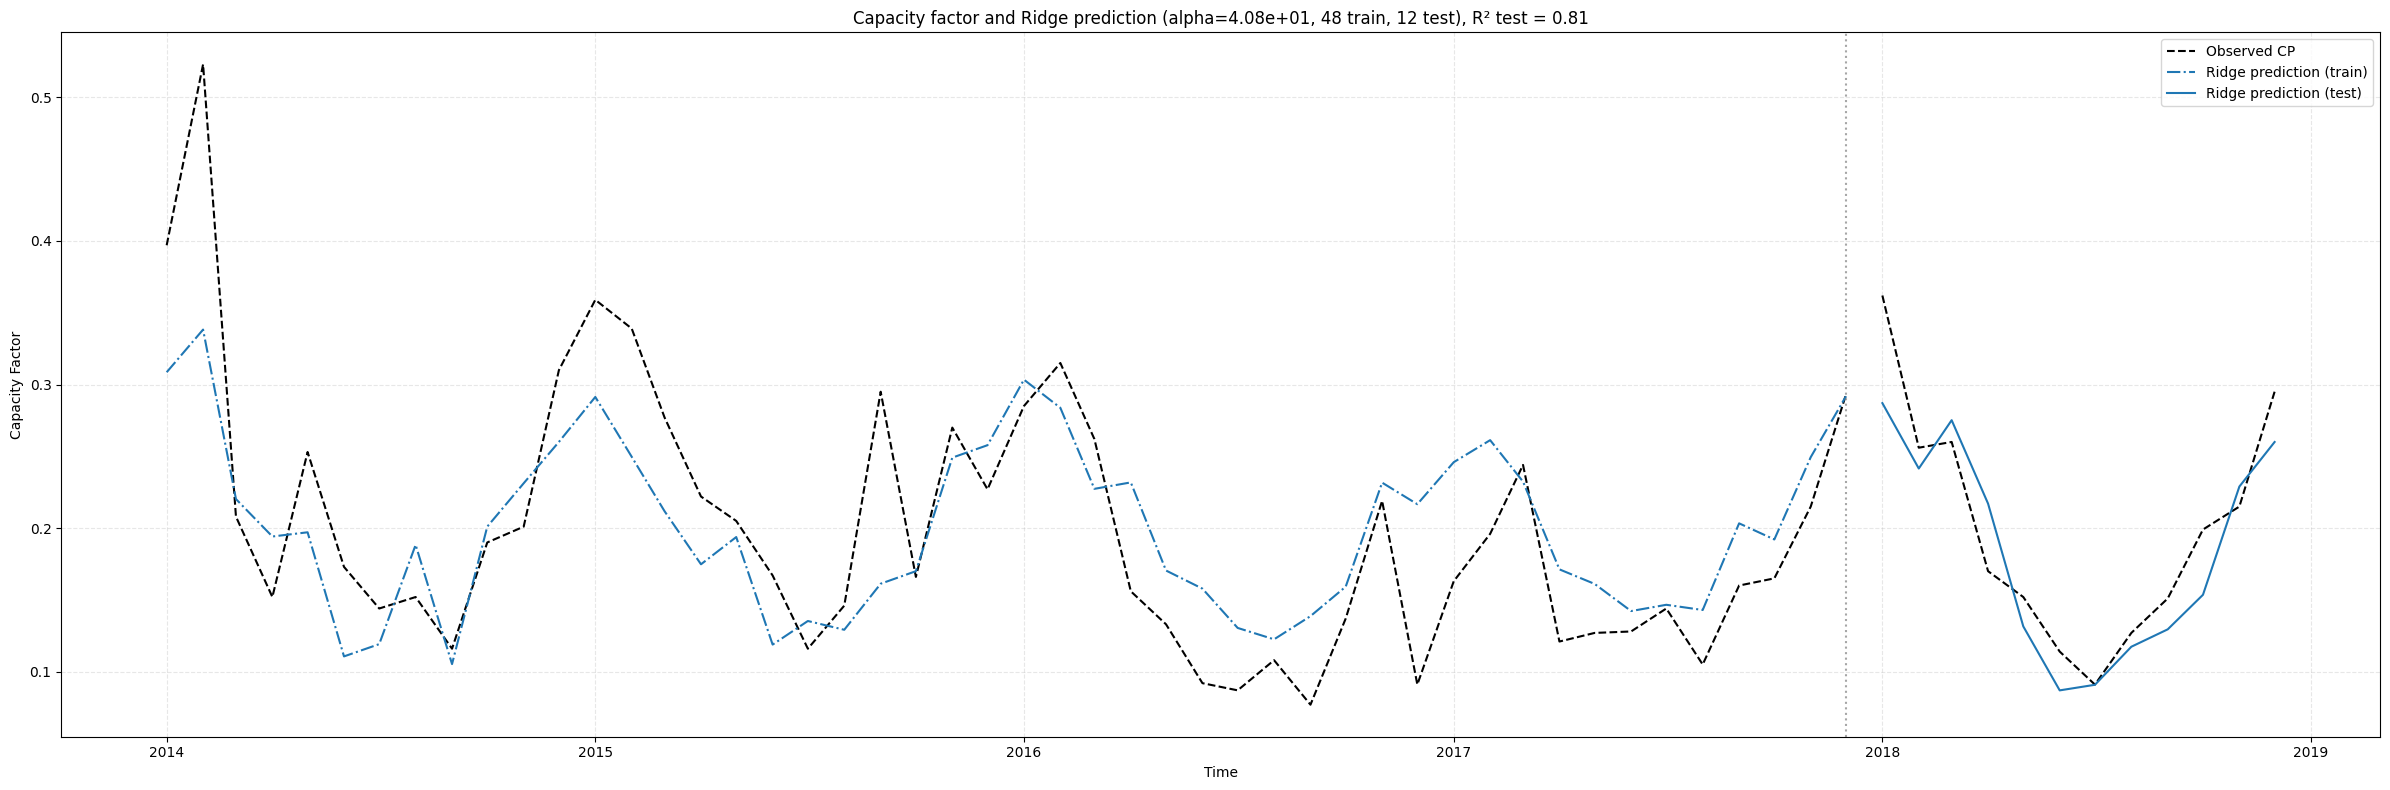

In [118]:
df_2018 = df_dataset.sort_index().loc[:'2018-12-01'].copy()

X_full = df_2018.drop(columns=["capacity_factor"]).values
y_full = df_2018["capacity_factor"].values
time_index = df_2018.index

alphas = np.logspace(-3, 5, 60)

best_alpha_2018, r2_mean_2018, _ = select_alpha_nested_ridge(
    X_full, y_full, alphas,
    val_size=12, min_train_size=24, step=12
)

print("Best alpha (nested, up to 2018):", best_alpha_2018)
print("Best mean validation R²:", r2_mean_2018.max())

# Last year (2018) used as test set
test_size = 12
n_samples = len(df_2018)
n_train = n_samples - test_size

X_train_raw = X_full[:n_train, :]
y_train = y_full[:n_train]

X_test_raw  = X_full[n_train:, :]
y_test = y_full[n_train:]

# Normalization using training data only
mean = X_train_raw.mean(axis=0)
std  = X_train_raw.std(axis=0)
std[std == 0] = 1e-8

X_train = (X_train_raw - mean) / std
X_test  = (X_test_raw  - mean) / std

# Ridge regression with selected alpha
ridge = Ridge(alpha=best_alpha_2018)
ridge.fit(X_train, y_train)

y_pred_train = ridge.predict(X_train)
y_pred_test  = ridge.predict(X_test)

R2_test = ridge.score(X_test, y_test)

# Plot 
plt.figure(figsize=(24, 8))

# Observed values 
plt.plot(time_index[:n_train], y_train, 'k--', label='Observed CP')
plt.plot(time_index[n_train:], y_test, 'k--')

# Training prediction 
plt.plot(
    time_index[:n_train],
    y_pred_train,
    color='C0',
    linestyle='-.',
    label='Ridge prediction (train)'
)

# Test prediction
plt.plot(
    time_index[n_train:],
    y_pred_test,
    color='C0',
    linestyle='-',
    label='Ridge prediction (test)'
)

# Train/test boundary
plt.axvline(time_index[n_train - 1], color='gray', linestyle=':', alpha=0.7)

plt.xlabel("Time")
plt.ylabel("Capacity Factor")
plt.title(
    f"Capacity factor and Ridge prediction (alpha={best_alpha_2018:.2e}, "
    f"{n_train} train, {test_size} test), R² test = {R2_test:.2f}"
)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [119]:
def ridge_feature_importance(df, alpha, test_size=12):
    """
    Train Ridge on df[:-test_size] and return absolute standardized coefficients.
    """
    df = df.sort_index().copy()

    X = df.drop(columns=["capacity_factor"]).values
    y = df["capacity_factor"].values
    feature_names = df.drop(columns=["capacity_factor"]).columns

    n_train = len(df) - test_size

    X_train_raw = X[:n_train]
    y_train = y[:n_train]

    # Standardization (train only)
    mean = X_train_raw.mean(axis=0)
    std  = X_train_raw.std(axis=0)
    std[std == 0] = 1e-8

    X_train = (X_train_raw - mean) / std

    model = Ridge(alpha=alpha)
    model.fit(X_train, y_train)

    importance = np.abs(model.coef_)

    return pd.Series(importance, index=feature_names).sort_values(ascending=False)


In [120]:
importance_with_2019 = ridge_feature_importance(
    df_dataset,
    alpha=best_alpha,      # alpha selected using nested CV up to 2019
    test_size=12
)

importance_without_2019 = ridge_feature_importance(
    df_no2019,
    alpha=best_alpha_2018,  # alpha selected using nested CV up to 2018
    test_size=12
)

# importance_with_2019, importance_without_2019

<Figure size 1200x600 with 0 Axes>

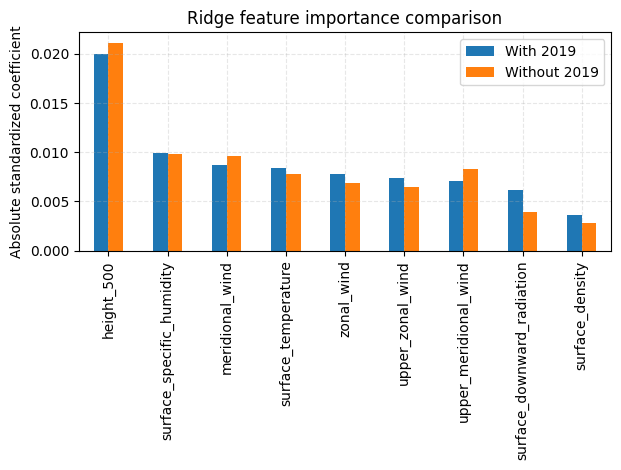

In [121]:
imp_df = pd.concat(
    [importance_with_2019, importance_without_2019],
    axis=1,
    keys=["With 2019", "Without 2019"]
).fillna(0)

plt.figure(figsize=(12,6))
imp_df.plot(kind="bar")
plt.ylabel("Absolute standardized coefficient")
plt.title("Ridge feature importance comparison")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

We see that the ridge method was appropriate to predict the cp in 2018, and still failed, like the ols, to estimate the target value in 2019. We then tried to estimate how much the 2019 year affected the feature importance to try to have a metric on how much this data is differente from what we had already

#### 2.7.2 Lasso Regression

In [122]:
def select_alpha_nested_lasso(X, y, alphas, val_size=12, min_train_size=24, step=12, max_iter=20000):
    """
    Escolhe alpha via walk-forward validation (expanding window), sem usar teste final.
    Retorna: best_alpha, r2_mean, train_ends
    """
    n = len(y)
    train_ends = list(range(min_train_size, n - val_size + 1, step))

    r2_mean = []

    for alpha in alphas:
        fold_scores = []

        for train_end in train_ends:
            X_train_raw = X[:train_end]
            y_train = y[:train_end]

            X_val_raw = X[train_end:train_end + val_size]
            y_val = y[train_end:train_end + val_size]

# normalization using training data only
            mean = X_train_raw.mean(axis=0)
            std  = X_train_raw.std(axis=0)
            std[std == 0] = 1e-8

            X_train = (X_train_raw - mean) / std
            X_val   = (X_val_raw  - mean) / std

            model = Lasso(alpha=alpha, max_iter=max_iter)
            model.fit(X_train, y_train)

            fold_scores.append(model.score(X_val, y_val))

        r2_mean.append(np.mean(fold_scores))

    r2_mean = np.array(r2_mean)
    best_idx = np.argmax(r2_mean)

    return alphas[best_idx], r2_mean, train_ends

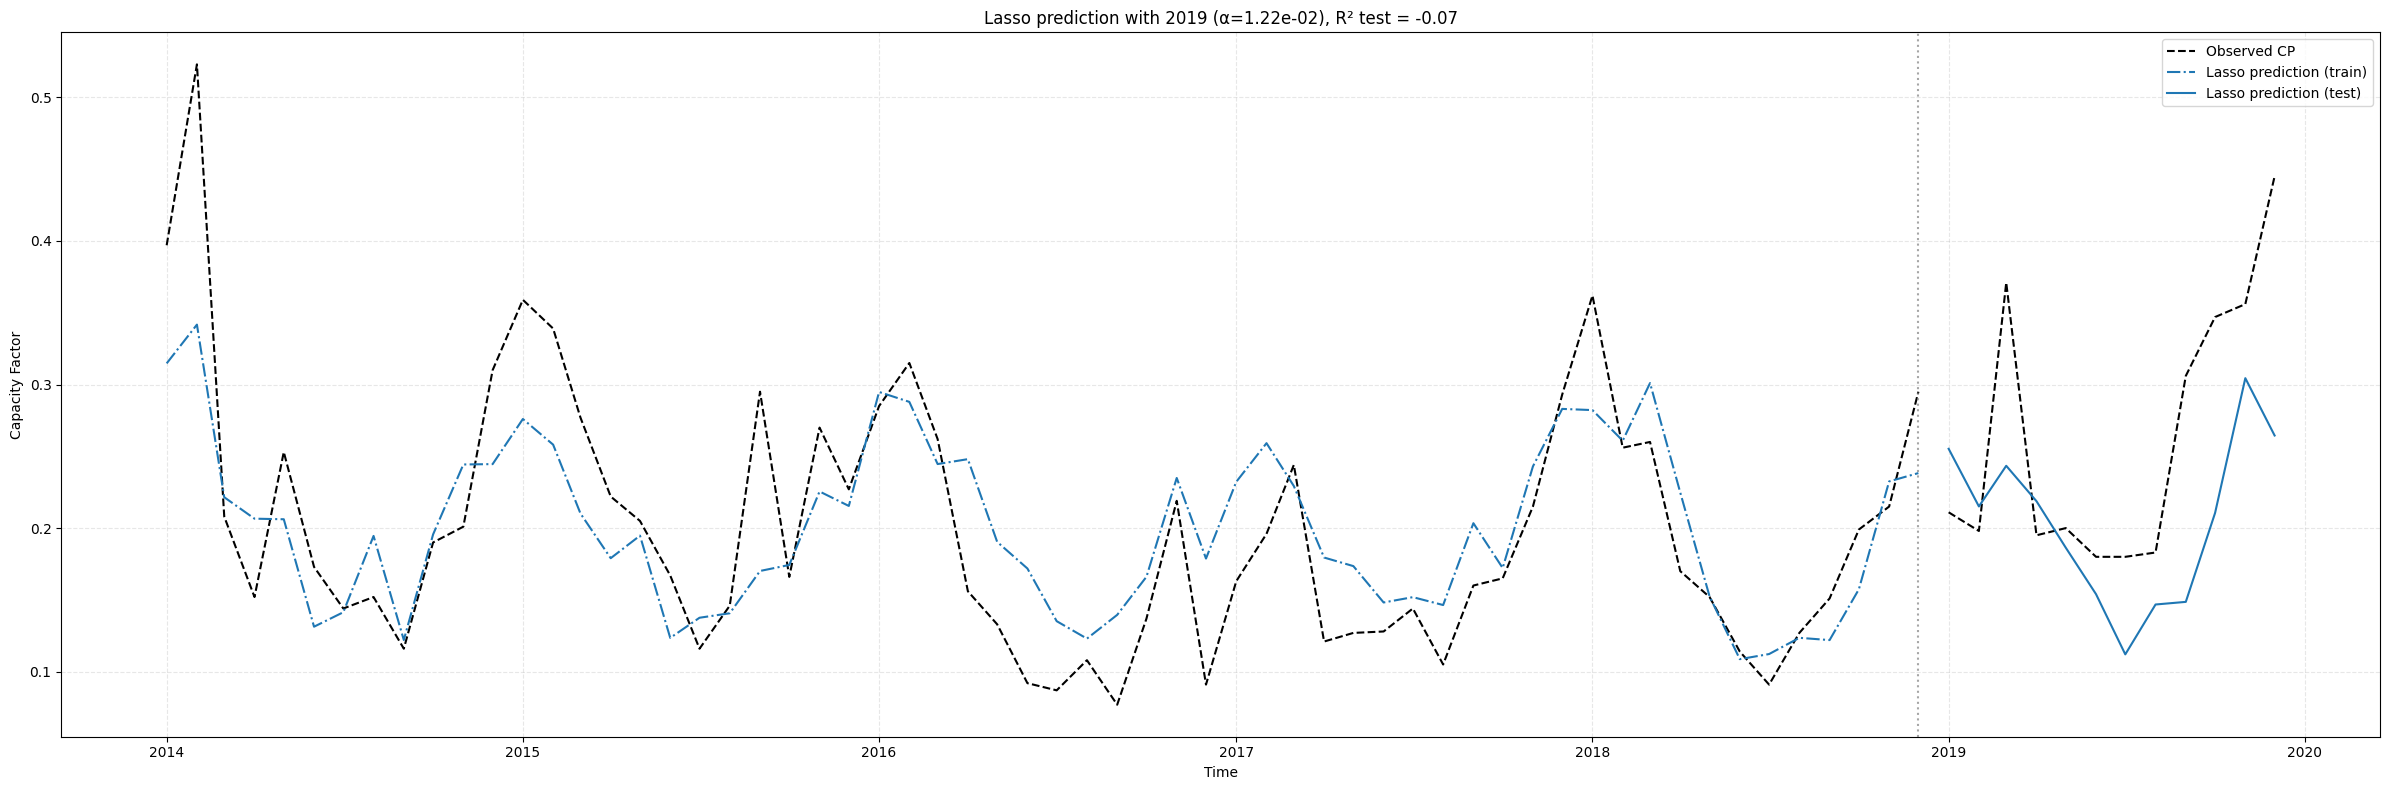

In [123]:
df = df_dataset.sort_index().copy()

X_full = df.drop(columns=["capacity_factor"]).values
y_full = df["capacity_factor"].values
time_index = df.index

# teste final = 2019
test_size = 12
n_train = len(df) - test_size

X_train_raw = X_full[:n_train]
y_train = y_full[:n_train]
X_test_raw  = X_full[n_train:]
y_test = y_full[n_train:]

# normalização APENAS com treino
mean = X_train_raw.mean(axis=0)
std  = X_train_raw.std(axis=0)
std[std == 0] = 1e-8

X_train = (X_train_raw - mean) / std
X_test  = (X_test_raw  - mean) / std

alphas = np.logspace(-3, 5, 60)

best_alpha_lasso = select_alpha_nested_lasso(X_full, y_full, alphas)[0]
lasso_2019 = Lasso(alpha=best_alpha_lasso, max_iter=10000)
lasso_2019.fit(X_train, y_train)

y_pred_train = lasso_2019.predict(X_train)
y_pred_test  = lasso_2019.predict(X_test)

R2_test = lasso_2019.score(X_test, y_test)

# plot
plt.figure(figsize=(24,8))

plt.plot(time_index[:n_train], y_train, 'k--', label='Observed CP')
plt.plot(time_index[n_train:], y_test, 'k--')

plt.plot(time_index[:n_train], y_pred_train,
         color='C0', linestyle='-.', label='Lasso prediction (train)')

plt.plot(time_index[n_train:], y_pred_test,
         color='C0', linestyle='-', label='Lasso prediction (test)')

plt.axvline(time_index[n_train-1], color='gray', linestyle=':', alpha=0.7)

plt.xlabel("Time")
plt.ylabel("Capacity Factor")
plt.title(f"Lasso prediction with 2019 (α={best_alpha_lasso:.2e}), R² test = {R2_test:.2f}")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


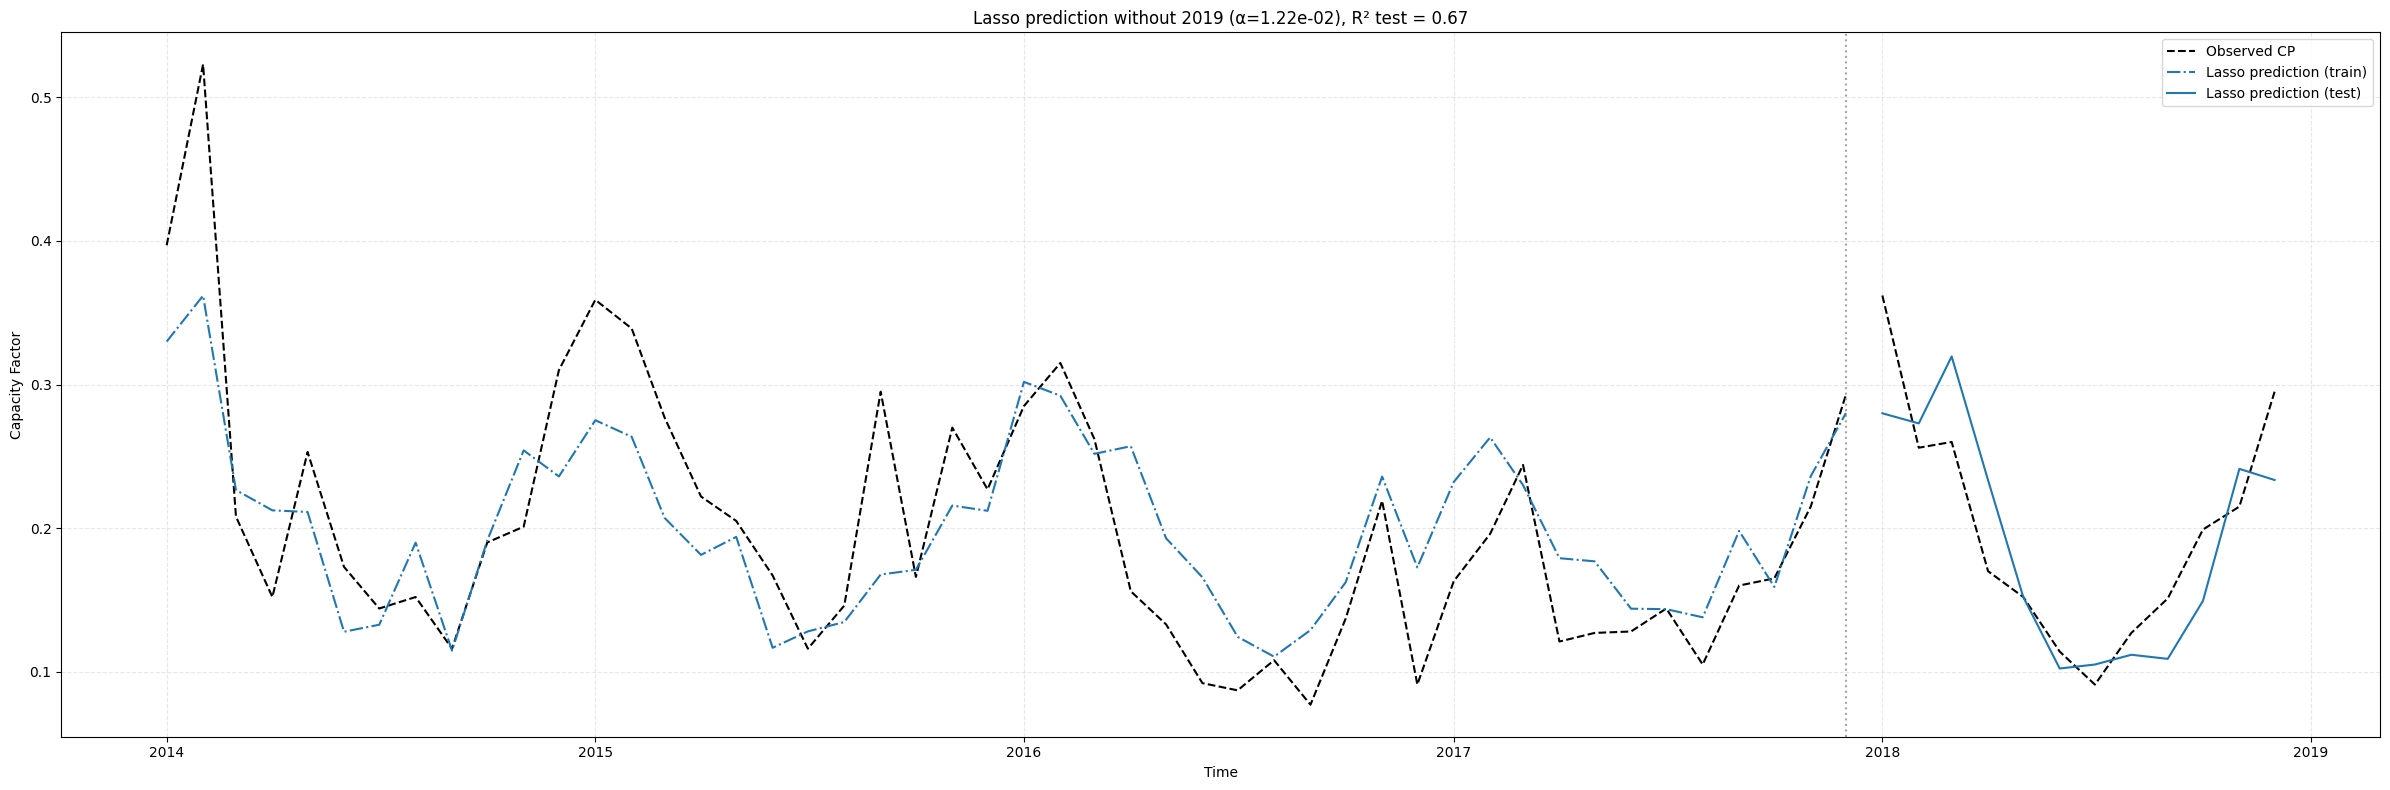

In [124]:
df_2018 = df_dataset.sort_index().loc[:'2018-12-01'].copy()

X_full = df_2018.drop(columns=["capacity_factor"]).values
y_full = df_2018["capacity_factor"].values
time_index = df_2018.index

test_size = 12
n_train = len(df_2018) - test_size

X_train_raw = X_full[:n_train]
y_train = y_full[:n_train]
X_test_raw  = X_full[n_train:]
y_test = y_full[n_train:]

mean = X_train_raw.mean(axis=0)
std  = X_train_raw.std(axis=0)
std[std == 0] = 1e-8

X_train = (X_train_raw - mean) / std
X_test  = (X_test_raw  - mean) / std


best_alpha_lasso_2018 = select_alpha_nested_lasso(X_full, y_full, alphas)[0]
lasso_2018 = Lasso(alpha=best_alpha_lasso_2018, max_iter=10000)
lasso_2018.fit(X_train, y_train)

y_pred_train = lasso_2018.predict(X_train)
y_pred_test  = lasso_2018.predict(X_test)

R2_test = lasso_2018.score(X_test, y_test)

plt.figure(figsize=(24,8))

plt.plot(time_index[:n_train], y_train, 'k--', label='Observed CP')
plt.plot(time_index[n_train:], y_test, 'k--')

plt.plot(time_index[:n_train], y_pred_train,
         color='C0', linestyle='-.', label='Lasso prediction (train)')

plt.plot(time_index[n_train:], y_pred_test,
         color='C0', linestyle='-', label='Lasso prediction (test)')

plt.axvline(time_index[n_train-1], color='gray', linestyle=':', alpha=0.7)

plt.xlabel("Time")
plt.ylabel("Capacity Factor")
plt.title(f"Lasso prediction without 2019 (α={best_alpha_lasso_2018:.2e}), R² test = {R2_test:.2f}")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

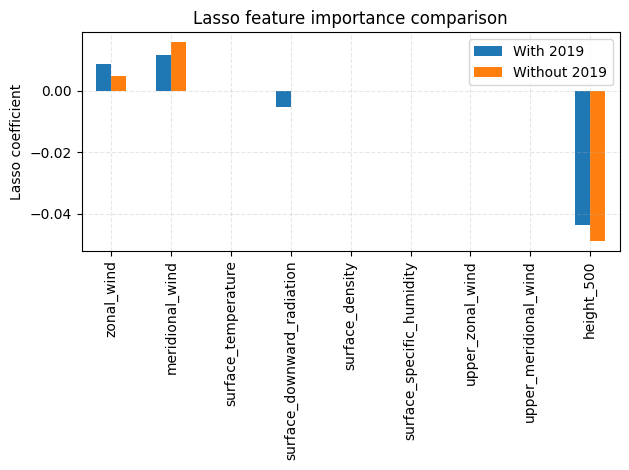

In [125]:
def lasso_feature_importance(df, alpha, test_size=12):
    df = df.sort_index().copy()

    X = df.drop(columns=["capacity_factor"]).values
    y = df["capacity_factor"].values
    features = df.drop(columns=["capacity_factor"]).columns

    n_train = len(df) - test_size

    X_train_raw = X[:n_train]
    y_train = y[:n_train]

    mean = X_train_raw.mean(axis=0)
    std  = X_train_raw.std(axis=0)
    std[std == 0] = 1e-8

    X_train = (X_train_raw - mean) / std

    model = Lasso(alpha=alpha, max_iter=10000)
    model.fit(X_train, y_train)

    return pd.Series(model.coef_, index=features)

imp_lasso_2018 = lasso_feature_importance(
    df_2018,
    alpha=best_alpha_lasso_2018,
    test_size=12
)

imp_lasso_2019 = lasso_feature_importance(
    df_dataset,
    alpha=best_alpha_lasso,
    test_size=12
)


imp_df = pd.concat(
    [imp_lasso_2019, imp_lasso_2018],
    axis=1,
    keys=["With 2019", "Without 2019"]
).fillna(0)

plt.figure(figsize=(12,6))
imp_df.plot(kind='bar')
plt.ylabel("Lasso coefficient")
plt.title("Lasso feature importance comparison")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()



### 2.8. Comparison between OLS, Ridge and Lasso

Comparing the three linear modeling approaches highlights important methodological differences. Ordinary least squares provides an unconstrained fit that is highly sensitive to multicollinearity and distributional shifts. Ridge regression improves stability by shrinking coefficients, resulting in smoother predictions and enhanced robustness. Lasso regression, while offering a parsimonious model through feature selection, may sacrifice physical completeness in the presence of correlated predictors once he completely exclude some of the variables used.

Overall, Ridge regression emerges as a balanced solution for this application, as it preserves the contribution of all climate variables while mitigating overfitting and instability. For that reason we will use only this model from now on.

## 3. Enriching the data

In [126]:
ds_mask = xr.load_dataset(data_dir_climate / filename_mask)
da_mask = ds_mask['mask']

variables = [
    'zonal_wind',
    'meridional_wind',
    'surface_temperature',
    'surface_downward_radiation',
    'surface_density',
    'surface_specific_humidity',
    'upper_zonal_wind',
    'upper_meridional_wind',
    'height_500',
]

all_regions_list = [
    'Grand Est', 'Nouvelle-Aquitaine', 'Auvergne-Rhône-Alpes',
    'Bourgogne-Franche-Comté', 'Bretagne', 'Centre-Val de Loire',
    'Ile-de-France', 'Occitanie', 'Hauts-de-France', 'Normandie',
    'Pays-de-la-Loire', 'PACA'
]

dfs = []

for var in variables:
    ds_var = xr.load_dataset(data_dir_climate / filename_climate.format(var))
    da_var = ds_var[var]  # (time, lat, lon)

    # spatial average by region
    da_var_reg = da_var.groupby(da_mask).mean().rename(mask='region')
    da_var_reg['region'] = ds_mask['region'].values

    # keep only the regions of interest
    da_var_reg = da_var_reg.sel(region=all_regions_list)

    # convert to pandas with a MultiIndex (time, region)
    df_var = da_var_reg.to_pandas().stack().rename(var)
    dfs.append(df_var)

df_all_variables = pd.concat(dfs, axis=1)

df_all_variables = df_all_variables.reset_index()
# columns are now: ['time', 'region', var1, var2, ...]

# one-hot encoding of regions
df_regions_ohe = pd.get_dummies(
    df_all_variables['region'],
    prefix='region',
    drop_first=False
)

# final feature dataframe
df_X = pd.concat(
    [df_all_variables.drop(columns='region'), df_regions_ohe],
    axis=1
)

df_X = df_X.set_index('time').sort_index()

### 3.1 Glossary (per region, per month)

#### 3.1.1. Base features for each climate variable `v ∈ BASE_VARS`

* `{v}_mean`: Monthly mean of hourly values (typical level during the month).
* `{v}_std`: Monthly standard deviation (within-month variability).
* `{v}_p10`: 10th percentile (robust low-end level, less sensitive than min).
* `{v}_p90`: 90th percentile (robust high-end level, less sensitive than max).
* `{v}_min`: Minimum hourly value in the month (extreme low event).
* `{v}_max`: Maximum hourly value in the month (extreme high event).
* `{v}_mean_abs_diff_1h`: Mean absolute hourly change `mean(|x_t - x_{t-1}|)` (Low values -> steady wind regime High values -> gusty, turbulent, rapidly changing wind)
* `{v}_acf_24h`: Autocorrelation at 24h lag (daily persistence / daily cycle strength) - High value -> very persistent daily pattern,  Near zero -> weak or no daily structure (How similar are today and tomorrow at the same hour?)
* `{v}_trend_slope`: Linear trend slope within the month (systematic increase/decrease over the month).


#### 3.1.2. Wind-derived features (from components)

* `wind_speed`: Surface wind speed magnitude `sqrt(u^2 + v^2)`.
* `upper_wind_speed`: Upper-level wind speed magnitude `sqrt(u2^2 + v2^2)`.
* `shear_speed`: Vertical shear proxy `upper_wind_speed - wind_speed` (difference aloft vs surface).
* `wind_speed3_mean`: Monthly mean of `wind_speed^3` (since wind power scales roughly with speed cubed).
* `wind_speed3_p90`: 90th percentile of `wind_speed^3` (high-power wind events proxy).
* `wpd_mean`: Monthly mean wind power density proxy `0.5 * rho * wind_speed^3` (includes air density).
* `wpd_p90`: 90th percentile of wind power density proxy (extreme/high resource conditions).

For each of these series:

* `{name}_mean`: Monthly mean magnitude (typical intensity).
* `{name}_std`: Monthly standard deviation (gustiness / variability).
* `{name}_p90`: 90th percentile magnitude (strong-wind / strong-shear conditions).


#### 3.1.3. Wind direction (circular statistics)

* `wind_dir_sin_mean`: Mean of `sin(direction)` over the month (direction encoding, avoids angle wrap-around).
* `wind_dir_cos_mean`: Mean of `cos(direction)` over the month (direction encoding, avoids angle wrap-around).
* `wind_dir_R`: Resultant length `sqrt(mean(sin)^2 + mean(cos)^2)` (directional persistence; 1 = stable, 0 = highly variable).


#### 3.1.4. Seasonal features (month harmonics)

Let `m` be the month index (1–12):

* `sin_1y`: `sin(2π m / 12)` (annual seasonality, smooth across year boundary).
* `cos_1y`: `cos(2π m / 12)` (annual seasonality companion term).
* `sin_2y`: `sin(4π m / 12)` (second harmonic, captures asymmetry/shape beyond a simple sinusoid).
* `cos_2y`: `cos(4π m / 12)` (second harmonic companion term).


In [128]:
df_climat = df_X.copy()
df_climat.index = pd.to_datetime(df_climat.index)
df_climat = df_climat.sort_index()

region_cols = [c for c in df_climat.columns if c.startswith("region_")]
if not region_cols:
    raise ValueError("Não encontrei colunas 'region_*' no df_X / df_climat.")


df_climat["region"] = (
    df_climat[region_cols]
    .idxmax(axis=1)
    .str.replace("region_", "", regex=False)
)

df_climat["year_month"] = df_climat.index.to_period("M")

BASE_VARS = [
    "zonal_wind",
    "meridional_wind",
    "surface_temperature",
    "surface_downward_radiation",
    "surface_density",
    "surface_specific_humidity",
    "upper_zonal_wind",
    "upper_meridional_wind",
    "height_500",
]

missing = [v for v in BASE_VARS if v not in df_climat.columns]
if missing:
    raise ValueError(f"Faltam colunas climáticas no df_climat: {missing}")


df_energy_proc = df_energy.copy()


df_energy_proc.index = pd.to_datetime(df_energy_proc.index)
df_energy_proc = df_energy_proc.sort_index()


df_energy_proc["year_month"] = df_energy_proc.index.to_period("M")

energy_val_cols = [c for c in df_energy_proc.columns if c != "year_month"]

energy_long = df_energy_proc.melt(
    id_vars=["year_month"],
    value_vars=energy_val_cols,
    var_name="region",
    value_name="capacity_factor",
)


region_map = {
    "Île-de-France": "Ile-de-France",
    "Pays de la Loire": "Pays-de-la-Loire",
    "Provence-Alpes-Côte d'Azur": "PACA",
}
energy_long["region"] = energy_long["region"].replace(region_map)


def _safe_quantile(x: pd.Series, q: float):
    x = x.dropna()
    return np.nan if x.empty else float(x.quantile(q))

def _mean_abs_diff_1h(x: pd.Series):
    x = x.dropna()
    if len(x) < 2:
        return np.nan
    x = x.sort_index()
    return float(x.diff().abs().mean())

def _acf_lag(x: pd.Series, lag: int):
    x = x.dropna()
    if len(x) <= lag:
        return np.nan
    x = x.sort_index()
    x1 = x.iloc[:-lag]
    x2 = x.iloc[lag:]
    if x1.std() == 0 or x2.std() == 0:
        return np.nan
    return float(x1.corr(x2))

def _trend_slope(x: pd.Series):
    x = x.dropna()
    if len(x) < 3:
        return np.nan
    x = x.sort_index()
    t = (x.index - x.index[0]).total_seconds() / 3600.0
    return float(np.polyfit(t, x.values, 1)[0])

def _max_consecutive_true(mask: pd.Series):
    m = mask.fillna(False).astype(bool).values
    best, cur = 0, 0
    for v in m:
        if v:
            cur += 1
            best = max(best, cur)
        else:
            cur = 0
    return float(best)



def compute_month_features(g: pd.DataFrame) -> pd.Series:
    g = g.sort_index()
    out = {}


    for v in BASE_VARS:
        x = g[v]
        out[f"{v}_mean"] = float(x.mean())
        out[f"{v}_std"]  = float(x.std())
        out[f"{v}_p10"]  = _safe_quantile(x, 0.10)
        out[f"{v}_p90"]  = _safe_quantile(x, 0.90)
        out[f"{v}_min"]  = float(x.min())
        out[f"{v}_max"]  = float(x.max())

        out[f"{v}_mean_abs_diff_1h"] = _mean_abs_diff_1h(x)
        out[f"{v}_acf_24h"] = _acf_lag(x, 24)
        out[f"{v}_trend_slope"] = _trend_slope(x)

    u = g["zonal_wind"]
    v = g["meridional_wind"]
    u2 = g["upper_zonal_wind"]
    v2 = g["upper_meridional_wind"]

    wind_speed = np.sqrt(u**2 + v**2)
    upper_wind_speed = np.sqrt(u2**2 + v2**2)
    shear_speed = upper_wind_speed - wind_speed

    for name, x in [
        ("wind_speed", wind_speed),
        ("upper_wind_speed", upper_wind_speed),
        ("shear_speed", shear_speed),
    ]:
        xs = pd.Series(x, index=g.index)
        out[f"{name}_mean"] = float(xs.mean())
        out[f"{name}_std"]  = float(xs.std())
        out[f"{name}_p90"]  = _safe_quantile(xs, 0.90)

    wind_dir = np.arctan2(v, u)
    sin_dir = np.sin(wind_dir)
    cos_dir = np.cos(wind_dir)
    sin_s = pd.Series(sin_dir, index=g.index)
    cos_s = pd.Series(cos_dir, index=g.index)
    out["wind_dir_sin_mean"] = float(sin_s.mean())
    out["wind_dir_cos_mean"] = float(cos_s.mean())
    out["wind_dir_R"] = float(np.sqrt(out["wind_dir_sin_mean"]**2 + out["wind_dir_cos_mean"]**2))

    wind_speed3 = wind_speed**3
    out["wind_speed3_mean"] = float(pd.Series(wind_speed3, index=g.index).mean())
    out["wind_speed3_p90"]  = _safe_quantile(pd.Series(wind_speed3, index=g.index), 0.90)

    rho = g["surface_density"]
    wpd = 0.5 * rho * wind_speed3
    out["wpd_mean"] = float(pd.Series(wpd, index=g.index).mean())
    out["wpd_p90"]  = _safe_quantile(pd.Series(wpd, index=g.index), 0.90)
    
    return pd.Series(out)


features = (
    df_climat
    .groupby(["region", "year_month"], observed=True)
    .apply(compute_month_features)
    .reset_index()
)

df_model = features.merge(energy_long, on=["region", "year_month"], how="inner")


month = df_model["year_month"].dt.month.astype(int)
df_model["sin_1y"] = np.sin(2 * np.pi * month / 12.0)
df_model["cos_1y"] = np.cos(2 * np.pi * month / 12.0)
df_model["sin_2y"] = np.sin(4 * np.pi * month / 12.0)
df_model["cos_2y"] = np.cos(4 * np.pi * month / 12.0)


df_model = pd.get_dummies(df_model, columns=["region"], drop_first=False)

#print("df_model shape:", df_model.shape)
#print(df_model.head(3))


In [129]:
y = df_model["capacity_factor"]

drop_cols = [
    "capacity_factor",
    "year_month",
]

X = df_model.drop(columns=drop_cols)


In [130]:
train_mask = df_model["year_month"] < pd.Period("2019-01", freq="M")
test_mask  = df_model["year_month"] >= pd.Period("2019-01", freq="M")

X_train, X_test = X.loc[train_mask], X.loc[test_mask]
y_train, y_test = y.loc[train_mask], y.loc[test_mask]

print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)

Train shape: (720, 113)
Test shape : (144, 113)


In [131]:
alphas = np.logspace(-4, 4, 50)

ridge_model = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", RidgeCV(alphas=alphas, cv=5))
])

ridge_model.fit(X_train, y_train)

print("Best alpha (Ridge):", ridge_model.named_steps["ridge"].alpha_)

Best alpha (Ridge): 51.79474679231202


In [132]:
y_pred_train = ridge_model.predict(X_train)
y_pred_test  = ridge_model.predict(X_test)

def regression_metrics(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": mean_squared_error(y_true, y_pred),
    }

print("Train metrics:", regression_metrics(y_train, y_pred_train))
print("Test  metrics:", regression_metrics(y_test, y_pred_test))


Train metrics: {'R2': 0.9127241273180053, 'MAE': 0.018954442996882977, 'RMSE': 0.0006772494988787237}
Test  metrics: {'R2': 0.8461056936693561, 'MAE': 0.02451940879317328, 'RMSE': 0.0010878272861715968}


In [133]:
region_cols = [c for c in X.columns if c.startswith("region_")]

results_by_region = []

for col in region_cols:
    region_name = col.replace("region_", "")
    idx = X_test[col] == 1

    if idx.sum() < 5:
        continue

    metrics = regression_metrics(
        y_test[idx],
        y_pred_test[idx]
    )
    metrics["region"] = region_name
    results_by_region.append(metrics)

df_region_metrics = pd.DataFrame(results_by_region).set_index("region")
print(df_region_metrics.sort_values("R2", ascending=False))


                               R2       MAE      RMSE
region                                               
Pays-de-la-Loire         0.967852  0.010010  0.000164
Hauts-de-France          0.939675  0.014341  0.000425
Centre-Val de Loire      0.939636  0.015901  0.000345
Normandie                0.934548  0.020378  0.000531
Bretagne                 0.931246  0.016453  0.000378
Grand Est                0.924286  0.023219  0.000679
Occitanie                0.912748  0.021302  0.000501
Nouvelle-Aquitaine       0.865437  0.021560  0.000734
Auvergne-Rhône-Alpes     0.854382  0.020145  0.000627
Bourgogne-Franche-Comté  0.833025  0.030273  0.001429
PACA                     0.607267  0.048342  0.003676
Ile-de-France            0.563460  0.052310  0.003566


In [134]:
y_pred_test = ridge_model.predict(X_test)

df_test_plot = df_model.loc[test_mask, ["year_month", "capacity_factor"]].copy()
df_test_plot["y_pred"] = y_pred_test

df_test_time = df_test_plot.sort_values("year_month").copy()
x_time = df_test_time["year_month"].astype(str)  # eixo legível


region_cols = [c for c in X_test.columns if c.startswith("region_")]


### 3.2. Model performance on each region - Testing on 2019

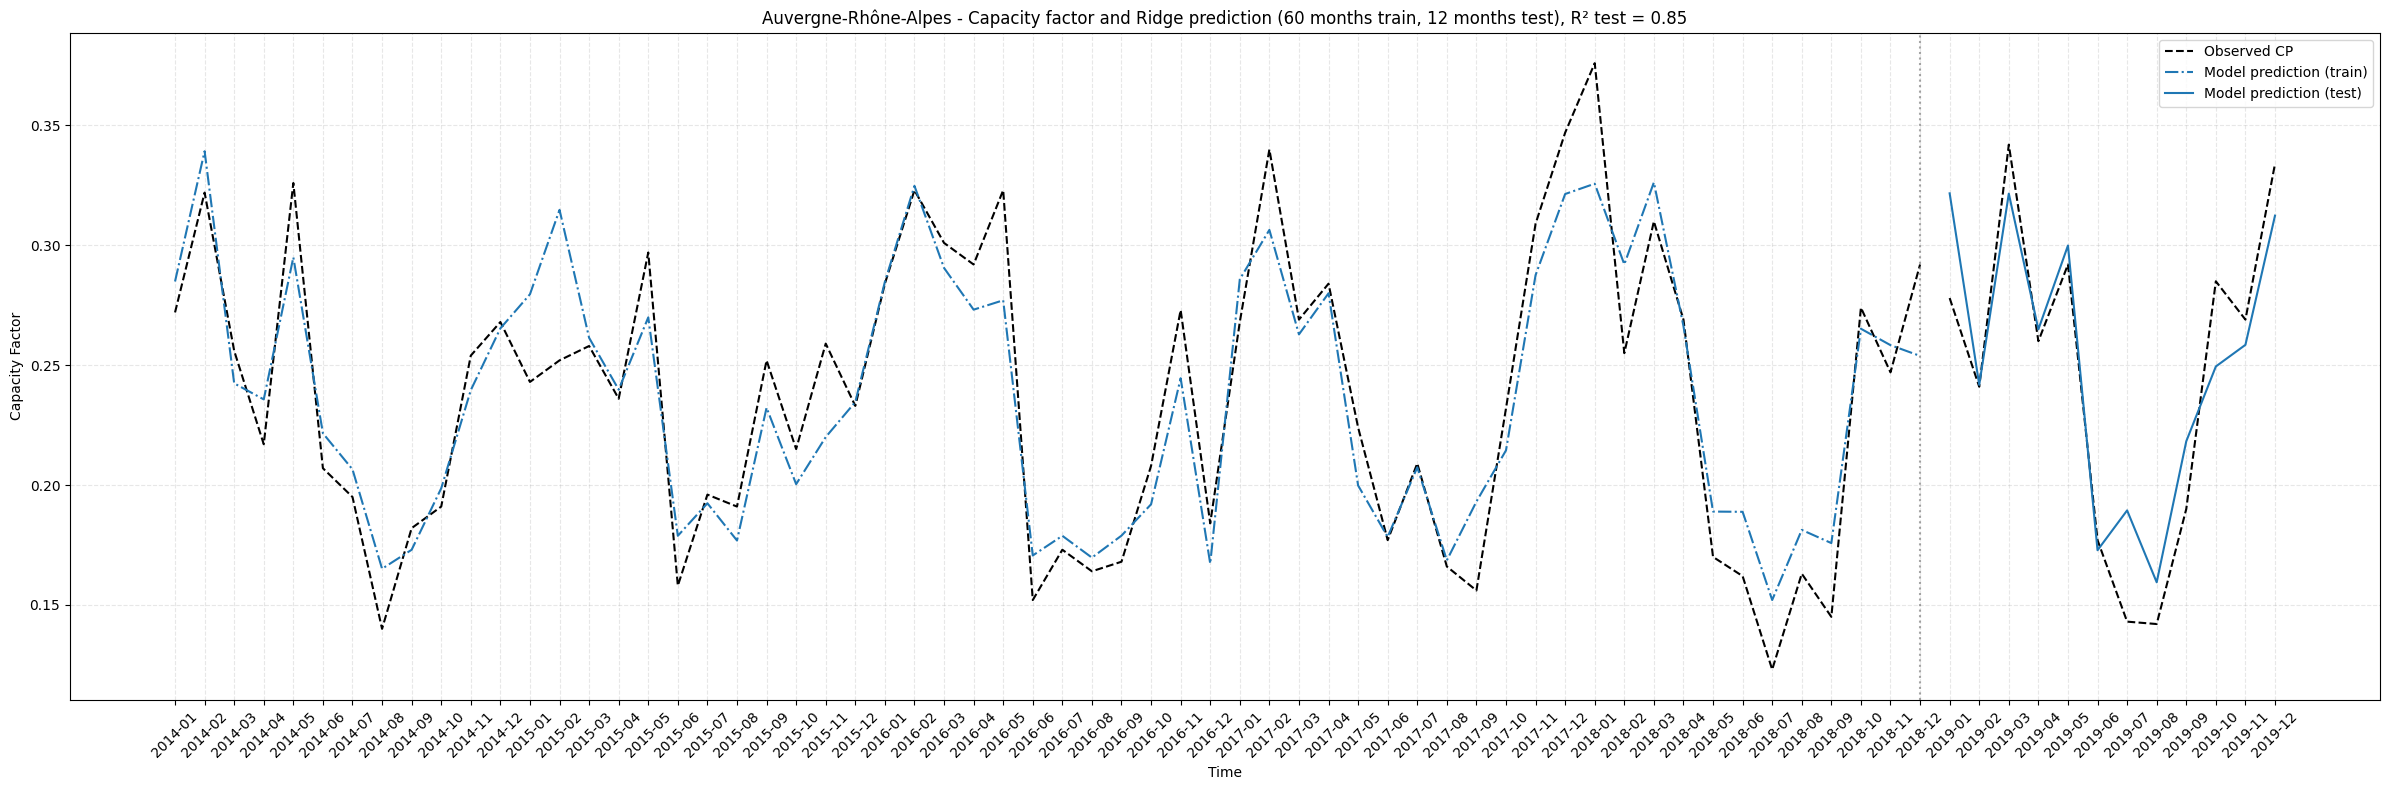

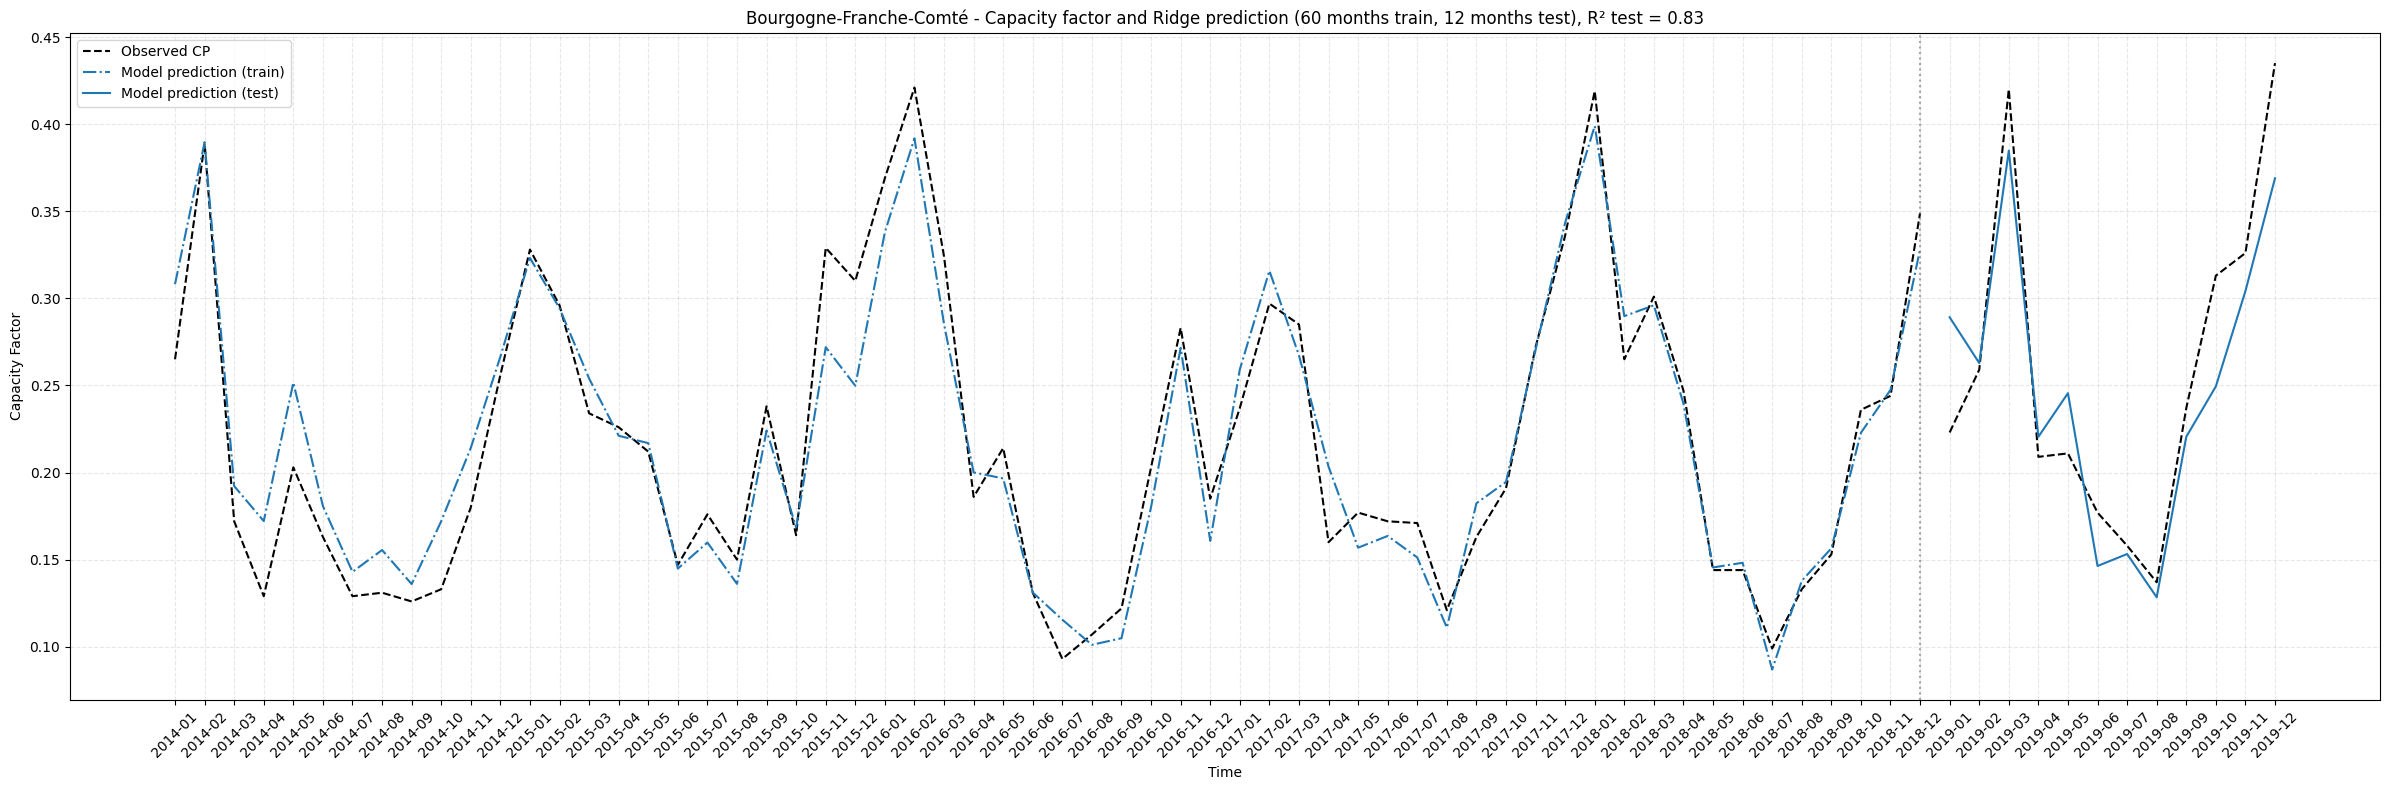

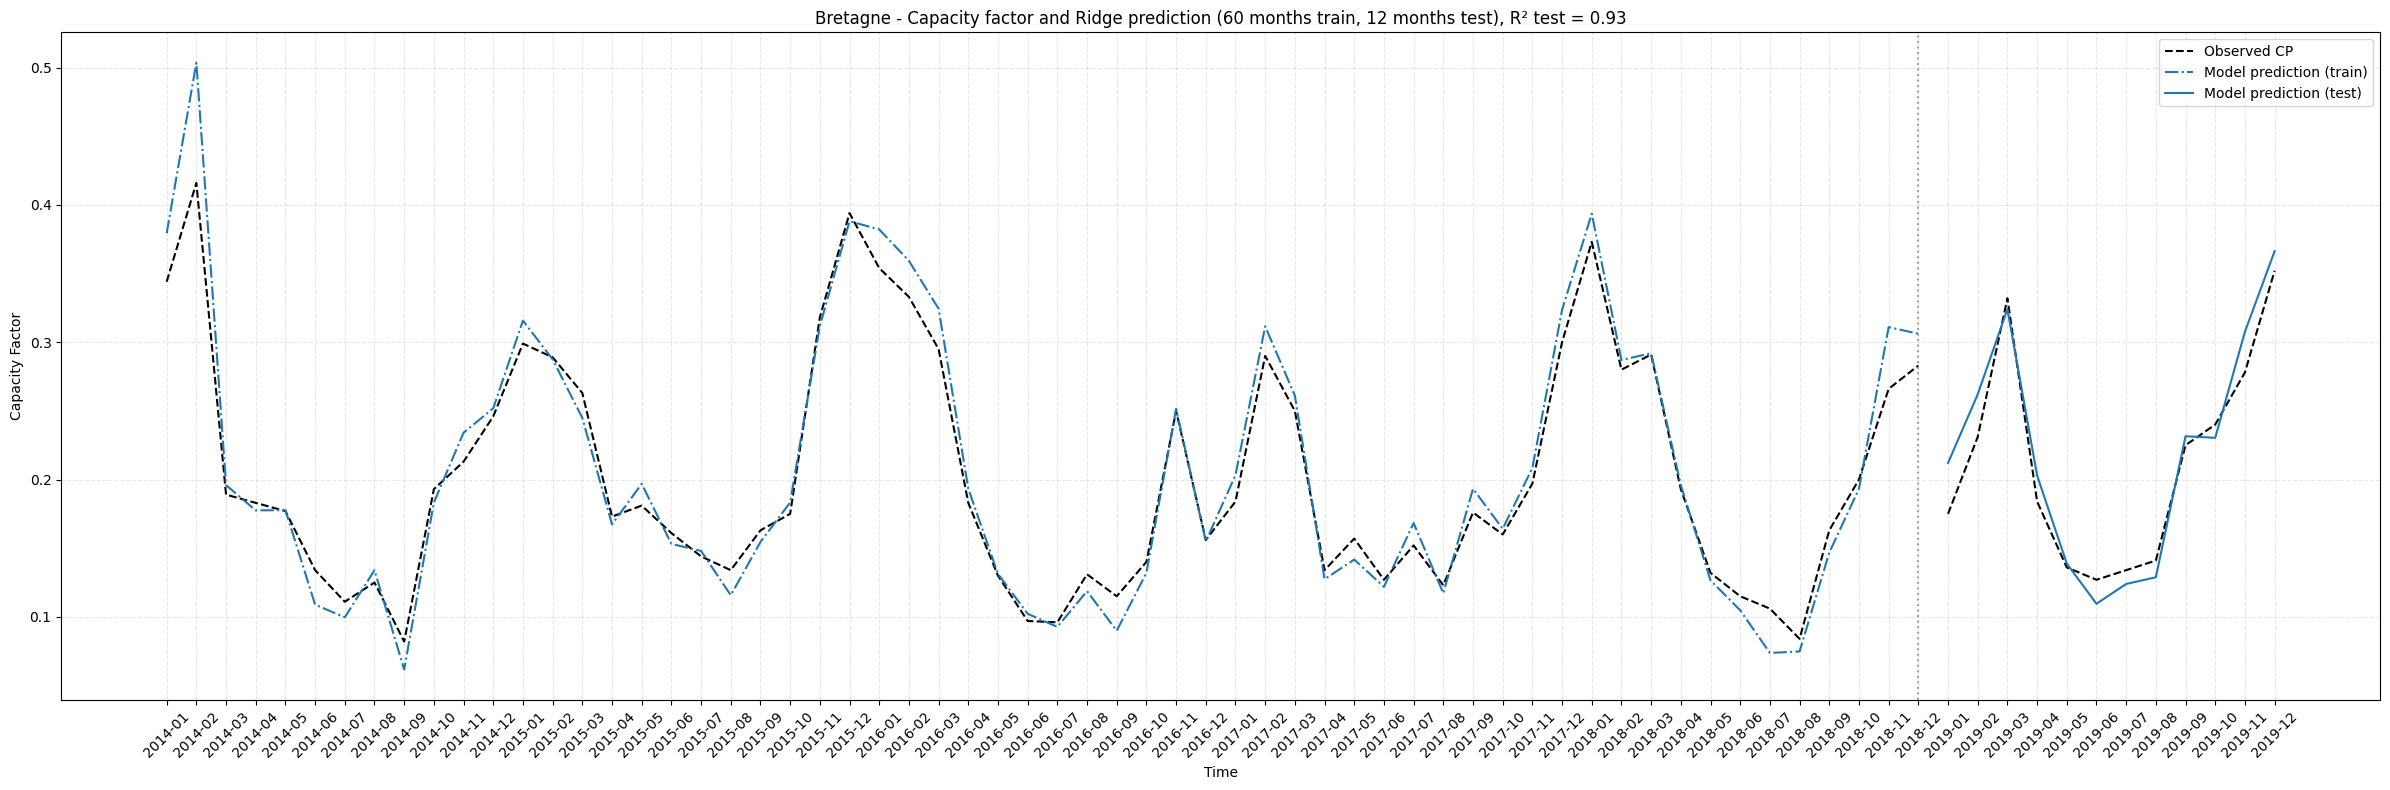

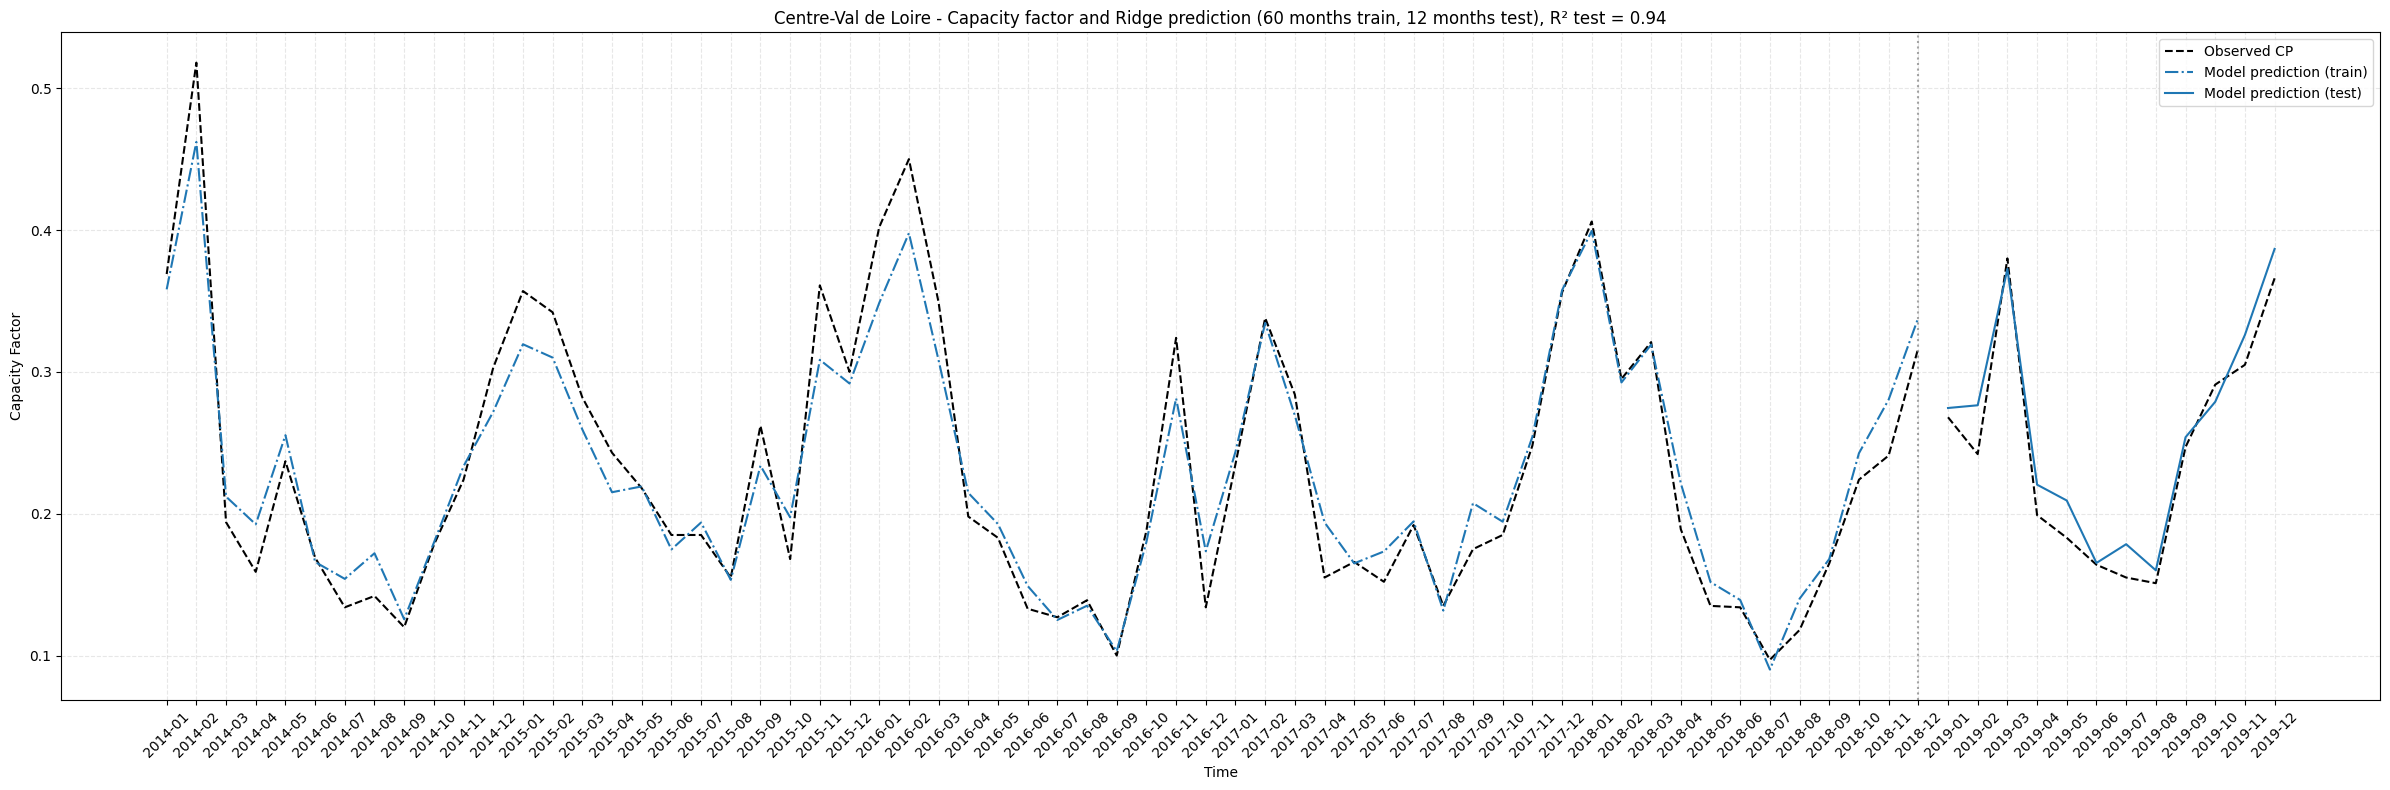

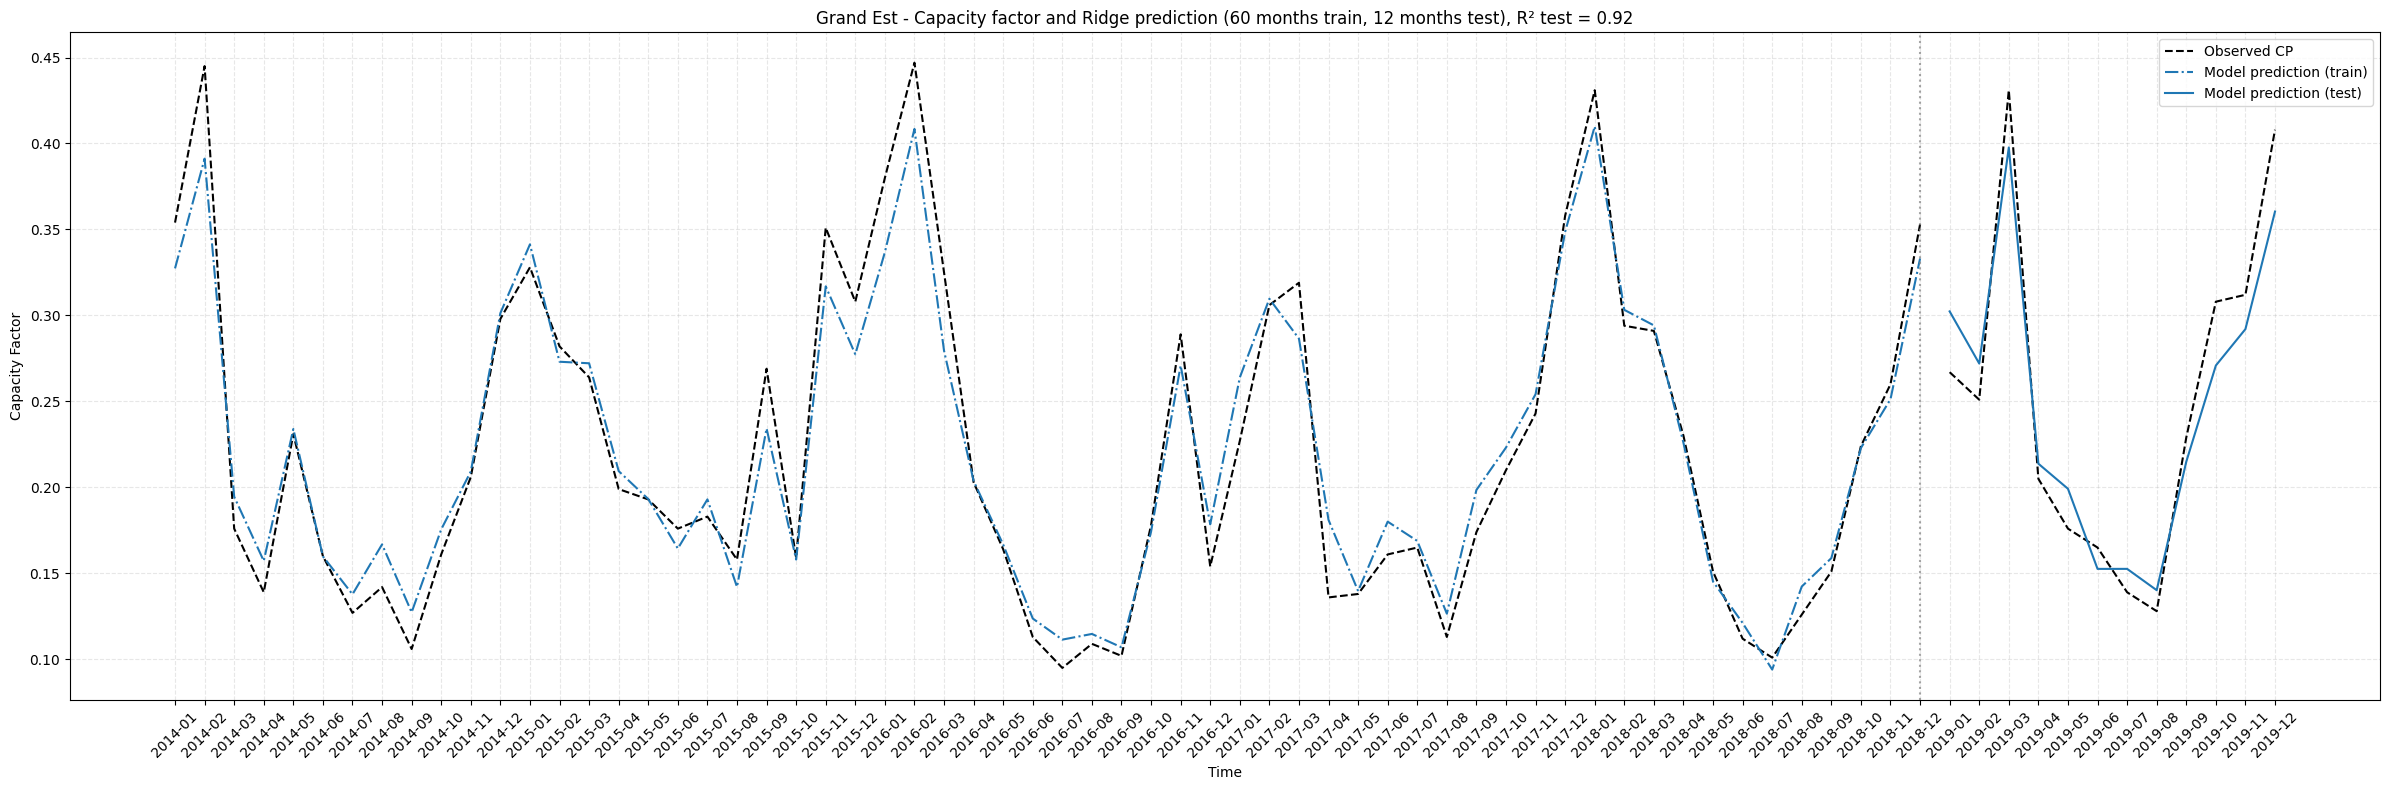

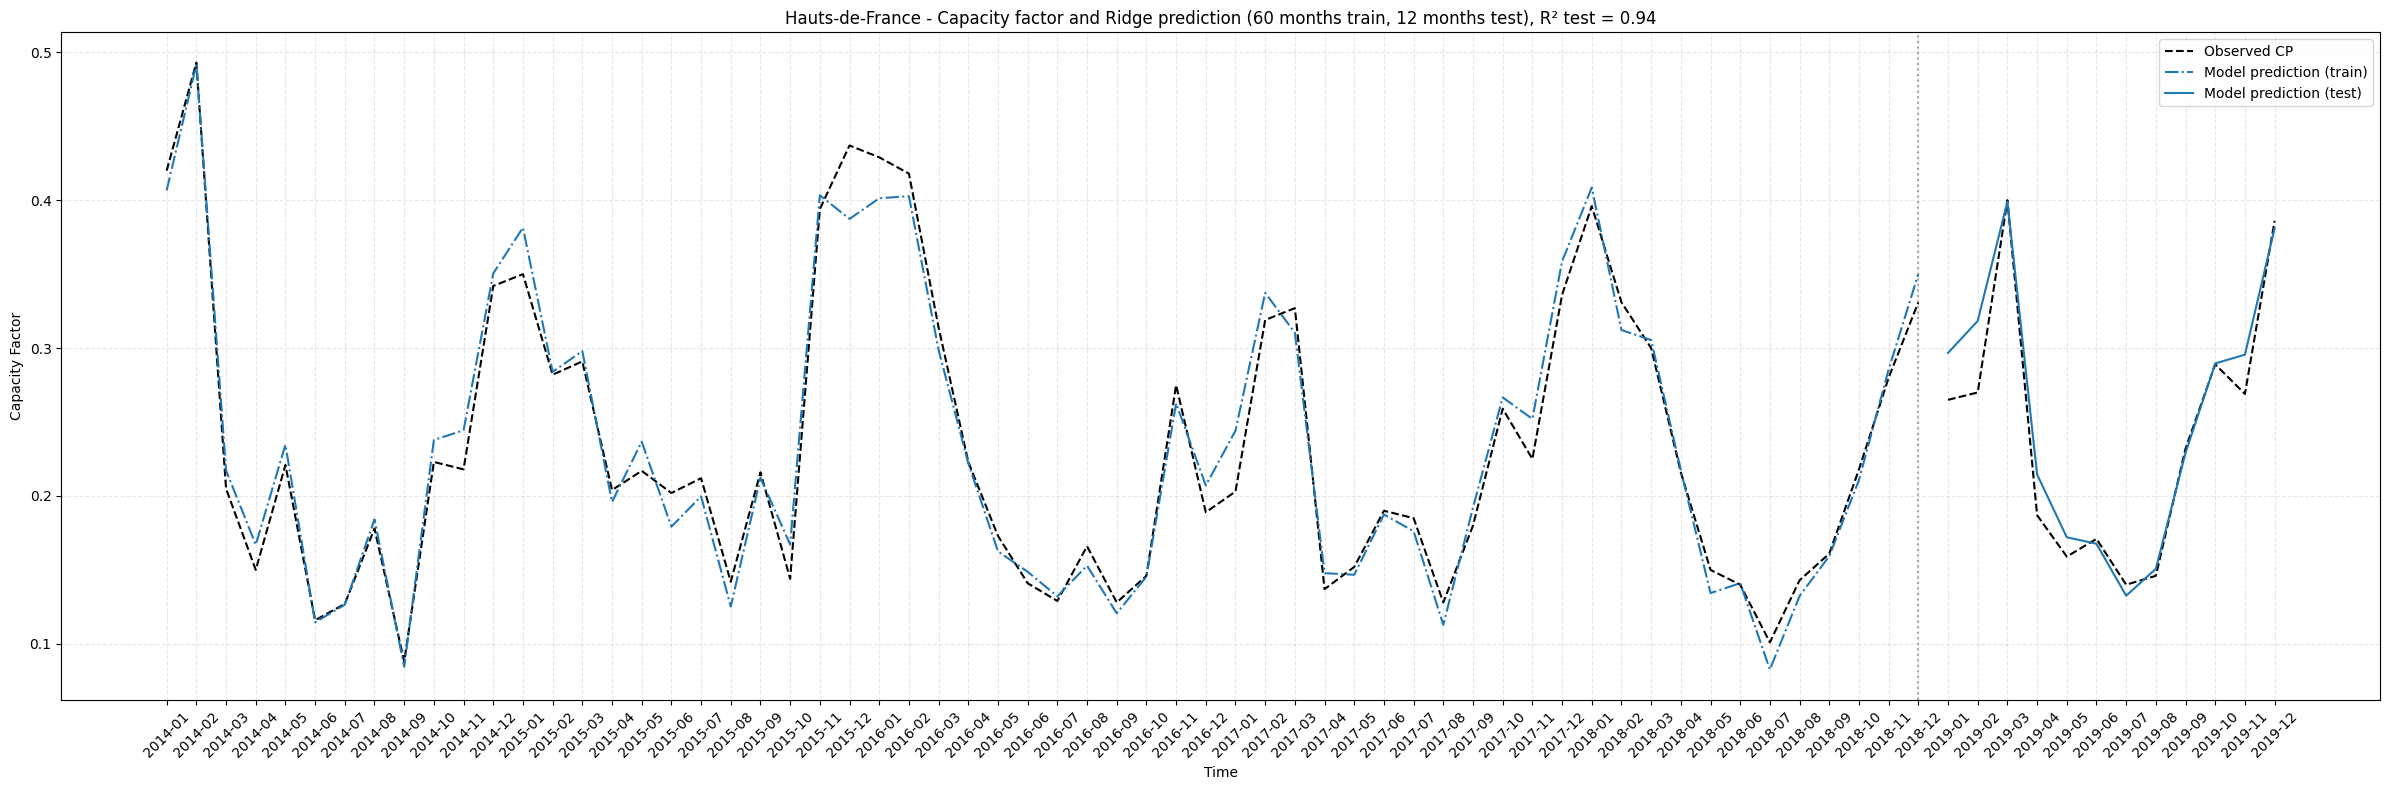

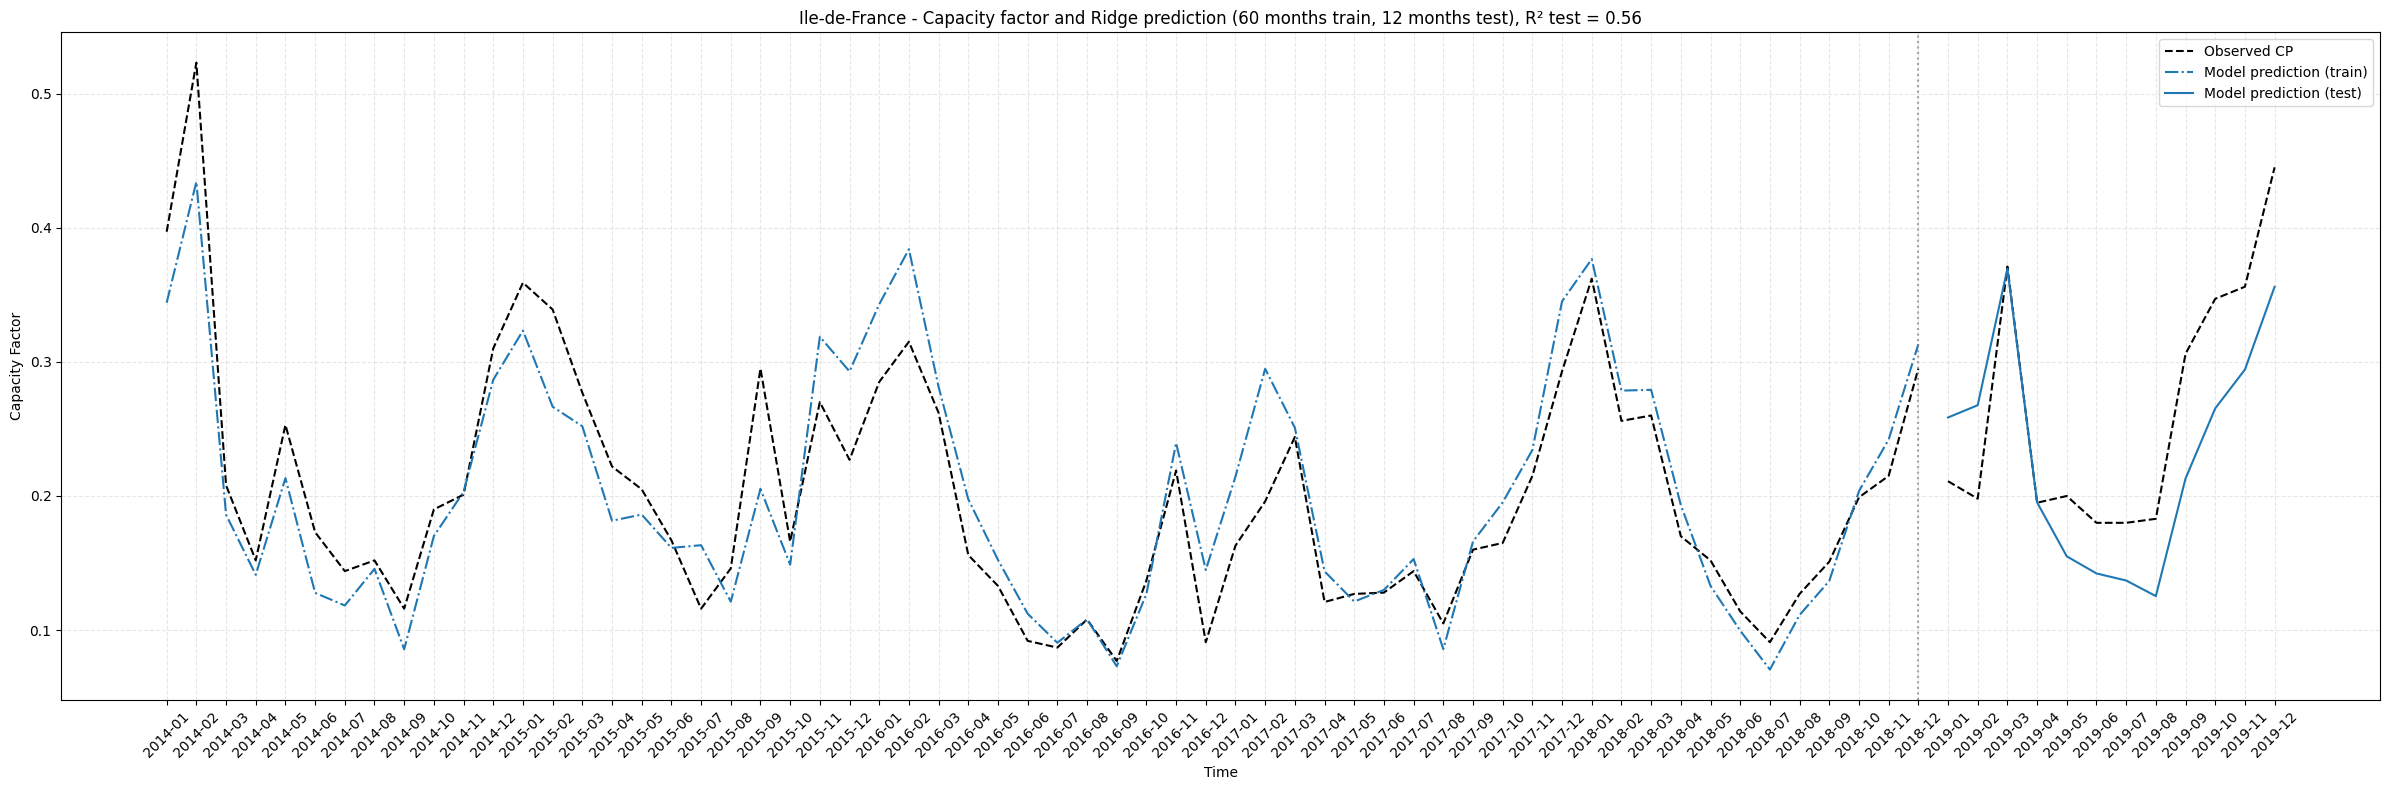

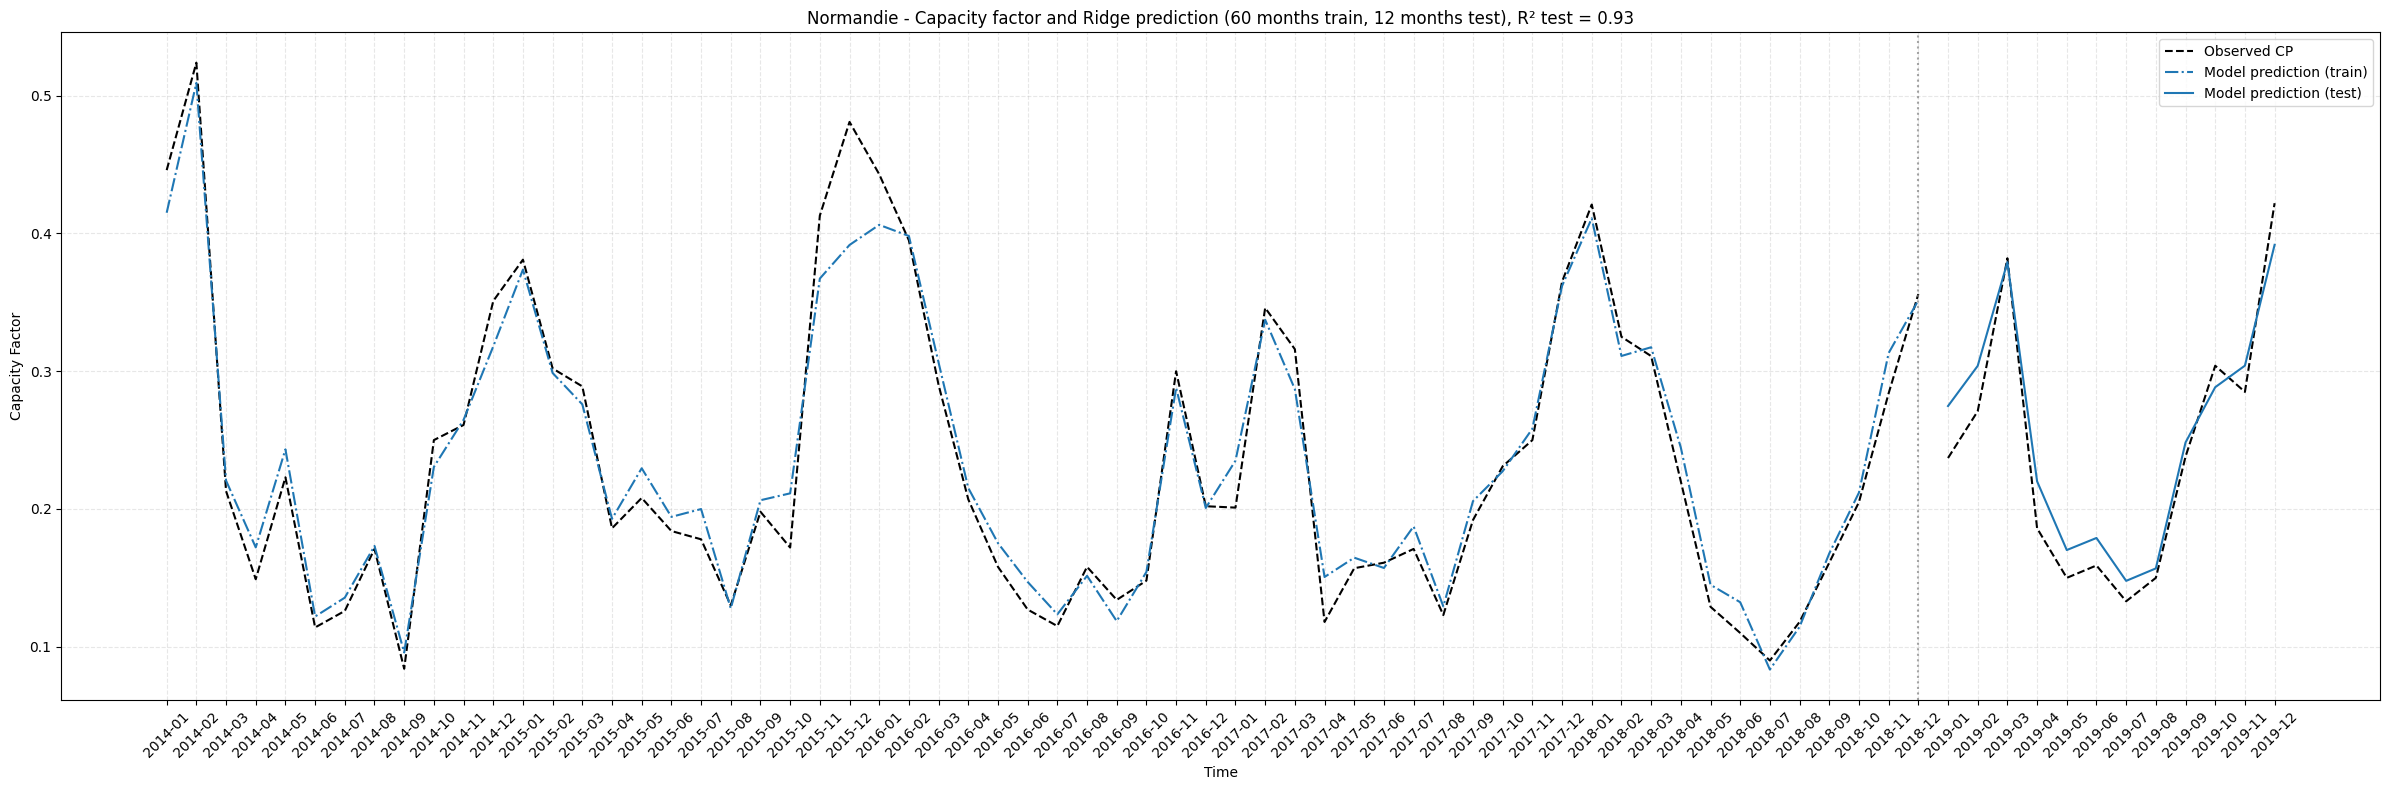

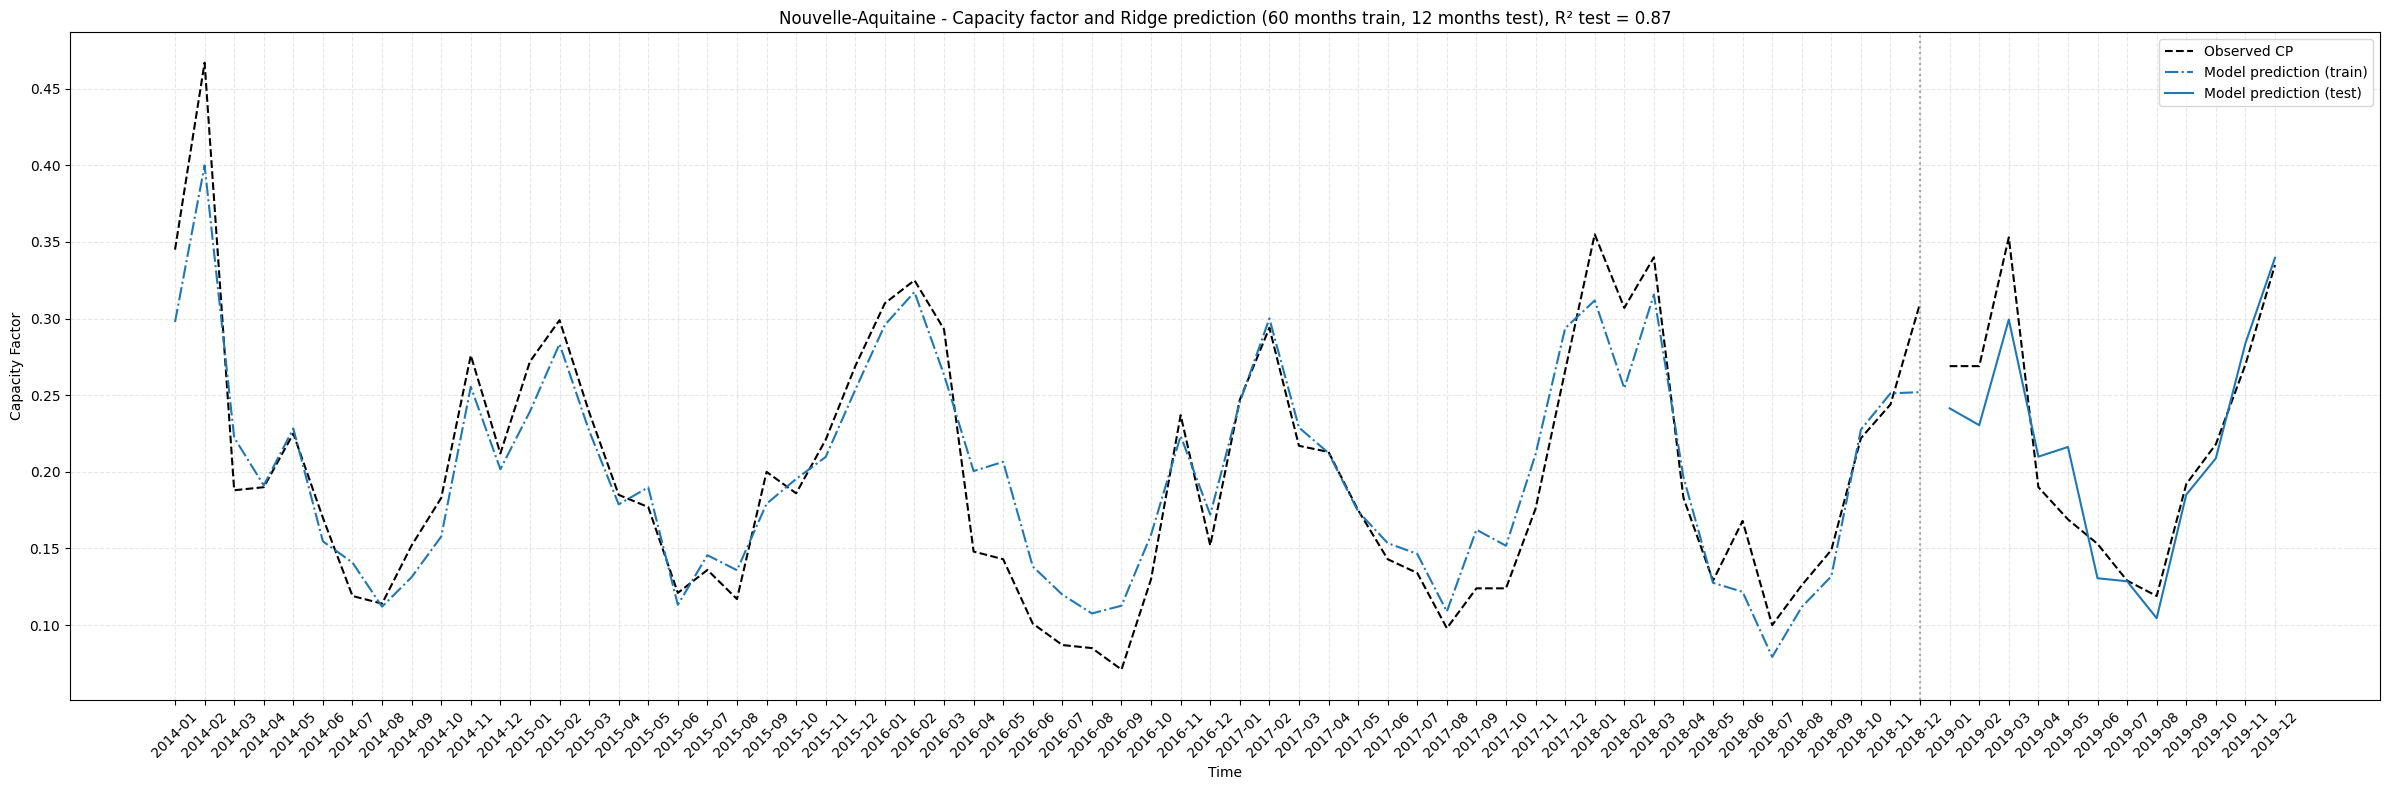

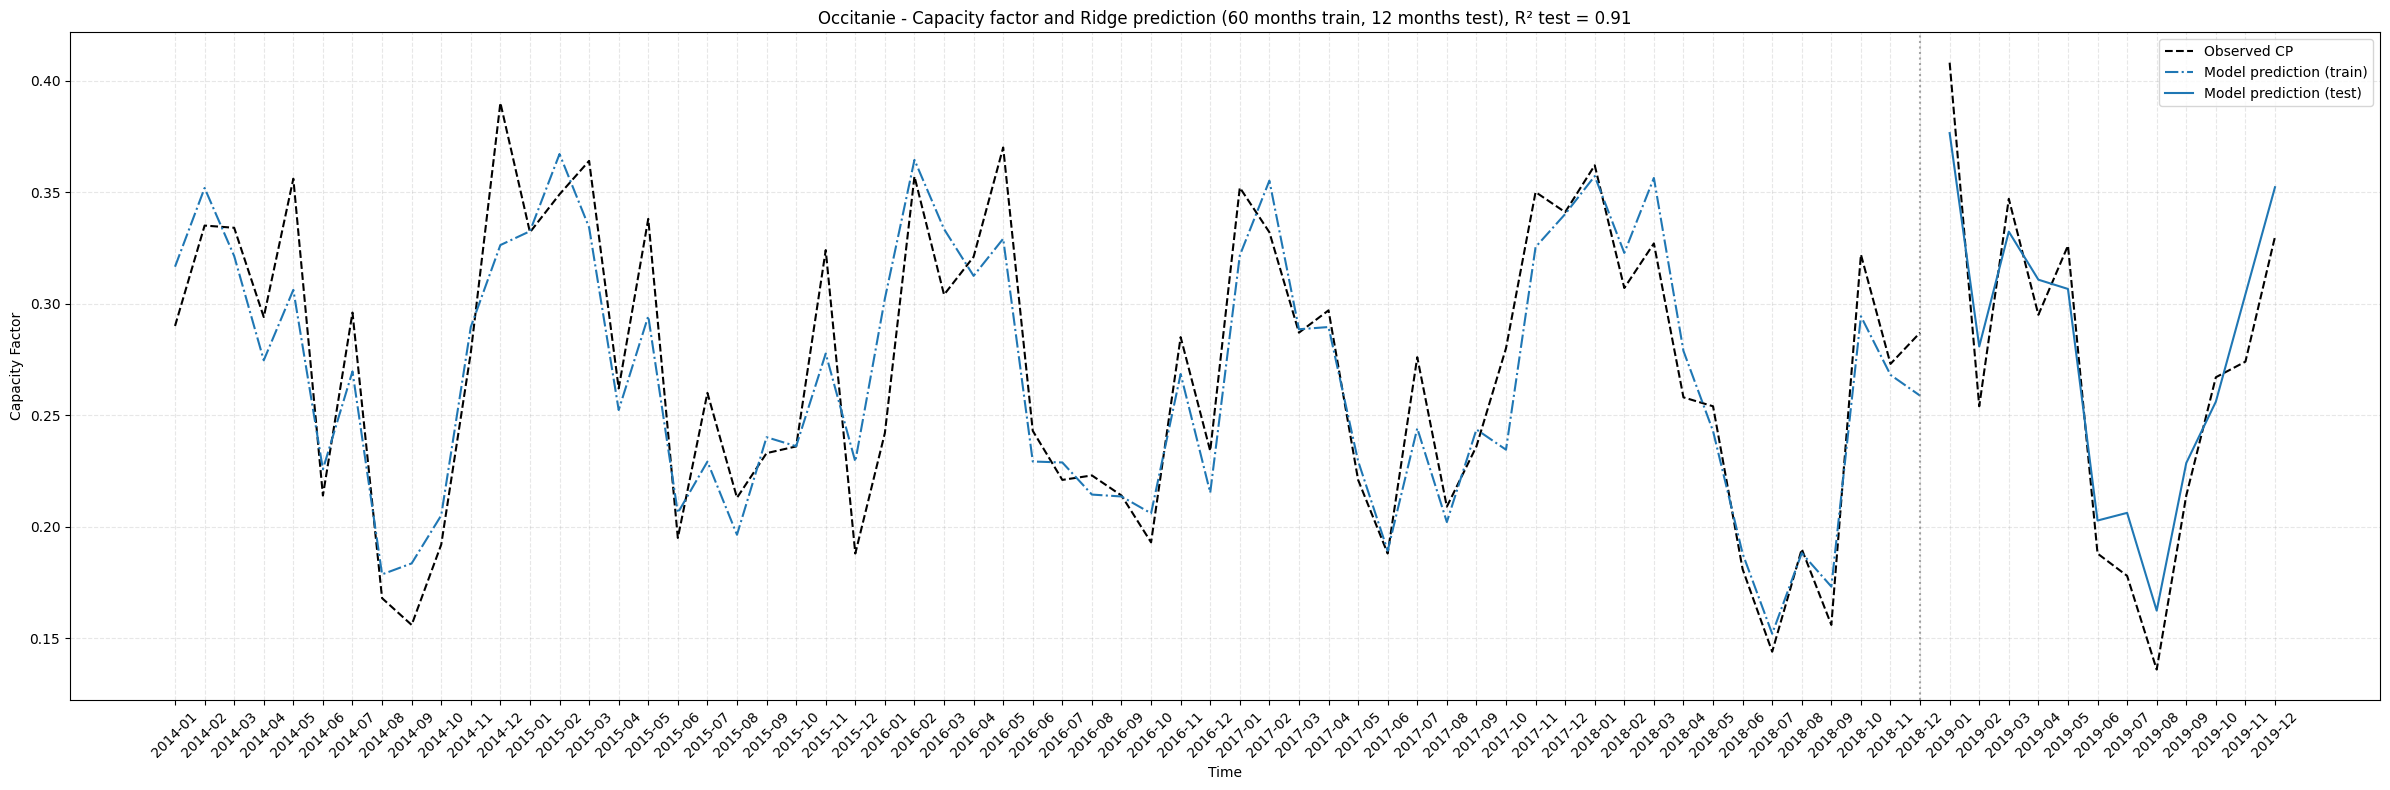

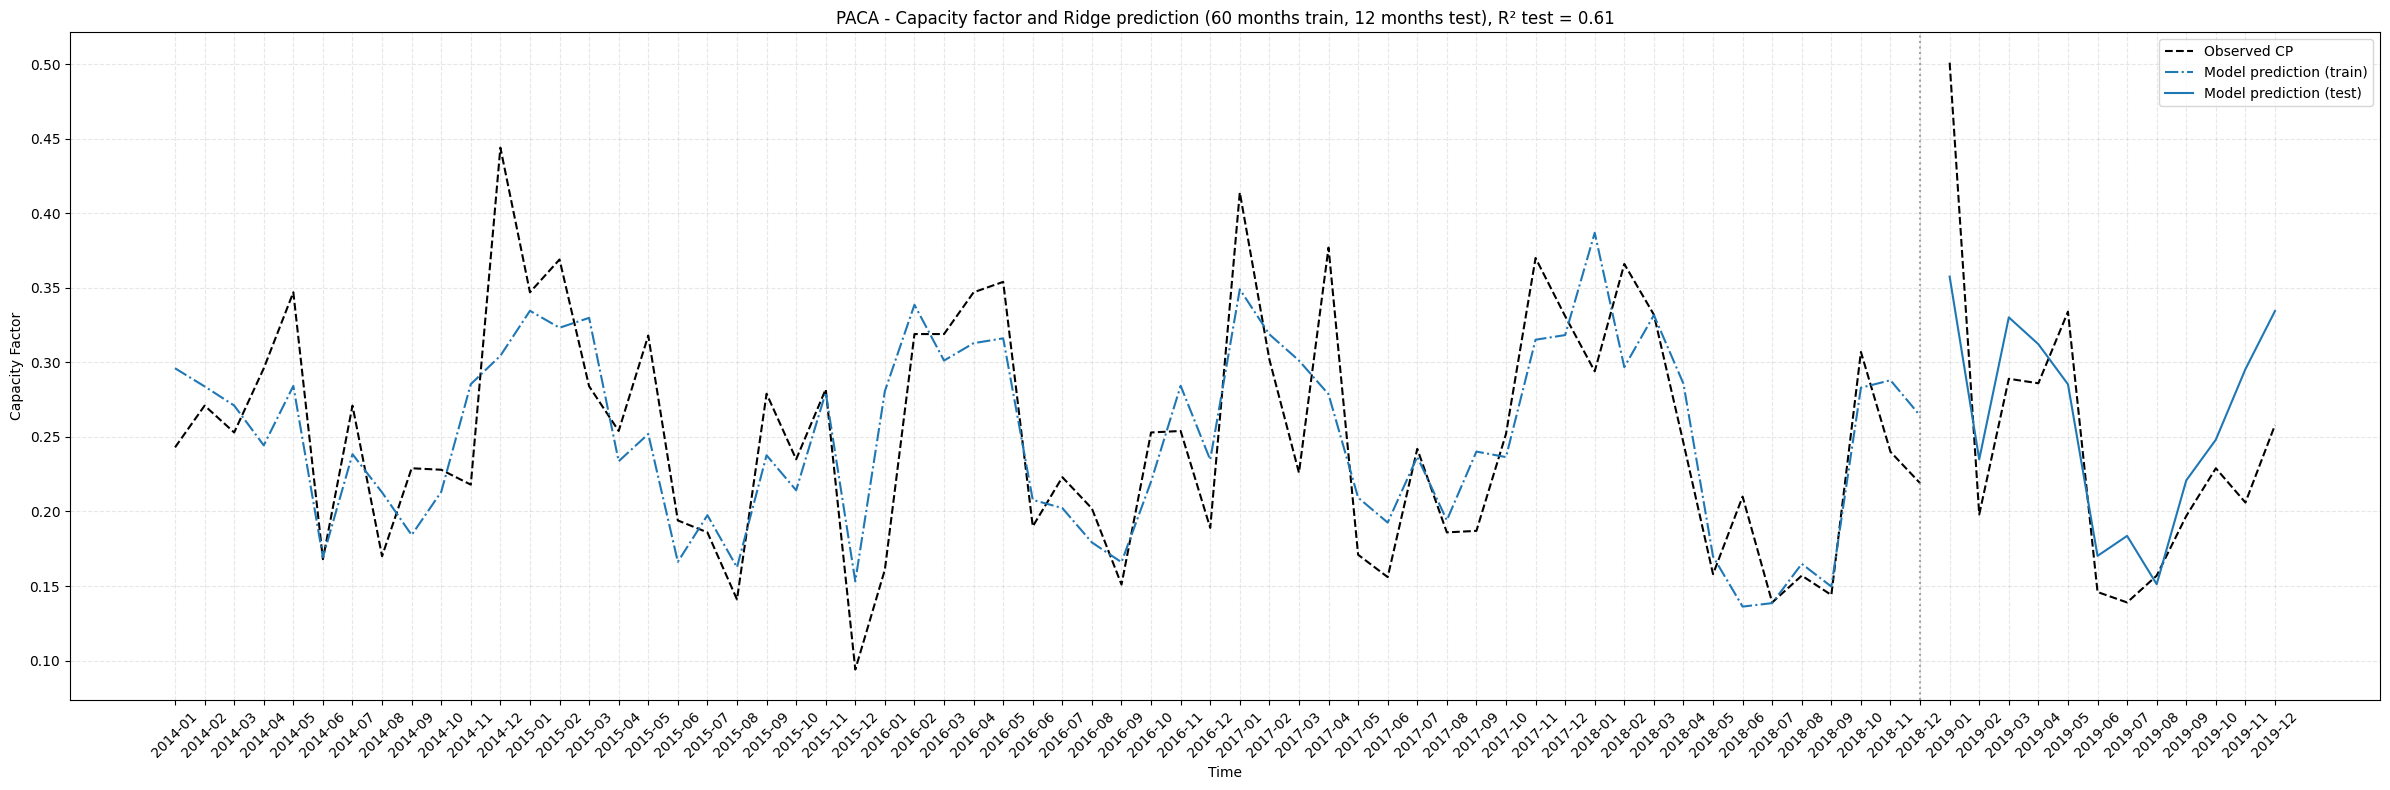

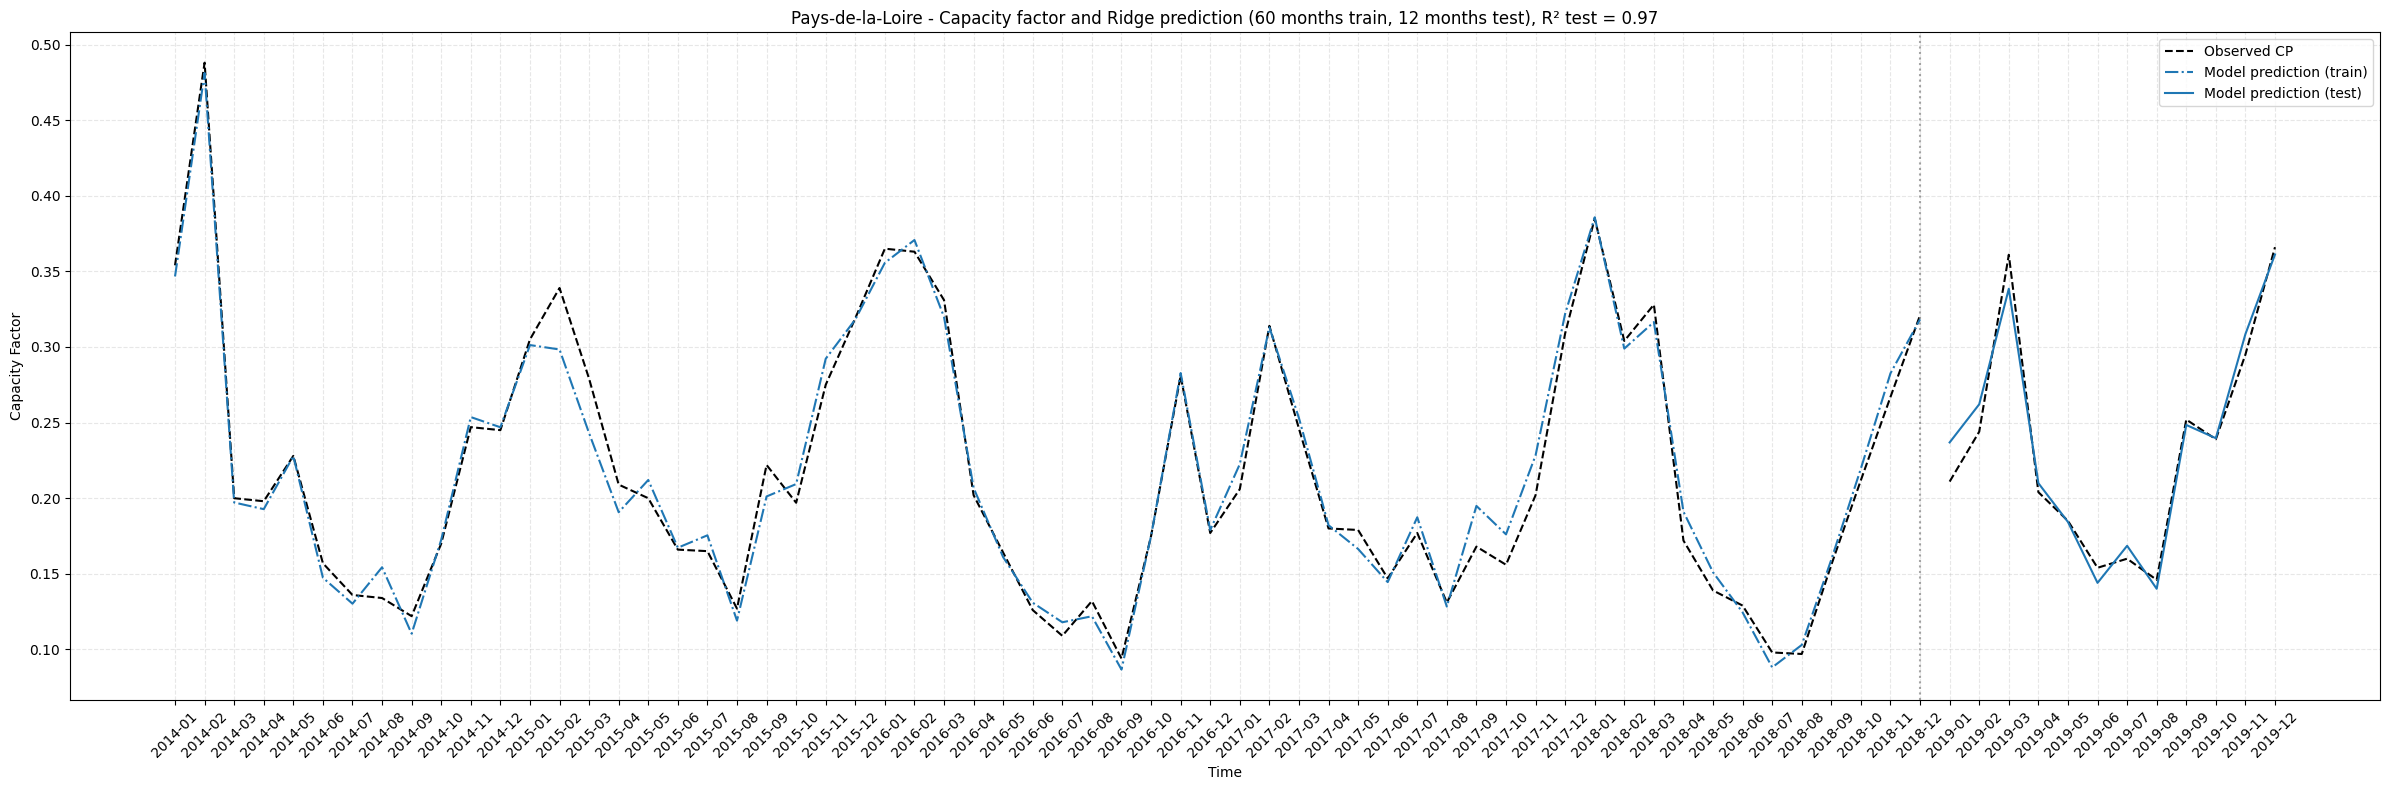

In [135]:
y_pred_train = ridge_model.predict(X_train)
y_pred_test  = ridge_model.predict(X_test)

df_train_meta = df_model.loc[train_mask, ["year_month", "capacity_factor"]].copy()
df_test_meta  = df_model.loc[test_mask,  ["year_month", "capacity_factor"]].copy()

region_cols = [c for c in X.columns if c.startswith("region_")]

for col in region_cols:
    region_name = col.replace("region_", "")

    idx_train = train_mask & (X[col] == 1)
    idx_test  = test_mask  & (X[col] == 1)

    if idx_train.sum() == 0 or idx_test.sum() == 0:
        continue


    y_train_r = df_model.loc[idx_train, "capacity_factor"].values
    y_test_r  = df_model.loc[idx_test,  "capacity_factor"].values


    y_pred_train_r = ridge_model.predict(X.loc[idx_train])
    y_pred_test_r  = ridge_model.predict(X.loc[idx_test])

    df_time_train = df_model.loc[idx_train, ["year_month"]].copy()
    df_time_test  = df_model.loc[idx_test,  ["year_month"]].copy()

    df_time_train["y_obs"] = y_train_r
    df_time_train["y_pred"] = y_pred_train_r
    df_time_train["split"] = "train"

    df_time_test["y_obs"] = y_test_r
    df_time_test["y_pred"] = y_pred_test_r
    df_time_test["split"] = "test"

    df_r = pd.concat([df_time_train, df_time_test], axis=0).sort_values("year_month")
    time_index = df_r["year_month"].astype(str).values

    n_train = int((df_r["split"] == "train").sum())
    test_size = int((df_r["split"] == "test").sum())

    R2_test_r = r2_score(y_test_r, y_pred_test_r)

    plt.figure(figsize=(24, 8))


    plt.plot(time_index[:n_train], df_r["y_obs"].values[:n_train], "k--", label="Observed CP")
    plt.plot(time_index[n_train:],  df_r["y_obs"].values[n_train:],  "k--")


    plt.plot(
        time_index[:n_train],
        df_r["y_pred"].values[:n_train],
        color="C0",
        linestyle="-.",
        label="Model prediction (train)"
    )
    plt.plot(
        time_index[n_train:],
        df_r["y_pred"].values[n_train:],
        color="C0",
        linestyle="-",
        label="Model prediction (test)"
    )

    plt.axvline(time_index[n_train-1], color="gray", linestyle=":", alpha=0.7)

    plt.xlabel("Time")
    plt.ylabel("Capacity Factor")
    plt.title(
        f"{region_name} - Capacity factor and Ridge prediction "
        f"({n_train} months train, {test_size} months test), "
        f"R² test = {R2_test_r:.2f}"
    )
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [136]:
ols_model = Pipeline([
    ("scaler", StandardScaler()),
    ("ols", LinearRegression())
])

ols_model.fit(X_train, y_train)
y_pred_ols = ols_model.predict(X_test)

print("OLS test metrics:", regression_metrics(y_test, y_pred_ols))

lasso_model = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso", LassoCV(alphas=alphas, cv=5, max_iter=10000))
])

lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)

print("Best alpha (Lasso):", lasso_model.named_steps["lasso"].alpha_)
print("Lasso test metrics:", regression_metrics(y_test, y_pred_lasso))

n_nonzero = np.sum(lasso_model.named_steps["lasso"].coef_ != 0)
print("Non-zero coefficients (Lasso):", n_nonzero)


OLS test metrics: {'R2': 0.8620464836264659, 'MAE': 0.023784963343118984, 'RMSE': 0.0009751471832364222}
Best alpha (Lasso): 0.004291934260128779
Lasso test metrics: {'R2': 0.7785509507683013, 'MAE': 0.029633438146451013, 'RMSE': 0.0015653491282089796}
Non-zero coefficients (Lasso): 19


In [143]:
def ridge_region_contributions(ridge_pipeline, X, region_col, top_k=25):
    # Select rows for the chosen region using the one hot column, e.g. "region_Ile-de-France"
    idx = X[region_col] == 1
    Xr = X.loc[idx].copy()
    if Xr.empty:
        raise ValueError(f"No rows found for {region_col}")

    scaler = ridge_pipeline.named_steps["scaler"]
    ridge = ridge_pipeline.named_steps["ridge"]

    # Scale features like the model sees them
    Xr_scaled = pd.DataFrame(
        scaler.transform(Xr),
        columns=X.columns,
        index=Xr.index
    )

    coefs = pd.Series(ridge.coef_, index=X.columns)

    # Per feature mean contribution in that region
    mean_contrib = (Xr_scaled * coefs).mean(axis=0)

    df = pd.DataFrame({
        "feature": mean_contrib.index,
        "mean_contribution": mean_contrib.values,
        "abs_mean_contribution": np.abs(mean_contrib.values),
        "coef": coefs.values,
        "mean_feature_value_scaled": Xr_scaled.mean(axis=0).values,
    }).sort_values("abs_mean_contribution", ascending=False)

    return df.head(top_k), df

# Example: choose a location
region_col = "region_Ile-de-France"   # change to your chosen one hot column
top25_contrib, df_contrib_all = ridge_region_contributions(ridge_model, X_test, region_col, top_k=25)
top25_contrib


feature  mean_contribution   
107                    region_Ile-de-France          -0.018704  \
88                          shear_speed_std          -0.013028   
84                    upper_wind_speed_mean           0.011263   
81                          wind_speed_mean           0.011144   
87                         shear_speed_mean           0.009472   
86                     upper_wind_speed_p90           0.005865   
39                      surface_density_p90          -0.005865   
36                     surface_density_mean          -0.005730   
83                           wind_speed_p90           0.004923   
103                         region_Bretagne           0.004863   
110                        region_Occitanie          -0.004809   
69   upper_meridional_wind_mean_abs_diff_1h          -0.004764   
41                      surface_density_max          -0.004650   
42         surface_density_mean_abs_diff_1h           0.004310   
38                      surface_density_p10          -0.003854   
24     surface_temperature_mean_abs_diff_1h           0.003523   
89                          shear_speed_p90           0.003490   
85                     upper_wind_speed_std           0.003414   
37                      surface_density_std          -0.003392   
78              height_500_mean_abs_diff_1h           0.003281   
6               zonal_wind_mean_abs_diff_1h          -0.003134   
10                      meridional_wind_std           0.002863   
12                      meridional_wind_p90           0.002596   
40                      surface_density_min          -0.002540   
111                             region_PACA          -0.002250   

     abs_mean_contribution      coef  mean_feature_value_scaled  
107               0.018704 -0.005639                   3.316625  
88                0.013028 -0.010571                   1.232389  
84                0.011263  0.016817                   0.669734  
81                0.011144  0.017539                   0.635368  
87                0.009472  0.013619                   0.695518  
86                0.005865  0.010041                   0.584165  
39                0.005865 -0.008813                   0.665459  
36                0.005730 -0.010388                   0.551580  
83                0.004923  0.007512                   0.655439  
103               0.004863 -0.016127                  -0.301511  
110               0.004809  0.015950                  -0.301511  
69                0.004764 -0.003462                   1.376102  
41                0.004650 -0.006650                   0.699230  
42                0.004310  0.004276                   1.008094  
38                0.003854 -0.008828                   0.436562  
24                0.003523  0.004897                   0.719421  
89                0.003490  0.003459                   1.008995  
85                0.003414  0.004977                   0.685978  
37                0.003392 -0.002755                   1.231408  
78                0.003281  0.005538                   0.592584  
6                 0.003134 -0.002490                   1.258640  
10                0.002863  0.004098                   0.698604  
12                0.002596  0.004416                   0.587824  
40                0.002540 -0.007115                   0.357038  
111               0.002250  0.007463                  -0.301511

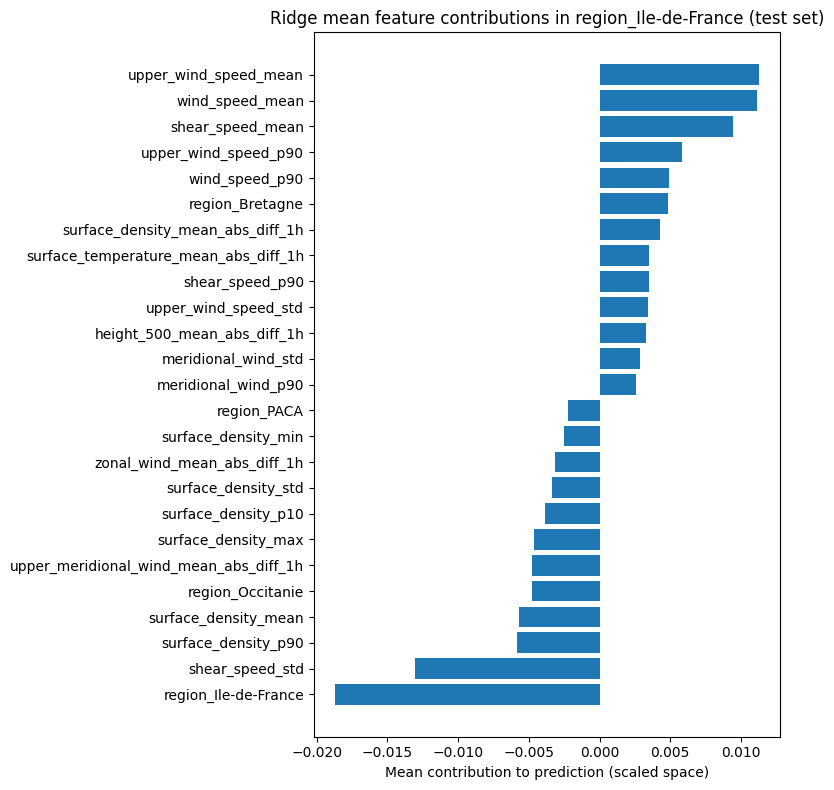

In [144]:
dfp = top25_contrib.sort_values("mean_contribution")
plt.figure(figsize=(8, 8))
plt.barh(dfp["feature"], dfp["mean_contribution"])
plt.title(f"Ridge mean feature contributions in {region_col} (test set)")
plt.xlabel("Mean contribution to prediction (scaled space)")
plt.tight_layout()
plt.show()


## 4. Hourly Wind Production Reconstruction

Hourly wind power production cannot be directly predicted using a machine learning model because only **monthly capacity factor observations** are available, while the climatic variables are provided at **hourly resolution**. 

### Monthly anchor
A Ridge regression model was first trained to predict the **monthly mean wind capacity factor** using aggregated climatic features. This prediction provides a reliable monthly reference value.

### Hourly climatic weighting
Using the available hourly climatic variables, a **relative hourly production profile** was constructed based on physical considerations of wind power generation. In particular, the wind speed dependency was used to define an hourly weight:

$$
w(t) = \lVert V(t) \rVert^3
$$

where $ V(t) $ is the hourly wind speed. This reflects the cubic relationship between wind speed and wind power.

### Monthly normalization
For each month, the hourly weights were normalized so that their monthly average equals one:

$$
p(t) = \frac{w(t)}{\langle w \rangle_{\text{month}}}
$$

This guarantees consistency between hourly and monthly scales.

### Hourly reconstruction
The final hourly capacity factor was obtained by combining the monthly prediction with the normalized hourly profile:

$$
CP_{\text{hour}}(t) = CP_{\text{month}} \times p(t)
$$



In [149]:
def predict_hourly_cp_for_month(
    df_climat_hourly: pd.DataFrame,
    cf_month_pred: float,
    wind_u_col: str = "zonal_wind",
    wind_v_col: str = "meridional_wind",
):
    """
    Reconstruct hourly wind capacity factor within a given month
    using a monthly predicted capacity factor and hourly climate data.

    Parameters
    ----------
    df_climat_hourly : pd.DataFrame
        Hourly climate data for ONE region and ONE month.
        Must contain zonal and meridional wind components.
    cf_month_pred : float
        Monthly capacity factor predicted by the Ridge model.
    wind_u_col, wind_v_col : str
        Column names for zonal and meridional wind.

    Returns
    -------
    pd.Series
        Hourly reconstructed capacity factor indexed by time.
    """

    # --- wind speed ---
    u = df_climat_hourly[wind_u_col]
    v = df_climat_hourly[wind_v_col]
    wind_speed = np.sqrt(u**2 + v**2)

    # --- base physical weight (wind power ~ V^3) ---
    w = wind_speed**3

    # --- avoid pathological cases ---
    w = w.replace([np.inf, -np.inf], np.nan).fillna(0.0)

    # --- normalize within the month ---
    w_mean = w.mean()
    if w_mean == 0 or np.isnan(w_mean):
        p = np.ones_like(w)
    else:
        p = w / w_mean

    # --- hourly capacity factor ---
    cf_hourly = cf_month_pred * p

    cf_hourly = np.clip(cf_hourly, 0.0, 16/27)

    return pd.Series(cf_hourly, index=df_climat_hourly.index, name="capacity_factor_hourly")


In [150]:
region = "Ile-de-France"
month  = pd.Period("2019-03", freq="M")

# hourly climate for this region and month
df_hour = df_climat[
    (df_climat["region"] == region) &
    (df_climat["year_month"] == month)
]

# monthly prediction already computed with Ridge
cf_month_pred = (
    df_model.loc[
        (df_model["year_month"] == month) &
        (df_model[f"region_{region}"] == 1),
        :
    ]
    .assign(cf_pred=ridge_model.predict(X.loc[
        (df_model["year_month"] == month) &
        (df_model[f"region_{region}"] == 1)
    ]))
    ["cf_pred"]
    .iloc[0]
)

cf_hourly = predict_hourly_cp_for_month(
    df_climat_hourly=df_hour,
    cf_month_pred=cf_month_pred
)


In [151]:
def plot_hourly_cp_month(
    cf_hourly: pd.Series,
    cf_month_pred: float,
    cf_month_min: float | None = None,
    cf_month_max: float | None = None,
    title: str | None = None,
):
    """
    Plot hourly reconstructed capacity factor for one month,
    including monthly extrema.
    """

    plt.figure(figsize=(22, 6))

    # hourly prediction
    plt.plot(
        cf_hourly.index,
        cf_hourly.values,
        linewidth=1.5,
        label="Hourly reconstructed CP"
    )

    # monthly mean (prediction)
    plt.axhline(
        cf_month_pred,
        linestyle="--",
        linewidth=2,
        label="Monthly predicted CP"
    )

    plt.xlabel("Time")
    plt.ylabel("Capacity Factor")
    if title is not None:
        plt.title(title)

    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()


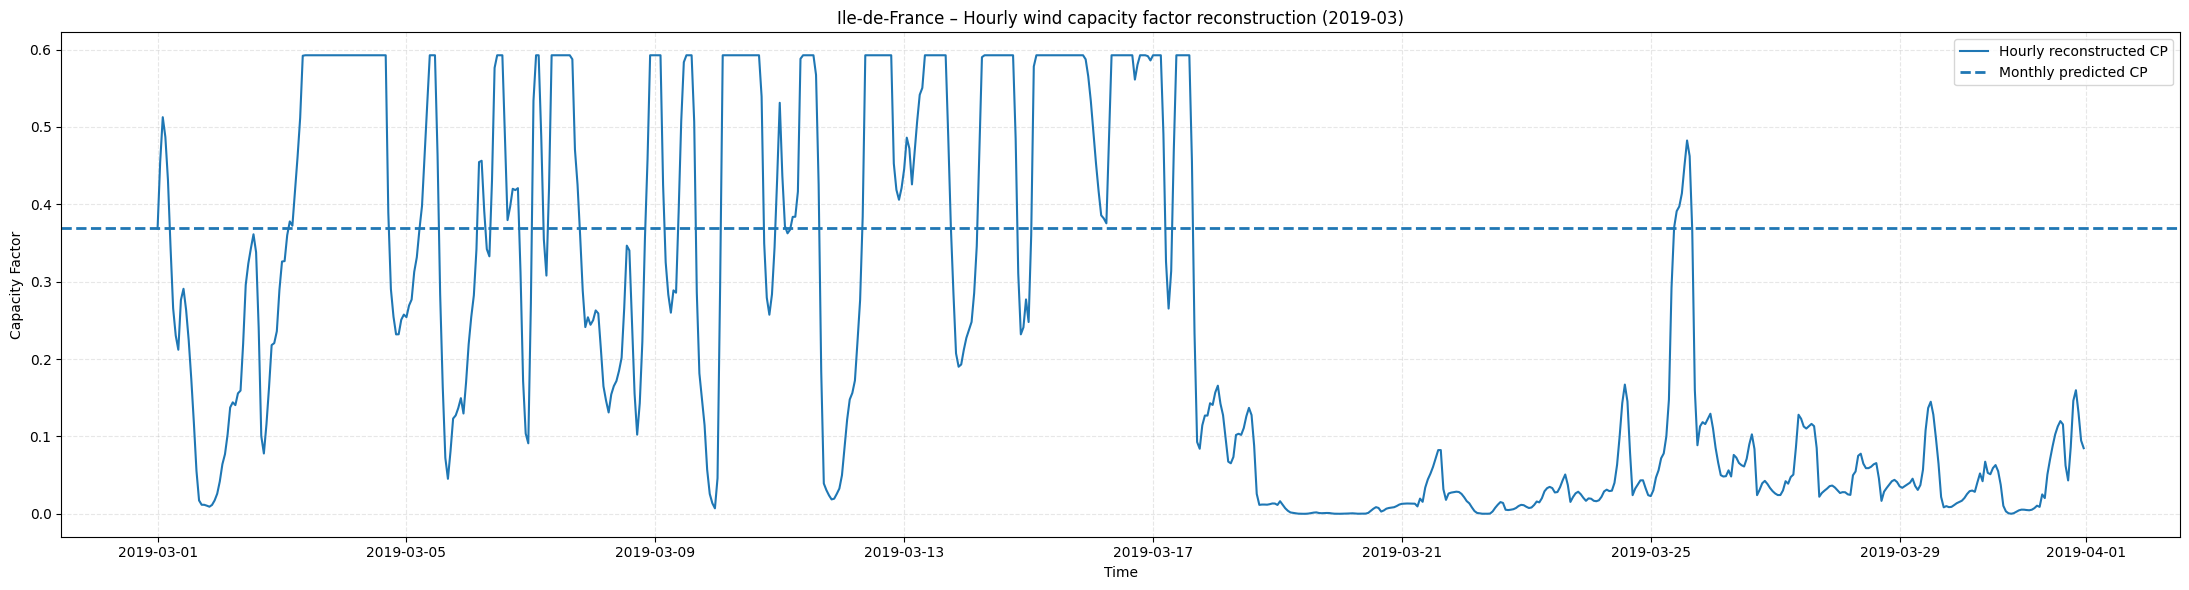

In [152]:
mask_region = df_model[f"region_{region}"] == 1
cf_month_min = df_model.loc[mask_region, "capacity_factor"].min()
cf_month_max = df_model.loc[mask_region, "capacity_factor"].max()
plot_hourly_cp_month(
    cf_hourly=cf_hourly,
    cf_month_pred=cf_month_pred,
    cf_month_min=cf_month_min,
    cf_month_max=cf_month_max,
    title=f"{region} – Hourly wind capacity factor reconstruction ({month})"
)


We see the hourly production for a random month in 2019. We saw that some of the cp values were out of the physical boundary imposed by this measure. Therefore, we imposed a limit to which the measured cp could not surpass, the Betz limite (16/27), with that we imposed a physical boundary to our prediction.

## 5. Conclusion

This project investigated the potential of machine learning regression models to predict monthly wind energy capacity factors in metropolitan France using climate reanalysis data. A complete workflow was implemented, including data preprocessing, temporal aggregation, correlation analysis, and model training with validation strategies that explicitly respect the temporal structure of the dataset.

At an intermediate stage of the study, we observed that the initially proposed models were not able to predict the target capacity factor values with satisfactory performance. After further analysis, we identified two main limitations. First, the models were trained independently for each region, without exploiting information from other regions. Second, the input features were mostly limited to monthly averages, which do not fully capture the intra-monthly climate dynamics.

To address these issues, we extended the modeling strategy by incorporating data from all French regions when training models for a specific region, using one-hot encoding to preserve regional information. In addition, we introduced new features designed to describe the temporal evolution of climate variables within each month, as well as physically motivated variables obtained from combinations of the original climate parameters. These additional features were shown to be highly relevant, as highlighted by the Ridge regression feature importance analysis.

Finally, using the Ridge regression model, we were able to obtain satisfactory predictions of monthly capacity factors for most regions, although some areas, such as Île-de-France, still exhibited relatively low \( R^2 \) values. Building on these results, we proposed a normalization approach based on wind data and physical constraints to estimate hourly wind energy production from the predicted monthly capacity factors for a given region in France.


***
## Credit

[//]: # "This notebook is part of [E4C Interdisciplinary Center - Education](https://gitlab.in2p3.fr/energy4climate/public/education)."
Contributors include Bruno Deremble and Alexis Tantet.
Several slides and images are taken from the very good [Scikit-learn course](https://inria.github.io/scikit-learn-mooc/).

<br>

<div style="display: flex; height: 70px">
    
<img alt="Logo LMD" src="images/logos/logo_lmd.jpg" style="display: inline-block"/>

<img alt="Logo IPSL" src="images/logos/logo_ipsl.png" style="display: inline-block"/>

<img alt="Logo E4C" src="images/logos/logo_e4c_final.png" style="display: inline-block"/>

<img alt="Logo EP" src="images/logos/logo_ep.png" style="display: inline-block"/>

<img alt="Logo SU" src="images/logos/logo_su.png" style="display: inline-block"/>

<img alt="Logo ENS" src="images/logos/logo_ens.jpg" style="display: inline-block"/>

<img alt="Logo CNRS" src="images/logos/logo_cnrs.png" style="display: inline-block"/>
    
</div>

<hr>

<div style="display: flex">
    <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0; margin-right: 10px" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a>
    <br>This work is licensed under a &nbsp; <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.
</div>